In [1]:
import numpy as np
import pandas
import pm4py
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
import scipy.stats as stats
import ot

In [2]:
#file_path = '../../data/BPI Challenge 2017.xes'
#file_path = '../../data/InternationalDeclarations.xes'
#file_path = '../../data/BPI_Challenge_2019.xes'
#file_path = '../../data/BPI Challenge 2018.xes'
file_path = '../../data/BPI_Challenge_2012.xes'
event_log = pm4py.read_xes(file_path)

/home/michelkunkler/.local/share/virtualenvs/TaskExecutionTimeMining--mAzMuWa/lib/python3.10/site-packages/pm4py/util/dt_parsing/parser.py:77: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/13087 [00:00<?, ?it/s]

In [3]:
event_log

org:resource lifecycle:transition            concept:name  \
0               112             COMPLETE             A_SUBMITTED   
1               112             COMPLETE       A_PARTLYSUBMITTED   
2               112             COMPLETE           A_PREACCEPTED   
3               112             SCHEDULE  W_Completeren aanvraag   
4               NaN                START  W_Completeren aanvraag   
...             ...                  ...                     ...   
262195          112             COMPLETE       A_PARTLYSUBMITTED   
262196          112             SCHEDULE      W_Afhandelen leads   
262197        11169                START      W_Afhandelen leads   
262198        11169             COMPLETE              A_DECLINED   
262199        11169             COMPLETE      W_Afhandelen leads   

                         time:timestamp                    case:REG_DATE  \
0      2011-10-01 00:38:44.546000+00:00 2011-10-01 00:38:44.546000+00:00   
1      2011-10-01 00:38:44.880000+00:00 2011-10-01 00:38:44.546000+00:00   
2      2011-10-01 00:39:37.906000+00:00 2011-10-01 00:38:44.546000+00:00   
3      2011-10-01 00:39:38.875000+00:00 2011-10-01 00:38:44.546000+00:00   
4      2011-10-01 11:36:46.437000+00:00 2011-10-01 00:38:44.546000+00:00   
...                                 ...                              ...   
262195 2012-02-29 23:51:17.423000+00:00 2012-02-29 23:51:16.799000+00:00   
262196 2012-02-29 23:52:01.287000+00:00 2012-02-29 23:51:16.799000+00:00   
262197 2012-03-01 09:26:46.736000+00:00 2012-02-29 23:51:16.799000+00:00   
262198 2012-03-01 09:27:37.118000+00:00 2012-02-29 23:51:16.799000+00:00   
262199 2012-03-01 09:27:41.325000+00:00 2012-02-29 23:51:16.799000+00:00   

       case:concept:name case:AMOUNT_REQ  
0                 173688           20000  
1                 173688           20000  
2                 173688           20000  
3                 173688           20000  
4                 173688           20000  
...                  ...             ...  
262195            214376           15000  
262196            214376           15000  
262197            214376           15000  
262198            214376           15000  
262199            214376           15000  

[262200 rows x 7 columns]

In [4]:
event_log[(event_log['case:concept:name'] == '173688') & (event_log['concept:name'] == 'W_Nabellen offertes')].sort_values('time:timestamp')

org:resource lifecycle:transition         concept:name  \
10          NaN             SCHEDULE  W_Nabellen offertes   
12          NaN                START  W_Nabellen offertes   
13          NaN             COMPLETE  W_Nabellen offertes   
14        10913                START  W_Nabellen offertes   
15        10913             COMPLETE  W_Nabellen offertes   
16        11049                START  W_Nabellen offertes   
19        11049             COMPLETE  W_Nabellen offertes   

                     time:timestamp                    case:REG_DATE  \
10 2011-10-01 11:45:11.554000+00:00 2011-10-01 00:38:44.546000+00:00   
12 2011-10-01 12:15:41.290000+00:00 2011-10-01 00:38:44.546000+00:00   
13 2011-10-01 12:17:08.924000+00:00 2011-10-01 00:38:44.546000+00:00   
14 2011-10-08 16:26:57.720000+00:00 2011-10-01 00:38:44.546000+00:00   
15 2011-10-08 16:32:00.886000+00:00 2011-10-01 00:38:44.546000+00:00   
16 2011-10-10 11:32:22.495000+00:00 2011-10-01 00:38:44.546000+00:00   
19 2011-10-10 11:33:05.791000+00:00 2011-10-01 00:38:44.546000+00:00   

   case:concept:name case:AMOUNT_REQ  
10            173688           20000  
12            173688           20000  
13            173688           20000  
14            173688           20000  
15            173688           20000  
16            173688           20000  
19            173688           20000

In [5]:
pandas.unique(event_log['case:concept:name']).shape

(13087,)

In [6]:
merged_event_log = pandas.merge(event_log, event_log,
                                left_on=['case:concept:name', 'org:resource', 'concept:name'],
                                right_on=['case:concept:name', 'org:resource', 'concept:name'],
                                suffixes=('_start', '_complete'))
start_end_event_log = merged_event_log[(merged_event_log['lifecycle:transition_start'] == 'START') & (merged_event_log['lifecycle:transition_complete'] == 'COMPLETE')]
start_end_event_log.loc[:, 'duration'] = start_end_event_log['time:timestamp_complete'] - start_end_event_log['time:timestamp_start']
start_end_event_log.loc[:, 'duration_seconds'] =  (start_end_event_log['duration']).astype('timedelta64[s]').astype(int)
start_end_event_log = start_end_event_log[start_end_event_log['duration_seconds'] > 0]
start_end_event_log

/tmp/ipykernel_154164/3138905879.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_end_event_log.loc[:, 'duration'] = start_end_event_log['time:timestamp_complete'] - start_end_event_log['time:timestamp_start']
/tmp/ipykernel_154164/3138905879.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_end_event_log.loc[:, 'duration_seconds'] =  (start_end_event_log['duration']).astype('timedelta64[s]').astype(int)


org:resource lifecycle:transition_start            concept:name  \
5               NaN                      START  W_Completeren aanvraag   
18              NaN                      START     W_Nabellen offertes   
23            10913                      START     W_Nabellen offertes   
27            11049                      START     W_Nabellen offertes   
33            10629                      START    W_Valideren aanvraag   
...             ...                        ...                     ...   
729165        11169                      START      W_Afhandelen leads   
729173        11169                      START      W_Afhandelen leads   
729179        10933                      START  W_Completeren aanvraag   
729189        11119                      START     W_Nabellen offertes   
729196        11169                      START      W_Afhandelen leads   

                   time:timestamp_start              case:REG_DATE_start  \
5      2011-10-01 11:36:46.437000+00:00 2011-10-01 00:38:44.546000+00:00   
18     2011-10-01 12:15:41.290000+00:00 2011-10-01 00:38:44.546000+00:00   
23     2011-10-08 16:26:57.720000+00:00 2011-10-01 00:38:44.546000+00:00   
27     2011-10-10 11:32:22.495000+00:00 2011-10-01 00:38:44.546000+00:00   
33     2011-10-13 10:05:26.925000+00:00 2011-10-01 00:38:44.546000+00:00   
...                                 ...                              ...   
729165 2012-03-01 09:25:39.409000+00:00 2012-02-29 23:28:55.349000+00:00   
729173 2012-03-01 09:25:47.680000+00:00 2012-02-29 23:43:09.766000+00:00   
729179 2012-03-01 20:11:14.761000+00:00 2012-02-29 23:43:09.766000+00:00   
729189 2012-03-10 12:46:22.700000+00:00 2012-02-29 23:43:09.766000+00:00   
729196 2012-03-01 09:26:46.736000+00:00 2012-02-29 23:51:16.799000+00:00   

       case:concept:name case:AMOUNT_REQ_start lifecycle:transition_complete  \
5                 173688                 20000                      COMPLETE   
18                173688                 20000                      COMPLETE   
23                173688                 20000                      COMPLETE   
27                173688                 20000                      COMPLETE   
33                173688                 20000                      COMPLETE   
...                  ...                   ...                           ...   
729165            214370                 20000                      COMPLETE   
729173            214373                  8500                      COMPLETE   
729179            214373                  8500                      COMPLETE   
729189            214373                  8500                      COMPLETE   
729196            214376                 15000                      COMPLETE   

                time:timestamp_complete           case:REG_DATE_complete  \
5      2011-10-01 11:45:13.917000+00:00 2011-10-01 00:38:44.546000+00:00   
18     2011-10-01 12:17:08.924000+00:00 2011-10-01 00:38:44.546000+00:00   
23     2011-10-08 16:32:00.886000+00:00 2011-10-01 00:38:44.546000+00:00   
27     2011-10-10 11:33:05.791000+00:00 2011-10-01 00:38:44.546000+00:00   
33     2011-10-13 10:37:37.026000+00:00 2011-10-01 00:38:44.546000+00:00   
...                                 ...                              ...   
729165 2012-03-01 09:28:21.228000+00:00 2012-02-29 23:28:55.349000+00:00   
729173 2012-03-01 09:27:52.388000+00:00 2012-02-29 23:43:09.766000+00:00   
729179 2012-03-01 20:22:41.157000+00:00 2012-02-29 23:43:09.766000+00:00   
729189 2012-03-10 12:50:54.881000+00:00 2012-02-29 23:43:09.766000+00:00   
729196 2012-03-01 09:27:41.325000+00:00 2012-02-29 23:51:16.799000+00:00   

       case:AMOUNT_REQ_complete               duration  duration_seconds  
5                         20000 0 days 00:08:27.480000               507  
18                        20000 0 days 00:01:27.634000                87  
23                        20000 0 days 00:05:03.166000               303  
27                        20000

In [7]:
start_end_event_log[start_end_event_log['case:concept:name'] == '173691'].sort_values('time:timestamp_start')

org:resource lifecycle:transition_start            concept:name  \
45           NaN                      START  W_Completeren aanvraag   
47           NaN                      START  W_Completeren aanvraag   
55           NaN                      START  W_Completeren aanvraag   
75           NaN                      START     W_Nabellen offertes   
78           NaN                      START     W_Nabellen offertes   
80           NaN                      START     W_Nabellen offertes   
94           NaN                      START     W_Nabellen offertes   
96           NaN                      START     W_Nabellen offertes   
124          NaN                      START     W_Nabellen offertes   
134        11049                      START     W_Nabellen offertes   
140        10809                      START    W_Valideren aanvraag   
142        10809                      START    W_Valideren aanvraag   
144        10809                      START    W_Valideren aanvraag   
154        10809                      START    W_Valideren aanvraag   
156        10809                      START    W_Valideren aanvraag   
168        10809                      START    W_Valideren aanvraag   

                time:timestamp_start              case:REG_DATE_start  \
45  2011-10-01 11:37:32.393000+00:00 2011-10-01 08:08:58.256000+00:00   
47  2011-10-01 11:37:32.393000+00:00 2011-10-01 08:08:58.256000+00:00   
55  2011-10-01 14:27:57.775000+00:00 2011-10-01 08:08:58.256000+00:00   
75  2011-10-01 14:36:13.443000+00:00 2011-10-01 08:08:58.256000+00:00   
78  2011-10-01 14:36:13.443000+00:00 2011-10-01 08:08:58.256000+00:00   
80  2011-10-01 14:36:13.443000+00:00 2011-10-01 08:08:58.256000+00:00   
94  2011-10-03 16:54:43.257000+00:00 2011-10-01 08:08:58.256000+00:00   
96  2011-10-03 16:54:43.257000+00:00 2011-10-01 08:08:58.256000+00:00   
124 2011-10-03 16:56:34.792000+00:00 2011-10-01 08:08:58.256000+00:00   
134 2011-10-10 10:13:44.827000+00:00 2011-10-01 08:08:58.256000+00:00   
140 2011-10-10 11:12:36.612000+00:00 2011-10-01 08:08:58.256000+00:00   
142 2011-10-10 11:12:36.612000+00:00 2011-10-01 08:08:58.256000+00:00   
144 2011-10-10 11:12:36.612000+00:00 2011-10-01 08:08:58.256000+00:00   
154 2011-10-10 14:11:42.124000+00:00 2011-10-01 08:08:58.256000+00:00   
156 2011-10-10 14:11:42.124000+00:00 2011-10-01 08:08:58.256000+00:00   
168 2011-10-10 14:14:52.842000+00:00 2011-10-01 08:08:58.256000+00:00   

    case:concept:name case:AMOUNT_REQ_start lifecycle:transition_complete  \
45             173691                  5000                      COMPLETE   
47             173691                  5000                      COMPLETE   
55             173691                  5000                      COMPLETE   
75             173691                  5000                      COMPLETE   
78             173691                  5000                      COMPLETE   
80             173691                  5000                      COMPLETE   
94             173691                  5000                      COMPLETE   
96             173691                  5000                      COMPLETE   
124            173691                  5000                      COMPLETE   
134            173691                  5000                      COMPLETE   
140            173691                  5000                      COMPLETE   
142            173691                  5000                      COMPLETE   
144            173691                  5000                      COMPLETE   
154            173691                  5000                      COMPLETE   
156            173691                  5000                      COMPLETE   
168            173691                  5000                      COMPLETE   

             time:timestamp_complete           case:REG_DATE_complete  \
45  2011-10-01 11:43:13.178000+00:00 2011-10-01 08:08:58.256000+00:00   
47  2011-10-01 14:35:48.791000+00:00 2011-10-01 08:08:58.256000+00:00   
55  2011-10-01 14:35:48.7

## Exemplary case
Id: 173691

In [8]:
start_end_event_log = start_end_event_log.loc[start_end_event_log.groupby(
    ['org:resource', 'lifecycle:transition_start', 'concept:name', 'time:timestamp_start'], dropna=False)['duration'].idxmin()]

In [9]:
start_end_event_log[start_end_event_log['case:concept:name'] == '173691'].sort_values('time:timestamp_start')

org:resource lifecycle:transition_start            concept:name  \
45           NaN                      START  W_Completeren aanvraag   
55           NaN                      START  W_Completeren aanvraag   
75           NaN                      START     W_Nabellen offertes   
94           NaN                      START     W_Nabellen offertes   
124          NaN                      START     W_Nabellen offertes   
134        11049                      START     W_Nabellen offertes   
140        10809                      START    W_Valideren aanvraag   
154        10809                      START    W_Valideren aanvraag   
168        10809                      START    W_Valideren aanvraag   

                time:timestamp_start              case:REG_DATE_start  \
45  2011-10-01 11:37:32.393000+00:00 2011-10-01 08:08:58.256000+00:00   
55  2011-10-01 14:27:57.775000+00:00 2011-10-01 08:08:58.256000+00:00   
75  2011-10-01 14:36:13.443000+00:00 2011-10-01 08:08:58.256000+00:00   
94  2011-10-03 16:54:43.257000+00:00 2011-10-01 08:08:58.256000+00:00   
124 2011-10-03 16:56:34.792000+00:00 2011-10-01 08:08:58.256000+00:00   
134 2011-10-10 10:13:44.827000+00:00 2011-10-01 08:08:58.256000+00:00   
140 2011-10-10 11:12:36.612000+00:00 2011-10-01 08:08:58.256000+00:00   
154 2011-10-10 14:11:42.124000+00:00 2011-10-01 08:08:58.256000+00:00   
168 2011-10-10 14:14:52.842000+00:00 2011-10-01 08:08:58.256000+00:00   

    case:concept:name case:AMOUNT_REQ_start lifecycle:transition_complete  \
45             173691                  5000                      COMPLETE   
55             173691                  5000                      COMPLETE   
75             173691                  5000                      COMPLETE   
94             173691                  5000                      COMPLETE   
124            173691                  5000                      COMPLETE   
134            173691                  5000                      COMPLETE   
140            173691                  5000                      COMPLETE   
154            173691                  5000                      COMPLETE   
168            173691                  5000                      COMPLETE   

             time:timestamp_complete           case:REG_DATE_complete  \
45  2011-10-01 11:43:13.178000+00:00 2011-10-01 08:08:58.256000+00:00   
55  2011-10-01 14:35:48.791000+00:00 2011-10-01 08:08:58.256000+00:00   
75  2011-10-01 14:36:25.794000+00:00 2011-10-01 08:08:58.256000+00:00   
94  2011-10-03 16:56:21.195000+00:00 2011-10-01 08:08:58.256000+00:00   
124 2011-10-03 16:57:16.563000+00:00 2011-10-01 08:08:58.256000+00:00   
134 2011-10-10 10:14:45.514000+00:00 2011-10-01 08:08:58.256000+00:00   
140 2011-10-10 11:30:54.893000+00:00 2011-10-01 08:08:58.256000+00:00   
154 2011-10-10 14:14:13.394000+00:00 2011-10-01 08:08:58.256000+00:00   
168 2011-10-10 14:17:34.633000+00:00 2011-10-01 08:08:58.256000+00:00   

    case:AMOUNT_REQ_complete               duration  duration_seconds  
45                      5000 0 days 00:05:40.785000               340  
55                      5000 0 days 00:07:51.016000               471  
75                      5000 0 days 00:00:12.351000                12  
94                      5000 0 days 00:01:37.938000                97  
124                     5000 0 days 00:00:41.771000                41  
134                     5000 0 days 00:01:00.687000                60  
140                     5000 0 days 00:18:18.281000              1098  
154                     5000 0 days 00:02:31.270000               151  
168                     5000 0 days 00:02:41.791000               161

## Histogram for all activities / resources

<Axes: >

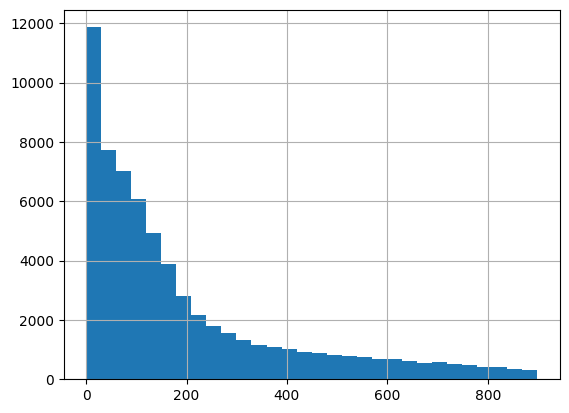

In [10]:
start_end_event_log['duration_seconds'].hist(bins=30, range=(0, start_end_event_log['duration_seconds'].quantile(q=0.9)))

In [11]:
start_end_event_log['duration_seconds'].quantile(q=0.99)

4453.859999999986

In [12]:
start_end_event_log['duration_seconds'].quantile(q=0.999) / 3600

21.199744722222427

99% of the tasks have been finished below 3,6 hours
0.1% of the activities take longer than 58,5 hours -> they were started before a weekend / public holiday and finished afterwards

In [13]:
start_end_event_log[start_end_event_log['duration_seconds'] > start_end_event_log['duration_seconds'].quantile(q=0.999)]


org:resource lifecycle:transition_start            concept:name  \
713984        10609                      START    W_Valideren aanvraag   
176212        10889                      START  W_Completeren aanvraag   
142964        10889                      START     W_Nabellen offertes   
62802         10899                      START  W_Completeren aanvraag   
200391        10909                      START     W_Nabellen offertes   
...             ...                        ...                     ...   
190279          NaN                      START  W_Completeren aanvraag   
216402          NaN                      START  W_Completeren aanvraag   
41516           NaN                      START     W_Nabellen offertes   
14961           NaN                      START     W_Nabellen offertes   
124353          NaN                      START     W_Nabellen offertes   

                   time:timestamp_start              case:REG_DATE_start  \
713984 2012-03-10 12:52:12.676000+00:00 2012-02-27 14:31:12.737000+00:00   
176212 2011-11-05 11:52:32.135000+00:00 2011-11-05 02:36:08.878000+00:00   
142964 2011-11-05 15:38:28.422000+00:00 2011-10-29 11:57:27.124000+00:00   
62802  2011-11-11 10:16:12.354000+00:00 2011-10-12 18:28:03.374000+00:00   
200391 2011-11-18 20:11:57.051000+00:00 2011-11-09 13:17:58.051000+00:00   
...                                 ...                              ...   
190279 2011-11-11 12:57:15.758000+00:00 2011-11-07 21:01:50.154000+00:00   
216402 2011-11-11 16:22:41.858000+00:00 2011-11-11 15:14:07.503000+00:00   
41516  2011-10-07 16:45:35.919000+00:00 2011-10-07 16:01:30.177000+00:00   
14961  2011-10-14 20:50:38.738000+00:00 2011-10-03 21:17:09.458000+00:00   
124353 2011-11-04 16:45:18.246000+00:00 2011-10-25 13:50:37.366000+00:00   

       case:concept:name case:AMOUNT_REQ_start lifecycle:transition_complete  \
713984            213288                  8000                      COMPLETE   
176212            182377                 15000                      COMPLETE   
142964            180628                 25000                      COMPLETE   
62802             176527                  9000                      COMPLETE   
200391            183432                 20000                      COMPLETE   
...                  ...                   ...                           ...   
190279            182954                 10000                      COMPLETE   
216402            184571                  1600                      COMPLETE   
41516             175386                  6500                      COMPLETE   
14961             174270                  6000                      COMPLETE   
124353            179691                 15000                      COMPLETE   

                time:timestamp_complete           case:REG_DATE_complete  \
713984 2012-03-12 06:15:04.118000+00:00 2012-02-27 14:31:12.737000+00:00   
176212 2011-11-07 06:15:04.977000+00:00 2011-11-05 02:36:08.878000+00:00   
142964 2011-11-07 06:15:04.996000+00:00 2011-10-29 11:57:27.124000+00:00   
62802  2011-11-14 06:15:03.782000+00:00 2011-10-12 18:28:03.374000+00:00   
200391 2011-11-21 06:15:04.327000+00:00 2011-11-09 13:17:58.051000+00:00   
...                                 ...                              ...   
190279 2011-11-14 06:15:03.752000+00:00 2011-11-07 21:01:50.154000+00:00   
216402 2011-11-12 15:34:29.204000+00:00 2011-11-11 15:14:07.503000+00:00   
41516  2011-10-10 06:15:05.980000+00:00 2011-10-07 16:01:30.177000+00:00   
14961  2011-10-17 06:15:03.796000+00:00 2011-10-03 21:17:09.458000+00:00   
124353 2011-11-07 06:15:04.956000+00:00 2011-10-25 13:50:37.366000+00:00   

       case:AMOUNT_REQ_complete               duration  duration_seconds  
713984                     8000 1 days 17:22:51.442000            148971  
176212                    15000 1 days 18:22:32.842000            152552  
142964                    25000 1 days 14:36:36.574000            138996  
62802                      9000

In [14]:
pandas.unique(start_end_event_log['concept:name'])

array(['W_Afhandelen leads', 'W_Completeren aanvraag',
       'W_Nabellen offertes', 'W_Valideren aanvraag',
       'W_Nabellen incomplete dossiers', 'W_Beoordelen fraude'],
      dtype=object)

In [15]:
pandas.unique(start_end_event_log['org:resource']).shape

(59,)

W_Afhandelen leads
count      5892.000000
mean       1019.486762
std        9839.706897
min           1.000000
25%          67.000000
50%         115.000000
75%         220.000000
max      243739.000000
Name: duration_seconds, dtype: float64


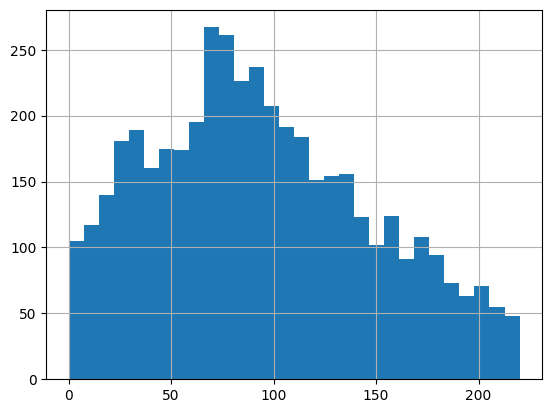

W_Completeren aanvraag
count     23506.000000
mean        612.346380
std        5383.734967
min           1.000000
25%          62.000000
50%         160.000000
75%         476.000000
max      244731.000000
Name: duration_seconds, dtype: float64


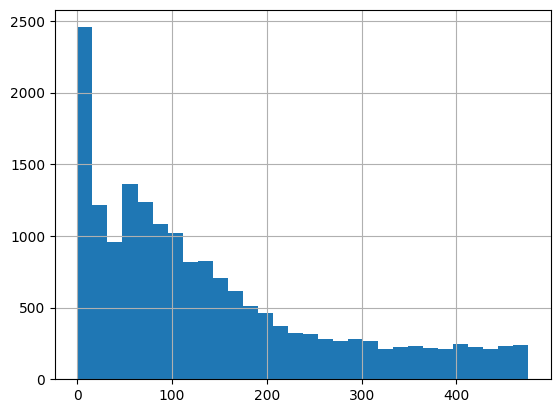

W_Nabellen offertes
count     22405.000000
mean        558.307431
std        7355.847284
min           1.000000
25%          40.000000
50%         101.000000
75%         190.000000
max      243191.000000
Name: duration_seconds, dtype: float64


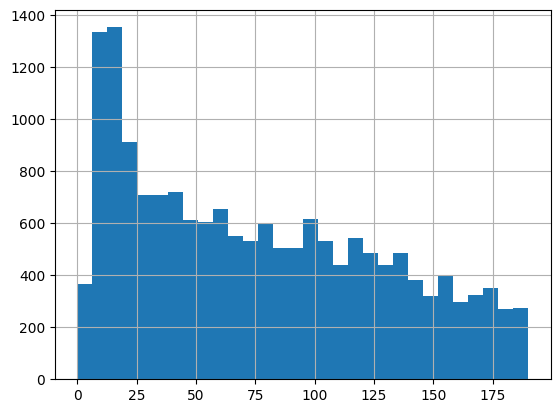

W_Valideren aanvraag
count      7888.000000
mean       1255.819980
std        5806.773458
min           1.000000
25%         232.000000
50%         722.000000
75%        1415.000000
max      238256.000000
Name: duration_seconds, dtype: float64


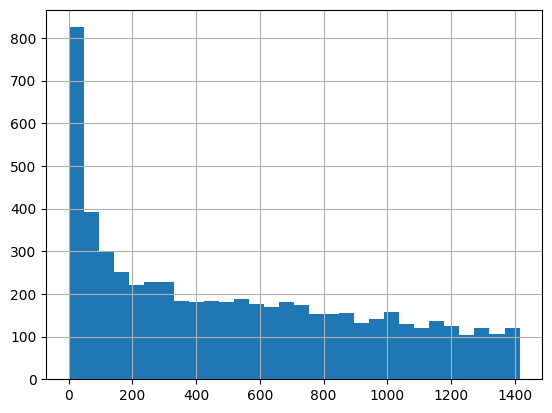

W_Nabellen incomplete dossiers
count     11399.000000
mean        762.122818
std        8022.153821
min           1.000000
25%          36.000000
50%         126.000000
75%         374.000000
max      242764.000000
Name: duration_seconds, dtype: float64


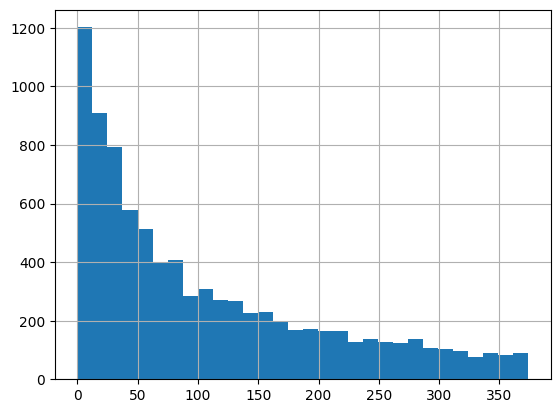

W_Beoordelen fraude
count      268.000000
mean       616.746269
std       5825.996673
min          1.000000
25%          6.000000
50%          9.000000
75%         16.500000
max      76417.000000
Name: duration_seconds, dtype: float64


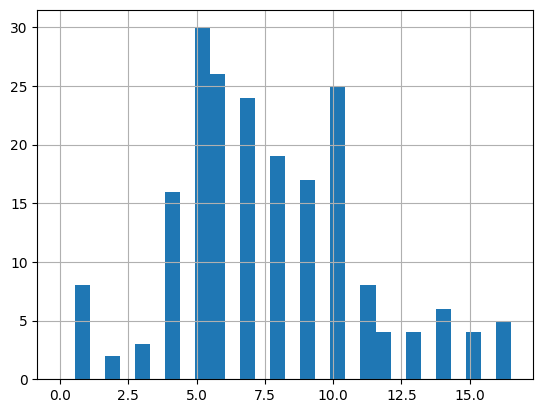

In [16]:
for concept in pandas.unique(start_end_event_log['concept:name']):
    print(concept)
    concept_log = start_end_event_log[start_end_event_log['concept:name'] == concept]
    description = concept_log['duration_seconds'].describe()
    print(description)
    concept_log['duration_seconds'].hist(bins=30, range=(0,description['75%']))
    plt.show()

10124
count      4.000000
mean     234.500000
std      256.407878
min       11.000000
25%       20.000000
50%      206.000000
75%      420.500000
max      515.000000
Name: duration_seconds, dtype: float64


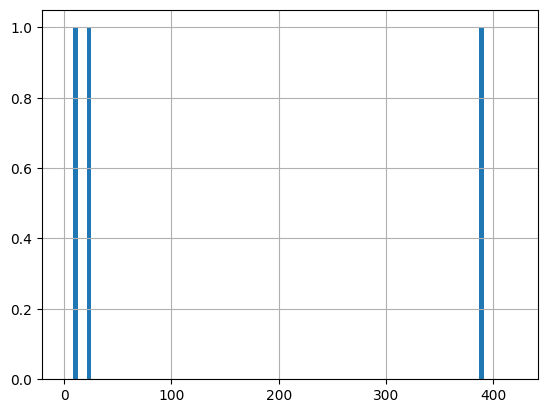

10125
count     2.000000
mean     66.000000
std      25.455844
min      48.000000
25%      57.000000
50%      66.000000
75%      75.000000
max      84.000000
Name: duration_seconds, dtype: float64


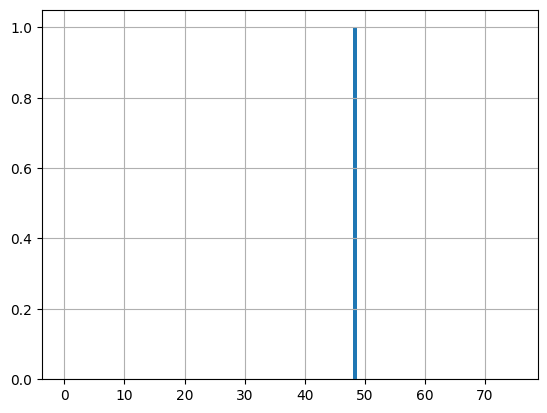

10138
count     1902.000000
mean       835.141956
std       1510.262933
min          1.000000
25%        202.000000
50%        619.000000
75%       1144.500000
max      56763.000000
Name: duration_seconds, dtype: float64


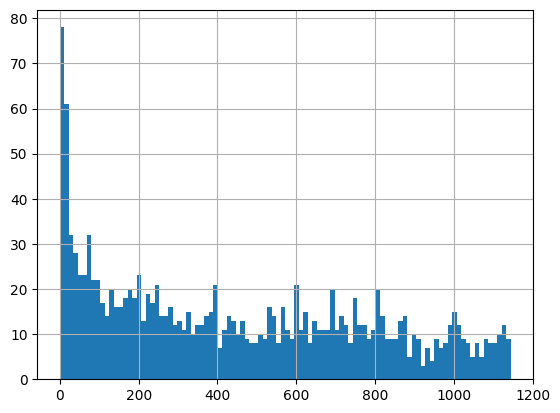

10188
count     210.000000
mean      121.861905
std       832.377074
min         1.000000
25%         5.250000
50%         8.000000
75%        11.000000
max      9240.000000
Name: duration_seconds, dtype: float64


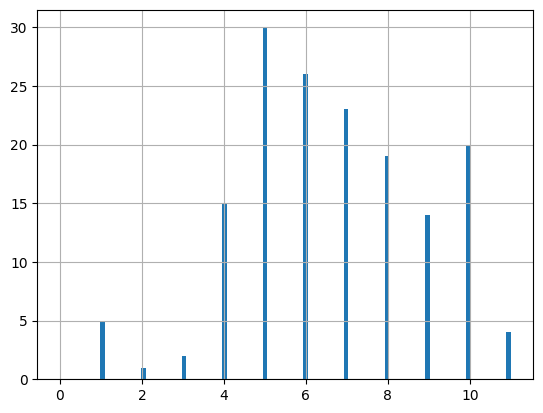

10228
count      198.000000
mean      2513.146465
std      10187.365529
min          5.000000
25%         70.750000
50%        166.500000
75%        411.250000
max      66005.000000
Name: duration_seconds, dtype: float64


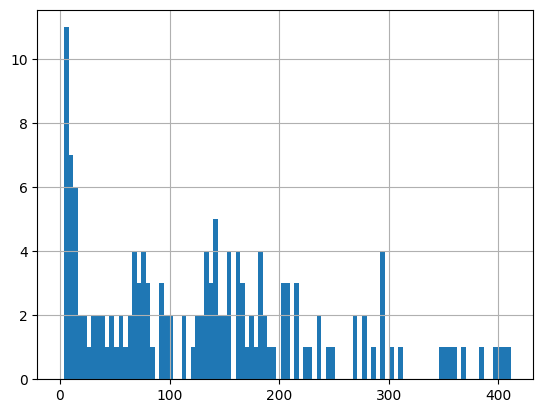

10609
count      2151.000000
mean       1050.541609
std        4141.593509
min           1.000000
25%          70.500000
50%         598.000000
75%        1303.500000
max      148971.000000
Name: duration_seconds, dtype: float64


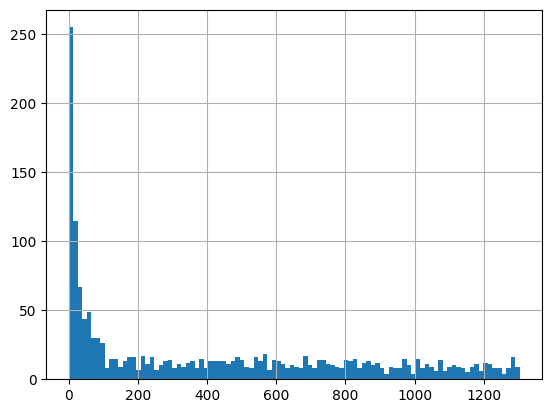

10629
count     1279.000000
mean       817.536357
std       2400.617914
min          1.000000
25%        141.000000
50%        505.000000
75%       1095.500000
max      57542.000000
Name: duration_seconds, dtype: float64


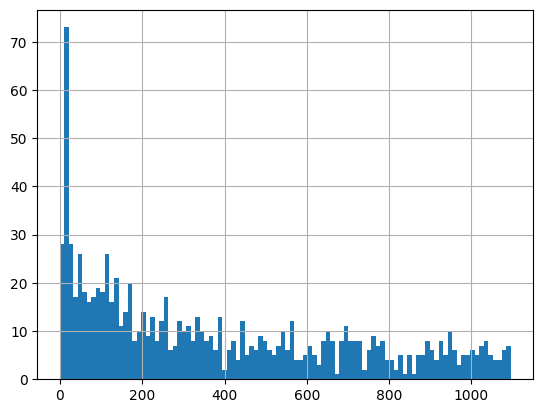

10779
count       35.000000
mean      1742.885714
std       8347.003484
min          1.000000
25%         26.000000
50%         81.000000
75%        310.000000
max      49541.000000
Name: duration_seconds, dtype: float64


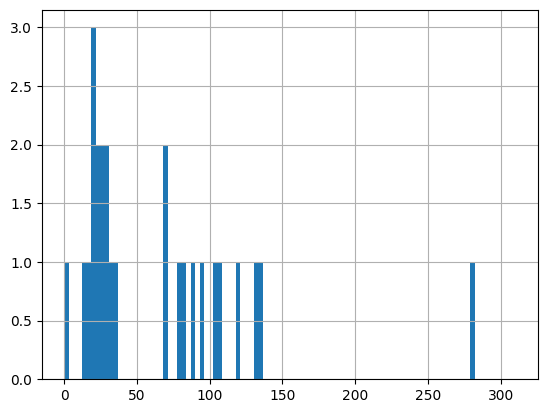

10789
count    401.000000
mean      46.062344
std       60.704807
min        1.000000
25%       14.000000
50%       25.000000
75%       50.000000
max      534.000000
Name: duration_seconds, dtype: float64


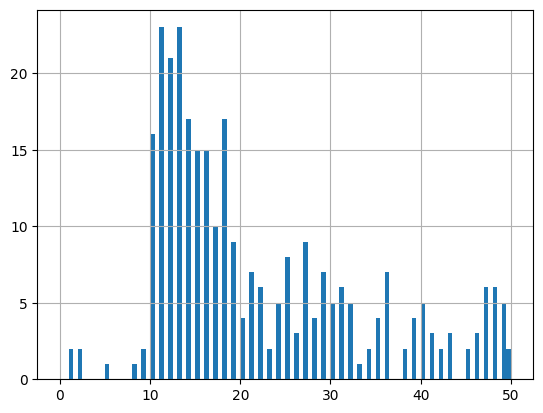

10809
count     1364.000000
mean       805.828446
std       1727.016618
min          1.000000
25%         72.750000
50%        442.500000
75%       1240.250000
max      55603.000000
Name: duration_seconds, dtype: float64


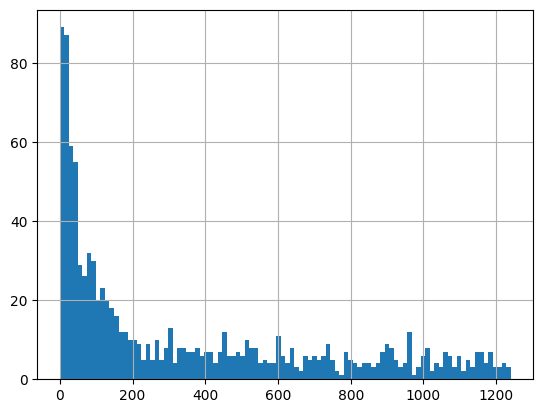

10821
count    1.0
mean     8.0
std      NaN
min      8.0
25%      8.0
50%      8.0
75%      8.0
max      8.0
Name: duration_seconds, dtype: float64


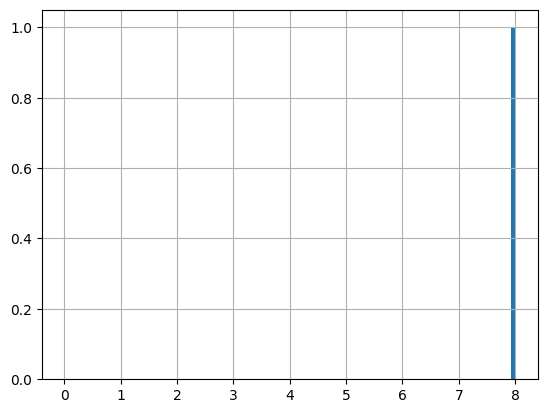

10861
count     2629.000000
mean       368.646634
std       2639.071092
min          1.000000
25%         51.000000
50%        100.000000
75%        198.000000
max      59505.000000
Name: duration_seconds, dtype: float64


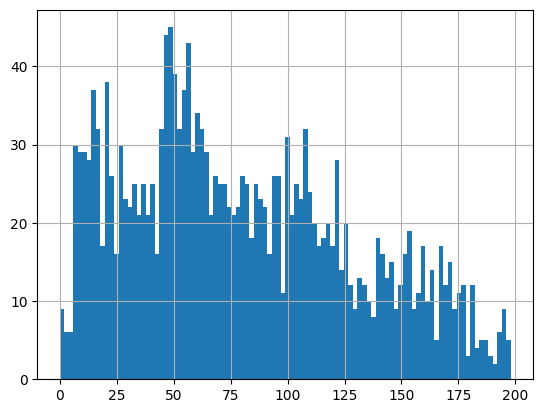

10863
count     1080.000000
mean       381.698148
std       1326.240422
min          1.000000
25%         65.000000
50%        149.500000
75%        351.500000
max      34577.000000
Name: duration_seconds, dtype: float64


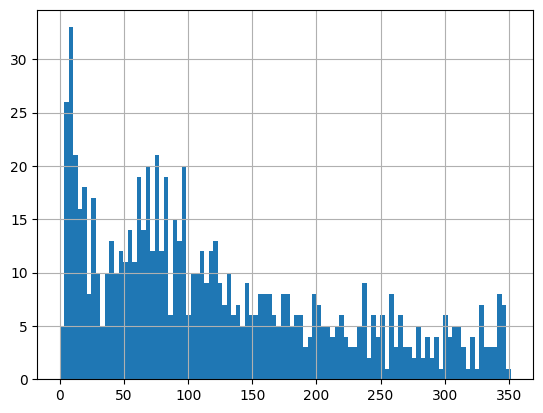

10881
count     1451.000000
mean       302.625775
std       2325.882526
min          1.000000
25%         53.000000
50%        108.000000
75%        217.000000
max      65579.000000
Name: duration_seconds, dtype: float64


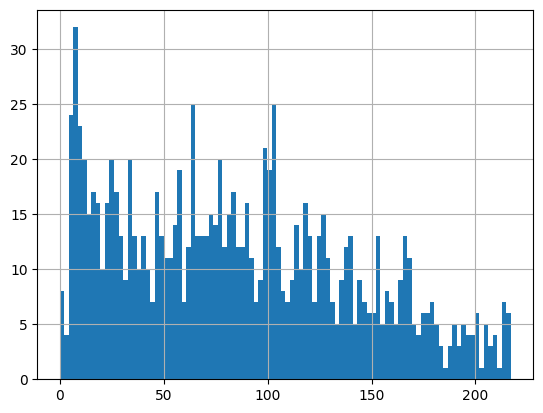

10889
count      1079.000000
mean       1014.559778
std        7671.355512
min           1.000000
25%          73.000000
50%         164.000000
75%         381.000000
max      152552.000000
Name: duration_seconds, dtype: float64


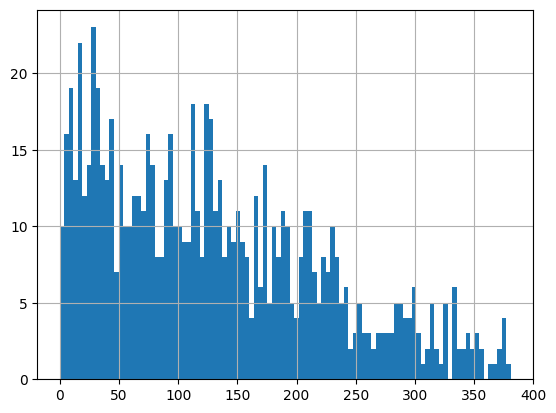

10899
count      1216.000000
mean        407.643914
std        7594.049030
min           1.000000
25%          12.000000
50%          23.000000
75%          41.250000
max      244731.000000
Name: duration_seconds, dtype: float64


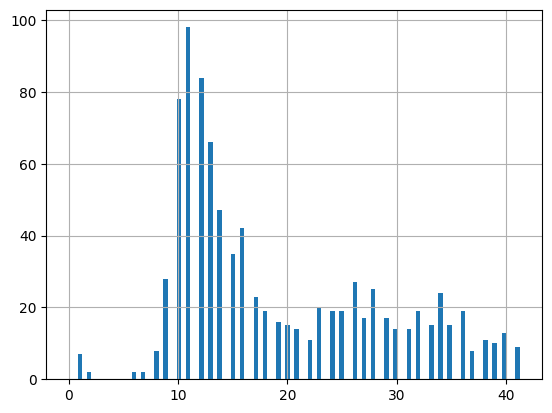

10909
count      2356.000000
mean        645.607385
std        6111.320370
min           1.000000
25%          60.000000
50%         114.500000
75%         257.000000
max      208987.000000
Name: duration_seconds, dtype: float64


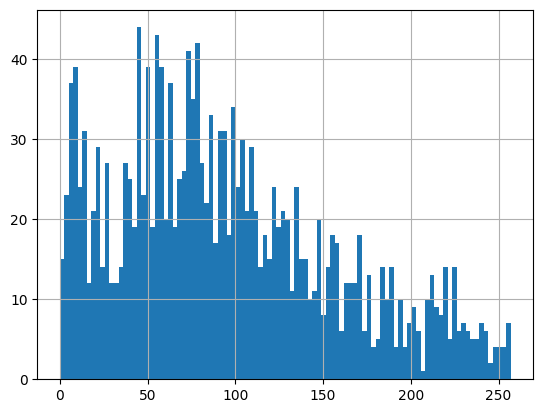

10910
count      1439.000000
mean       1031.466991
std        9789.368136
min           1.000000
25%          46.500000
50%          99.000000
75%         263.500000
max      239183.000000
Name: duration_seconds, dtype: float64


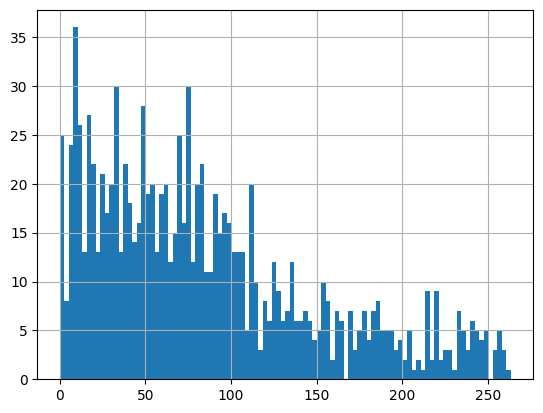

10912
count       733.000000
mean       1302.421555
std       12075.386800
min           1.000000
25%          69.000000
50%         201.000000
75%         498.000000
max      209535.000000
Name: duration_seconds, dtype: float64


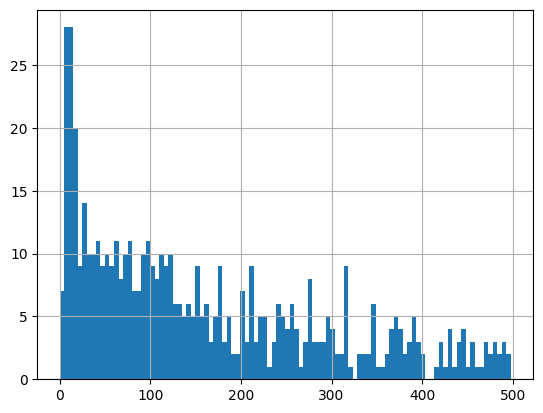

10913
count      2502.000000
mean        419.149880
std        4573.939292
min           1.000000
25%          66.000000
50%         154.000000
75%         354.500000
max      219766.000000
Name: duration_seconds, dtype: float64


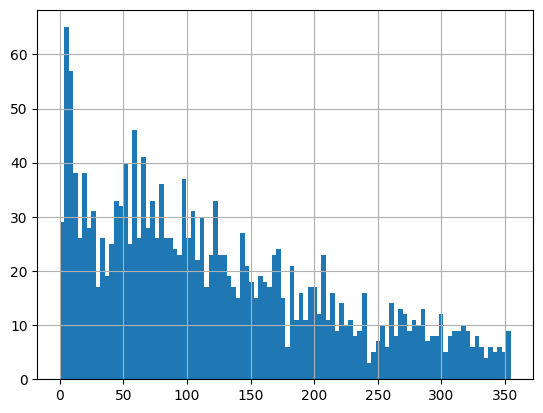

10914
count      150.000000
mean       780.800000
std       4262.950522
min          1.000000
25%        110.000000
50%        180.500000
75%        388.500000
max      50644.000000
Name: duration_seconds, dtype: float64


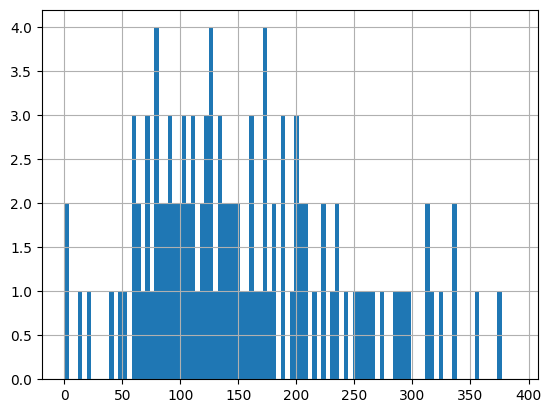

10929
count      1184.000000
mean        683.284628
std        7776.240793
min           1.000000
25%          73.750000
50%         156.500000
75%         444.750000
max      224885.000000
Name: duration_seconds, dtype: float64


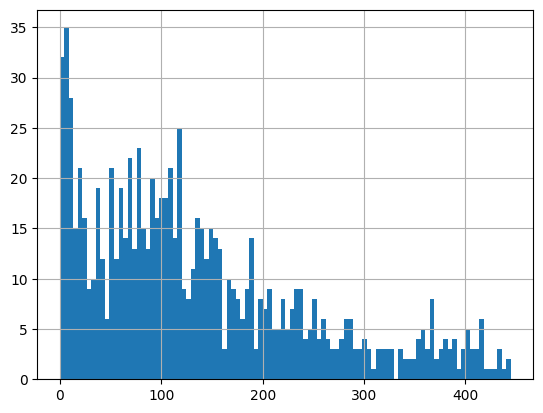

10931
count       512.000000
mean       1011.509766
std        7647.158430
min           1.000000
25%         113.750000
50%         276.000000
75%         578.750000
max      151208.000000
Name: duration_seconds, dtype: float64


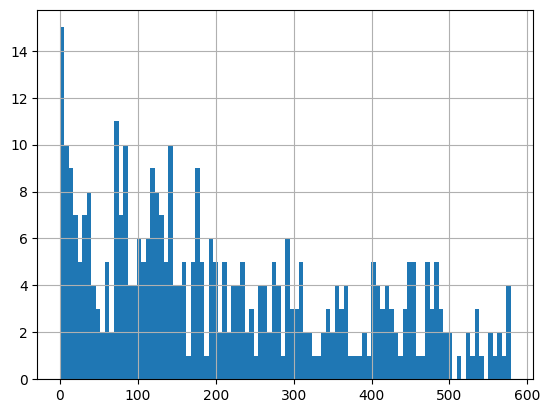

10932
count      1287.000000
mean       2848.913753
std       20327.699079
min           1.000000
25%          70.000000
50%         195.000000
75%         459.000000
max      243739.000000
Name: duration_seconds, dtype: float64


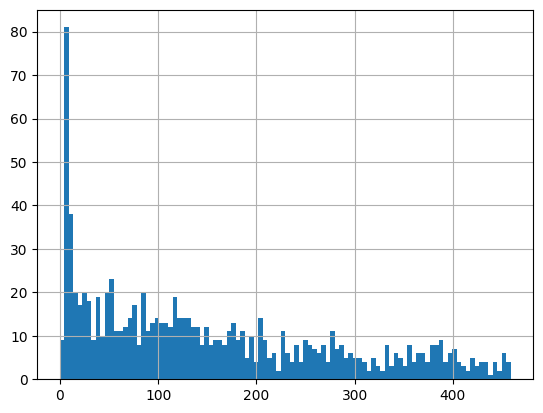

10933
count      653.000000
mean       368.045942
std       1671.736621
min          1.000000
25%         46.000000
50%        124.000000
75%        291.000000
max      39465.000000
Name: duration_seconds, dtype: float64


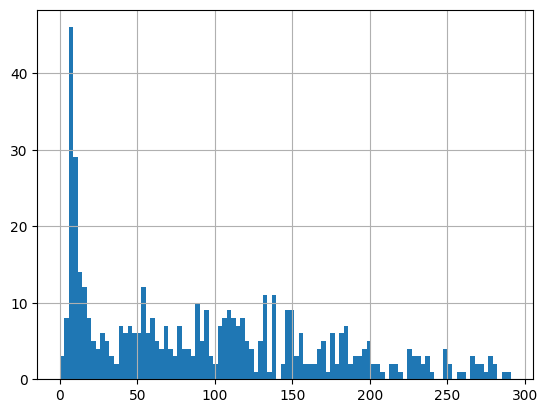

10935
count       349.000000
mean       2774.673352
std       21471.484198
min           1.000000
25%          70.000000
50%         170.000000
75%         390.000000
max      233401.000000
Name: duration_seconds, dtype: float64


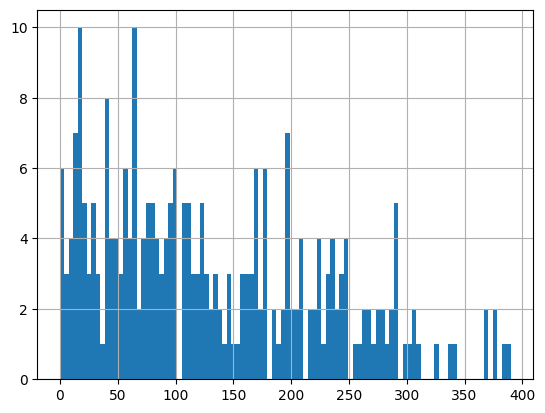

10939
count      874.000000
mean       310.009153
std        522.477322
min          1.000000
25%         78.250000
50%        160.000000
75%        406.500000
max      11389.000000
Name: duration_seconds, dtype: float64


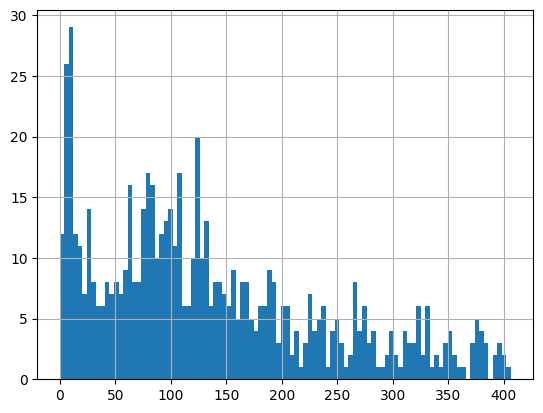

10972
count      1632.000000
mean       1512.829044
std        8808.308918
min           1.000000
25%         201.000000
50%         667.500000
75%        1412.750000
max      221725.000000
Name: duration_seconds, dtype: float64


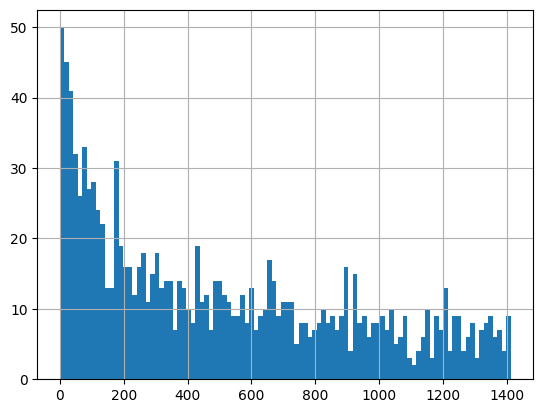

10982
count      1994.000000
mean        439.597292
std        3802.498118
min           1.000000
25%          39.000000
50%          89.000000
75%         227.750000
max      134141.000000
Name: duration_seconds, dtype: float64


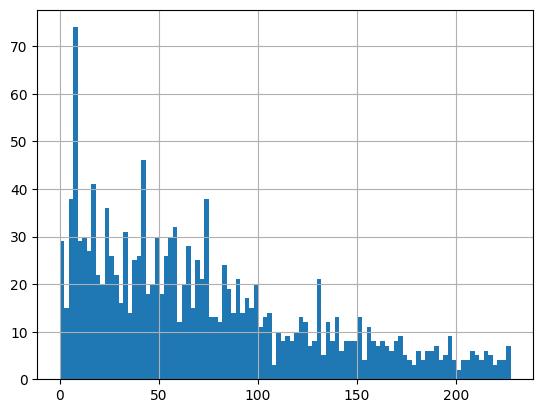

11000
count      1398.000000
mean        970.720315
std        9560.404956
min           1.000000
25%          78.000000
50%         177.000000
75%         363.000000
max      243191.000000
Name: duration_seconds, dtype: float64


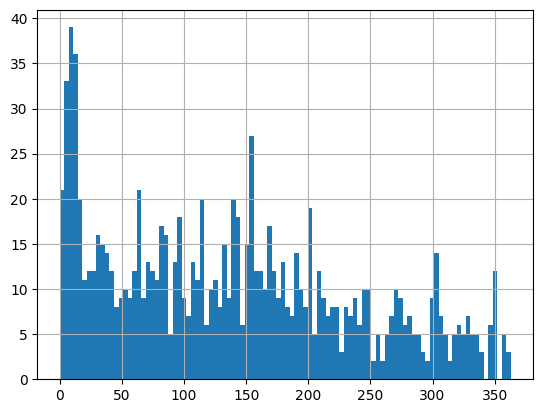

11001
count     82.000000
mean     190.902439
std      200.037874
min        1.000000
25%       68.000000
50%      109.500000
75%      255.250000
max      928.000000
Name: duration_seconds, dtype: float64


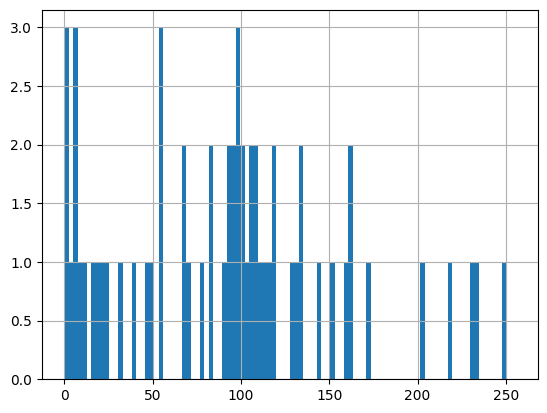

11002
count       746.000000
mean       2547.738606
std       17850.141937
min           1.000000
25%          69.000000
50%         203.000000
75%         573.500000
max      236278.000000
Name: duration_seconds, dtype: float64


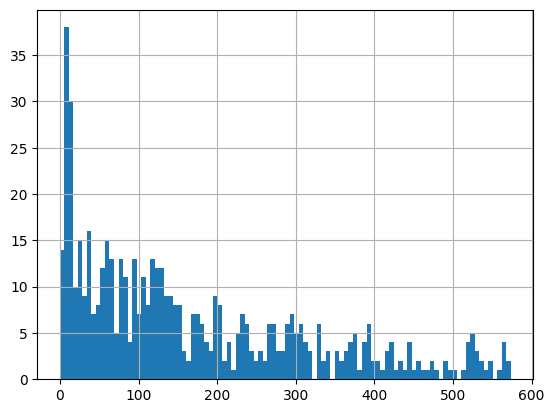

11003
count    1311.000000
mean      196.659039
std       307.311862
min         1.000000
25%        40.000000
50%       106.000000
75%       224.500000
max      6595.000000
Name: duration_seconds, dtype: float64


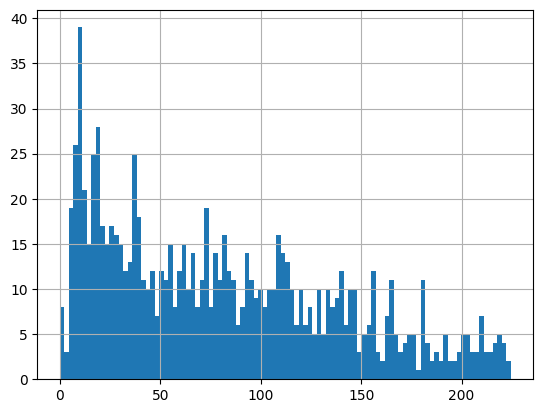

11009
count     1107.000000
mean       453.579042
std       2272.795539
min          1.000000
25%         76.500000
50%        169.000000
75%        416.000000
max      55301.000000
Name: duration_seconds, dtype: float64


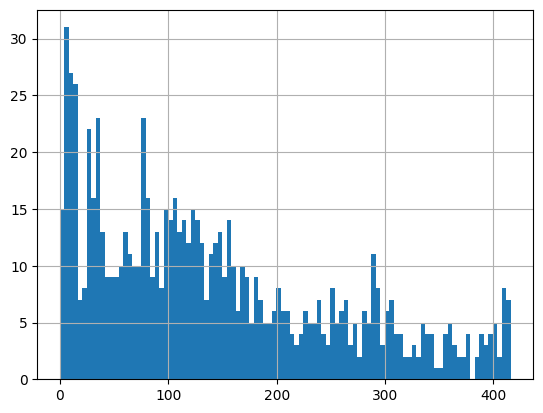

11019
count      768.000000
mean       491.513021
std       1865.128502
min          1.000000
25%         90.000000
50%        214.000000
75%        515.750000
max      48258.000000
Name: duration_seconds, dtype: float64


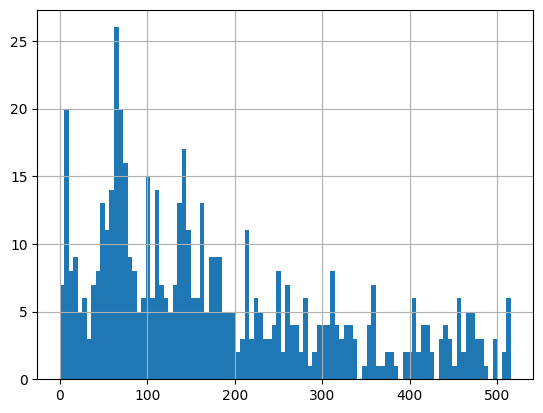

11049
count     1641.000000
mean       152.838513
std       1934.503295
min          1.000000
25%         24.000000
50%         51.000000
75%         98.000000
max      60275.000000
Name: duration_seconds, dtype: float64


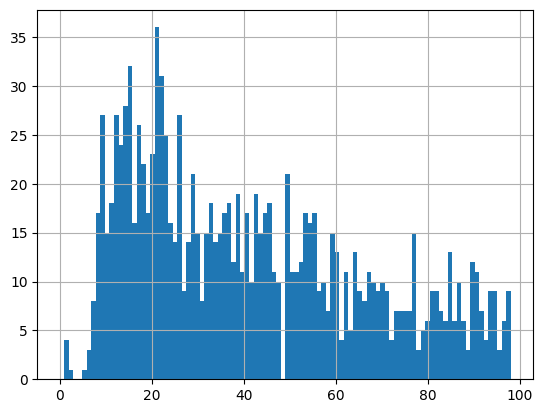

11079
count        16.000000
mean      40160.437500
std       59989.107044
min           9.000000
25%         147.250000
50%       27503.500000
75%       54815.000000
max      238256.000000
Name: duration_seconds, dtype: float64


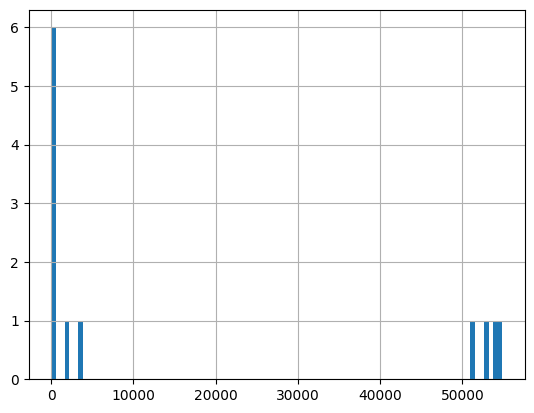

11119
count     2398.000000
mean       293.317348
std       1545.581822
min          1.000000
25%         64.000000
50%        131.000000
75%        247.000000
max      40905.000000
Name: duration_seconds, dtype: float64


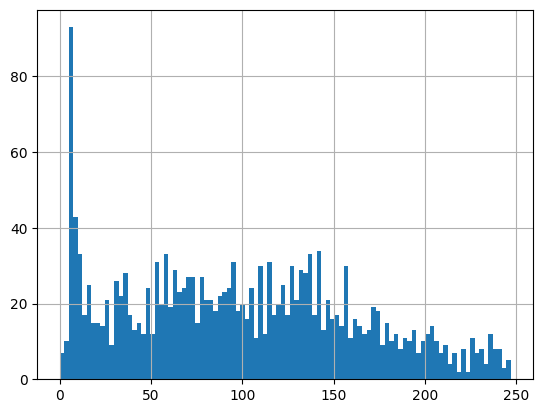

11121
count      1475.000000
mean        765.917288
std        8693.612910
min           1.000000
25%          42.000000
50%         115.000000
75%         324.500000
max      225482.000000
Name: duration_seconds, dtype: float64


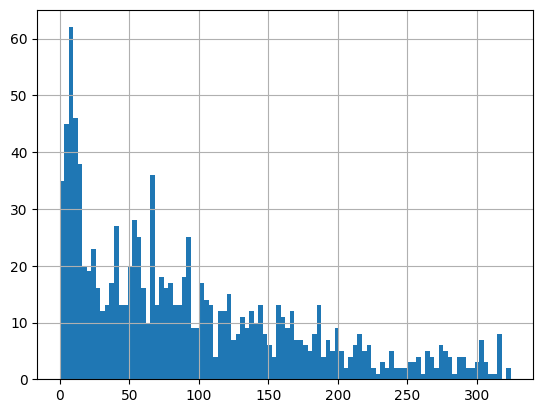

11122
count     1766.000000
mean       362.449604
std       1523.686110
min          1.000000
25%         62.000000
50%        154.000000
75%        388.000000
max      38247.000000
Name: duration_seconds, dtype: float64


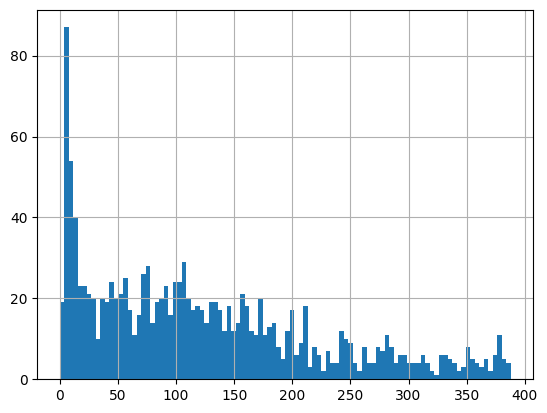

11169
count      2494.000000
mean       1822.849639
std       12183.232174
min           1.000000
25%          93.000000
50%         271.500000
75%         704.000000
max      229404.000000
Name: duration_seconds, dtype: float64


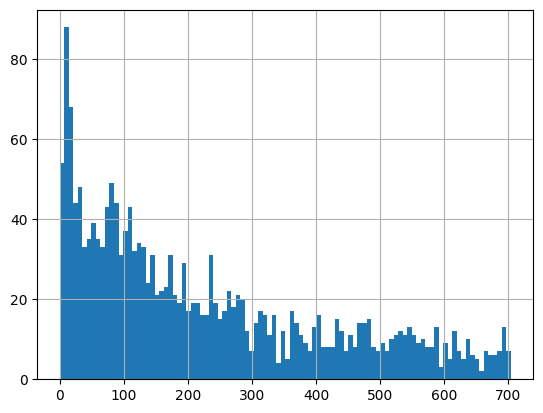

11179
count      1419.000000
mean        601.316420
std        5260.796161
min           1.000000
25%          42.000000
50%         120.000000
75%         336.000000
max      139863.000000
Name: duration_seconds, dtype: float64


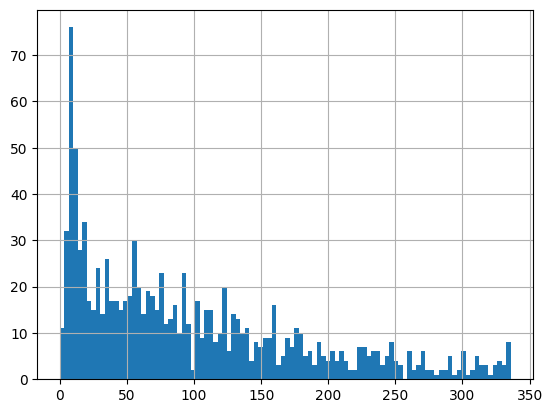

11180
count    2525.000000
mean      193.809505
std       261.859168
min         1.000000
25%        53.000000
50%       106.000000
75%       200.000000
max      2248.000000
Name: duration_seconds, dtype: float64


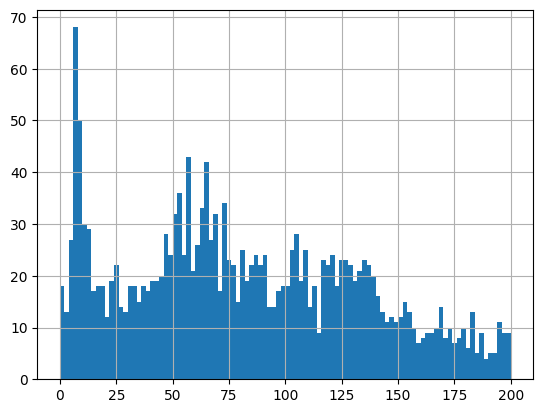

11181
count     2953.000000
mean       249.223163
std       1454.220846
min          1.000000
25%         55.000000
50%        121.000000
75%        245.000000
max      76276.000000
Name: duration_seconds, dtype: float64


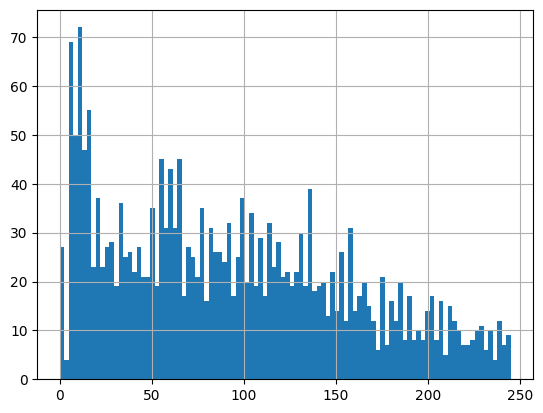

11189
count     2227.000000
mean       383.662326
std       1727.218444
min          1.000000
25%         92.000000
50%        185.000000
75%        452.000000
max      62734.000000
Name: duration_seconds, dtype: float64


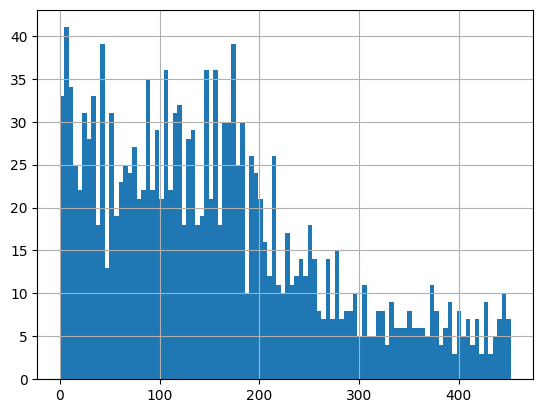

11201
count      2189.000000
mean        552.627227
std        6776.485099
min           1.000000
25%          50.000000
50%         114.000000
75%         255.000000
max      216180.000000
Name: duration_seconds, dtype: float64


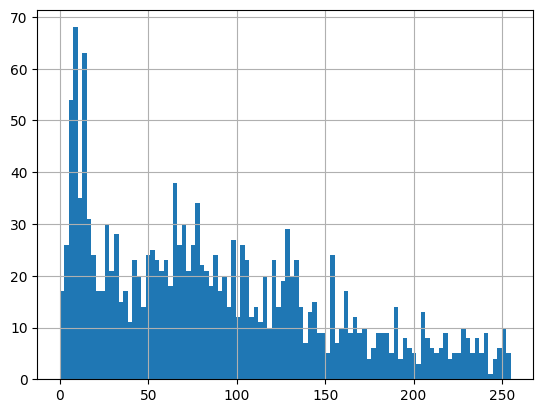

11203
count      2386.000000
mean       1040.822297
std       11343.725134
min           1.000000
25%          67.000000
50%         129.000000
75%         266.000000
max      220877.000000
Name: duration_seconds, dtype: float64


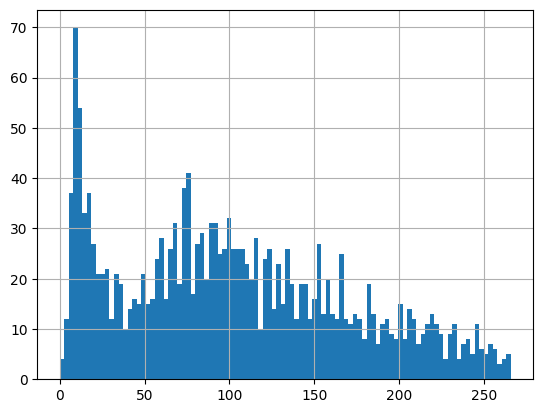

11254
count        2.0000
mean     34006.0000
std      48039.4205
min         37.0000
25%      17021.5000
50%      34006.0000
75%      50990.5000
max      67975.0000
Name: duration_seconds, dtype: float64


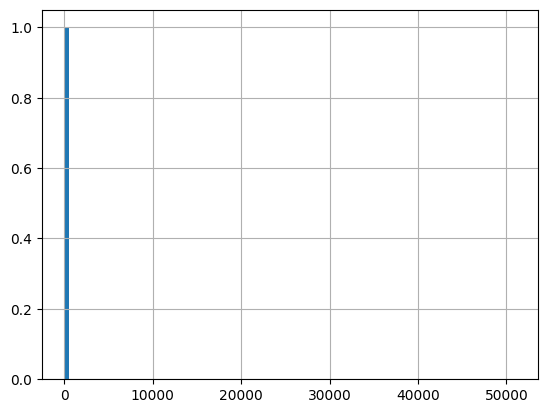

11259
count     1315.000000
mean       213.506464
std       2949.065786
min          1.000000
25%         13.000000
50%         18.000000
75%         40.000000
max      67956.000000
Name: duration_seconds, dtype: float64


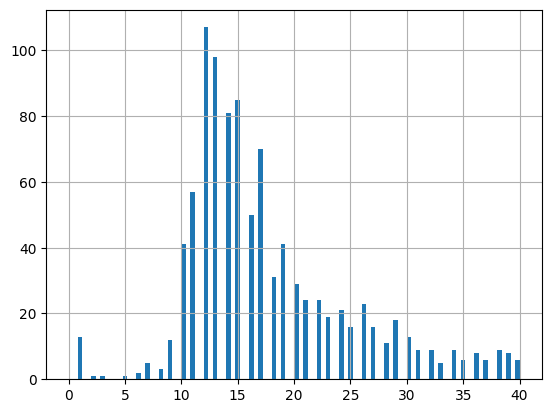

11269
count        3.000000
mean     58758.333333
std        194.425650
min      58543.000000
25%      58677.000000
50%      58811.000000
75%      58866.000000
max      58921.000000
Name: duration_seconds, dtype: float64


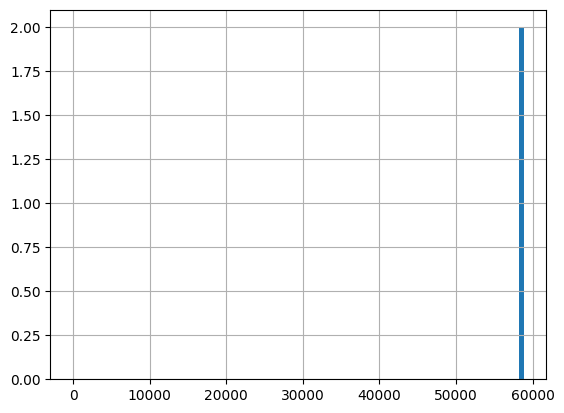

11289
count       735.000000
mean       1987.431293
std        8676.800345
min           1.000000
25%         210.500000
50%        1023.000000
75%        2407.500000
max      222687.000000
Name: duration_seconds, dtype: float64


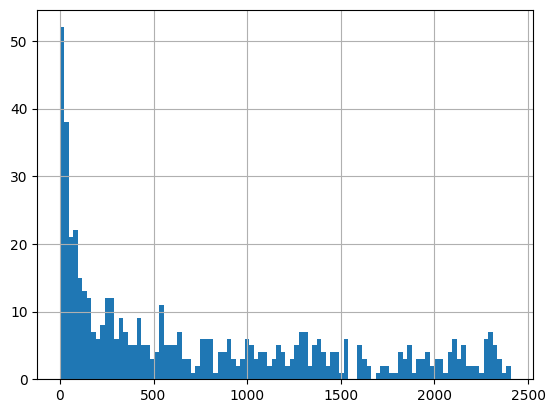

11299
count      356.000000
mean       897.539326
std       5174.977312
min          5.000000
25%         87.000000
50%        147.000000
75%        269.250000
max      54122.000000
Name: duration_seconds, dtype: float64


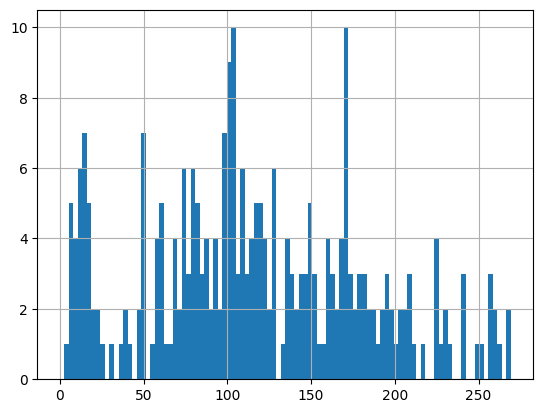

11300
count     355.000000
mean      280.174648
std       343.113656
min         5.000000
25%        92.500000
50%       166.000000
75%       321.500000
max      3360.000000
Name: duration_seconds, dtype: float64


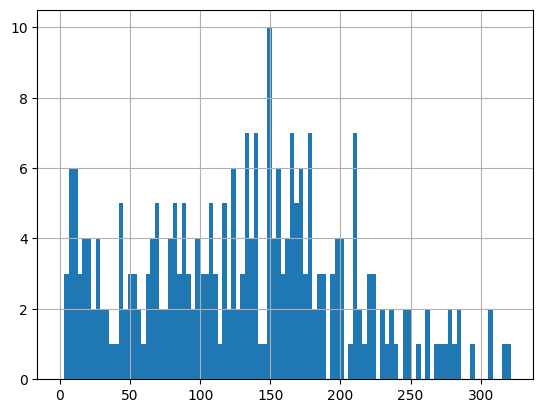

11302
count      396.000000
mean       302.982323
std       1070.256745
min          1.000000
25%         25.500000
50%        113.500000
75%        257.750000
max      20077.000000
Name: duration_seconds, dtype: float64


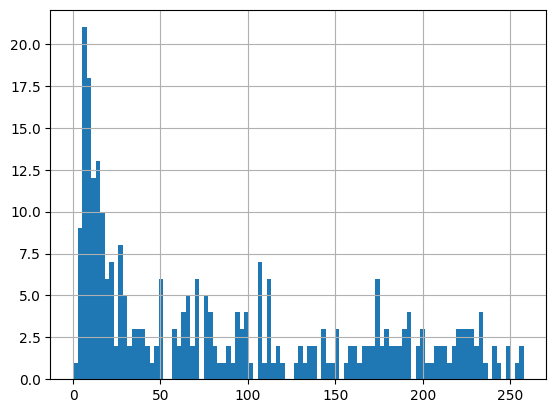

11304
count       18.000000
mean      7675.000000
std      21633.450063
min          1.000000
25%         11.000000
50%         23.500000
75%        269.250000
max      76417.000000
Name: duration_seconds, dtype: float64


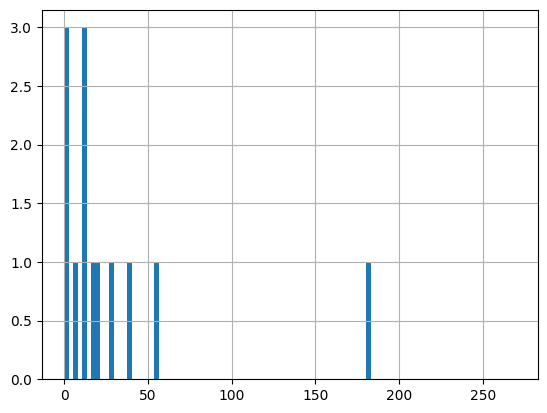

11309
count       309.000000
mean        943.708738
std       11860.584784
min           5.000000
25%          37.000000
50%         155.000000
75%         297.000000
max      208579.000000
Name: duration_seconds, dtype: float64


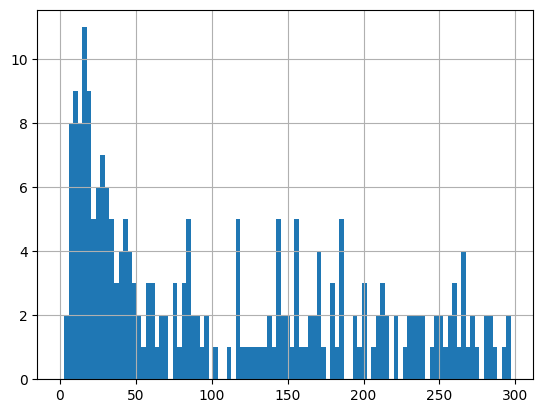

11319
count      284.000000
mean       458.855634
std       3400.171717
min          5.000000
25%         62.000000
50%        129.000000
75%        312.500000
max      57189.000000
Name: duration_seconds, dtype: float64


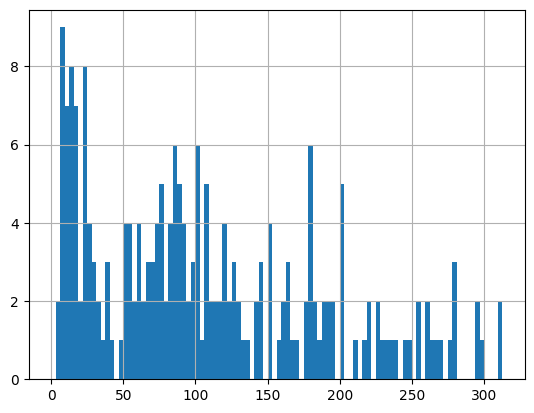

11339
count      17.000000
mean      842.941176
std       697.156051
min         3.000000
25%       354.000000
50%       788.000000
75%      1153.000000
max      2428.000000
Name: duration_seconds, dtype: float64


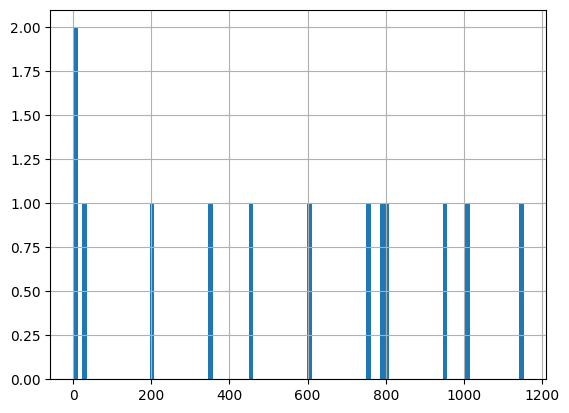

nan
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: duration_seconds, dtype: float64


In [20]:
for resource in pandas.unique(start_end_event_log['org:resource']):
    print(resource)
    resource_log = start_end_event_log[start_end_event_log['org:resource'] == resource]
    description = resource_log['duration_seconds'].describe()
    print(description)
    if not pandas.isna(resource):
        resource_log['duration_seconds'].hist(bins=100, range=(0,description['75%']))
        plt.show()

10138 , W_Valideren aanvraag : 1706.0
count     1706.000000
mean       908.540445
std       1575.160239
min          1.000000
25%        277.250000
50%        693.500000
75%       1198.250000
max      56763.000000
Name: duration_seconds, dtype: float64


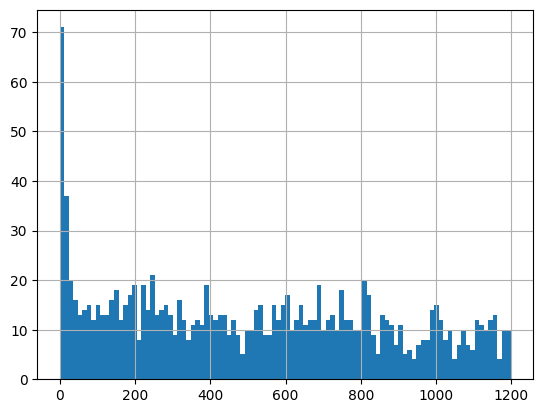

10609 , W_Valideren aanvraag : 1679.0
count      1679.000000
mean       1274.394282
std        4580.659871
min           1.000000
25%         327.500000
50%         833.000000
75%        1499.500000
max      148971.000000
Name: duration_seconds, dtype: float64


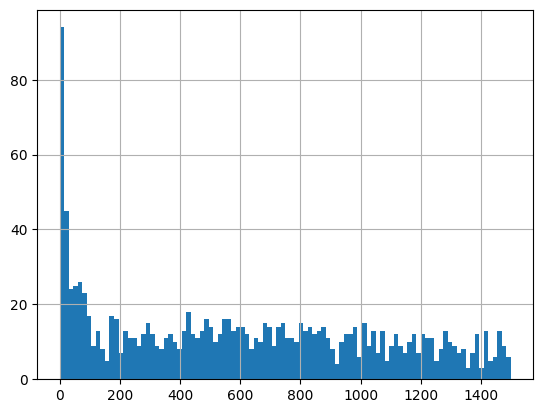

10972 , W_Valideren aanvraag : 1413.0
count      1413.000000
mean       1466.422505
std        7125.855029
min           1.000000
25%         295.000000
50%         809.000000
75%        1525.000000
max      221725.000000
Name: duration_seconds, dtype: float64


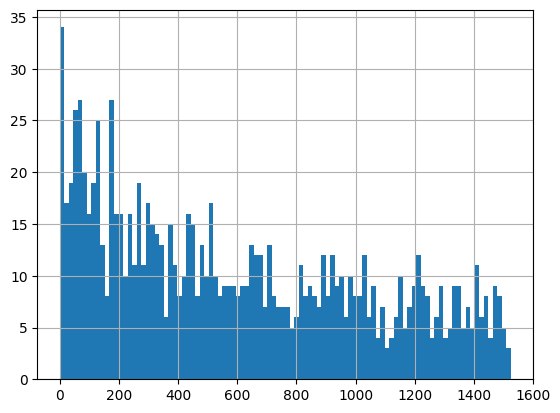

10861 , W_Completeren aanvraag : 1235.0
count     1235.000000
mean       240.784615
std        685.706506
min          1.000000
25%         51.000000
50%         98.000000
75%        290.000000
max      16169.000000
Name: duration_seconds, dtype: float64


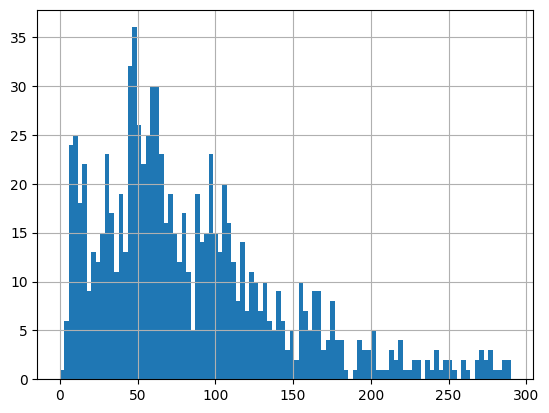

11201 , W_Completeren aanvraag : 1195.0
count    1195.000000
mean      272.829289
std       609.585154
min         1.000000
25%        50.000000
50%       121.000000
75%       337.000000
max      9568.000000
Name: duration_seconds, dtype: float64


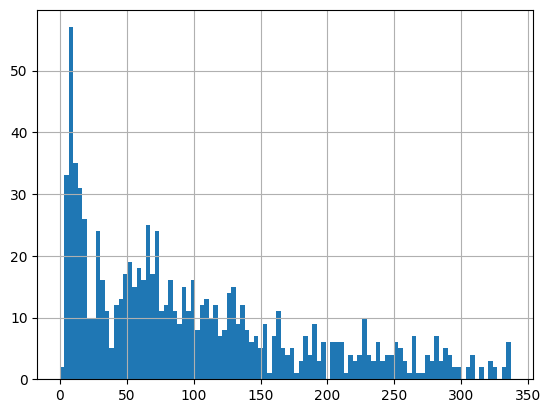

11180 , W_Nabellen offertes : 1192.0
count    1192.000000
mean      125.867450
std       137.220535
min         1.000000
25%        50.000000
50%        95.000000
75%       149.000000
max      1877.000000
Name: duration_seconds, dtype: float64


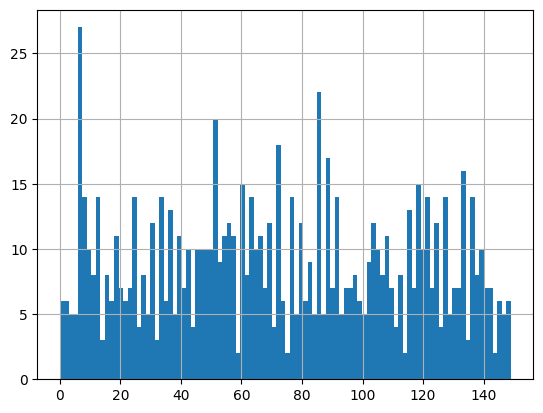

11181 , W_Completeren aanvraag : 1182.0
count     1182.000000
mean       304.042301
std       2243.963438
min          1.000000
25%         40.000000
50%        108.000000
75%        302.000000
max      76276.000000
Name: duration_seconds, dtype: float64


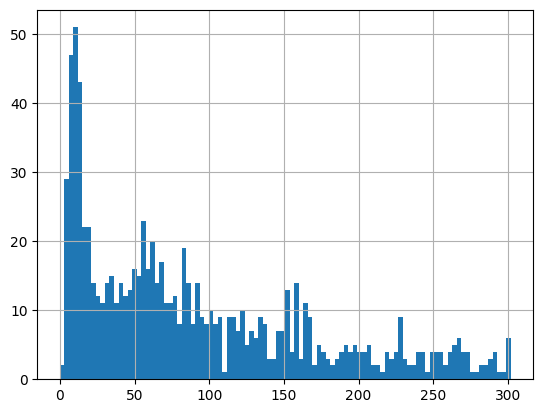

11203 , W_Completeren aanvraag : 1181.0
count      1181.000000
mean        768.790855
std        9234.597201
min           5.000000
25%          54.000000
50%         118.000000
75%         328.000000
max      217894.000000
Name: duration_seconds, dtype: float64


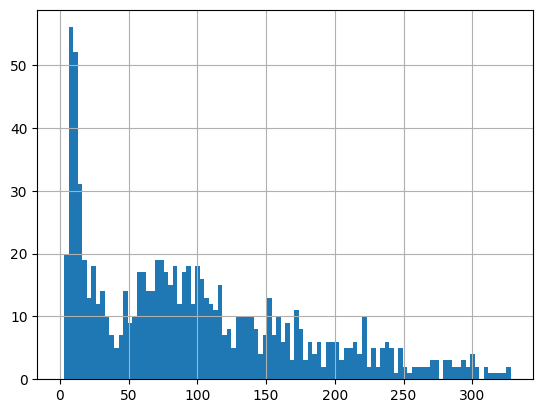

11181 , W_Nabellen offertes : 1172.0
count    1172.000000
mean      159.133106
std       406.168401
min         1.000000
25%        61.000000
50%       113.000000
75%       176.250000
max      9963.000000
Name: duration_seconds, dtype: float64


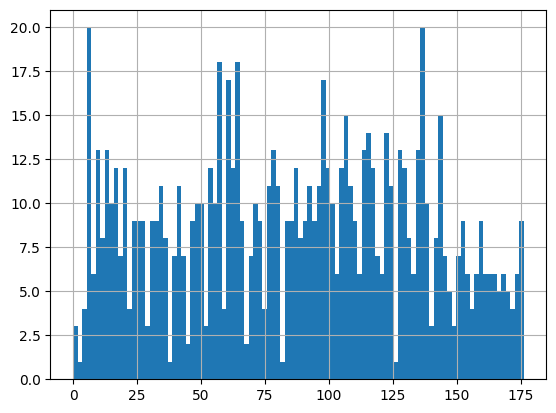

11119 , W_Nabellen offertes : 1142.0
count     1142.000000
mean       206.267951
std       1040.064896
min          1.000000
25%         71.000000
50%        131.000000
75%        203.750000
max      34563.000000
Name: duration_seconds, dtype: float64


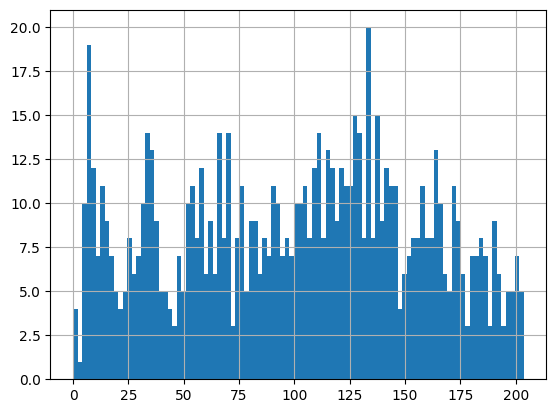

11180 , W_Completeren aanvraag : 1070.0
count    1070.000000
mean      241.127103
std       314.431024
min         1.000000
25%        57.000000
50%       109.500000
75%       280.500000
max      2248.000000
Name: duration_seconds, dtype: float64


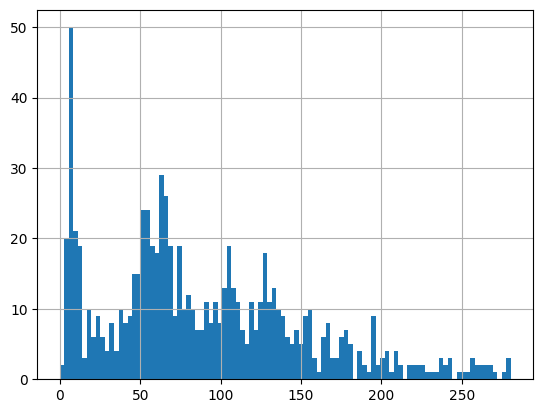

11169 , W_Completeren aanvraag : 1069.0
count      1069.000000
mean       2004.701590
std       11741.849804
min           1.000000
25%         129.000000
50%         407.000000
75%         776.000000
max      229404.000000
Name: duration_seconds, dtype: float64


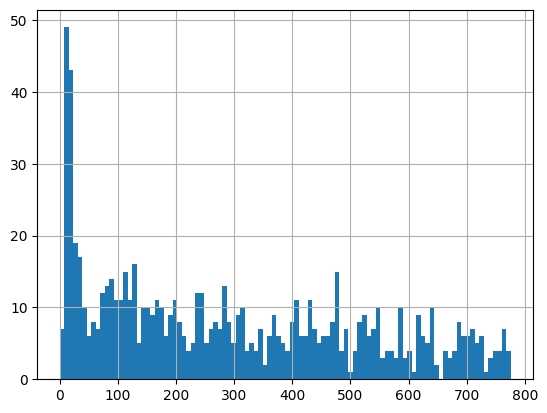

10909 , W_Nabellen offertes : 1013.0
count      1013.000000
mean        591.524186
std        7366.554382
min           1.000000
25%          58.000000
50%         102.000000
75%         180.000000
max      208987.000000
Name: duration_seconds, dtype: float64


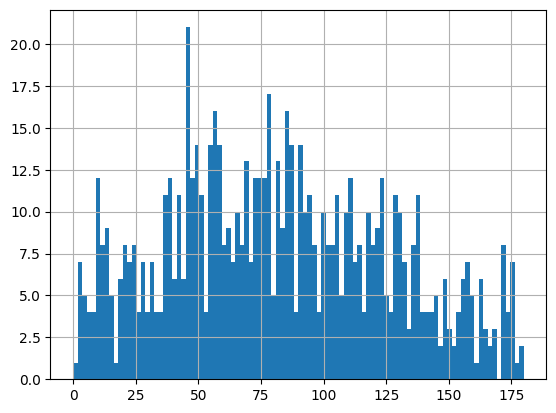

11203 , W_Nabellen offertes : 1004.0
count      1004.000000
mean       1232.443227
std       13205.661338
min           5.000000
25%          78.750000
50%         133.000000
75%         234.000000
max      220877.000000
Name: duration_seconds, dtype: float64


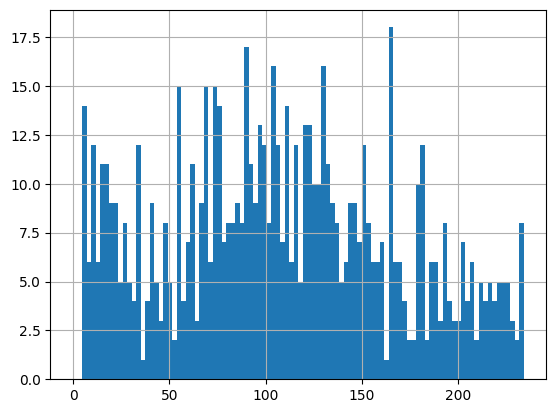

10629 , W_Valideren aanvraag : 992.0
count      992.000000
mean       990.551411
std       2696.623972
min          1.000000
25%        271.000000
50%        702.000000
75%       1281.250000
max      57542.000000
Name: duration_seconds, dtype: float64


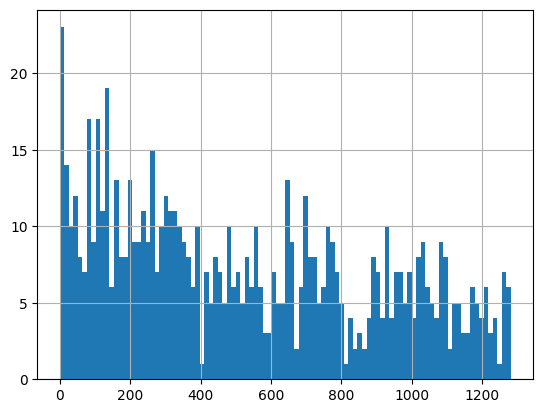

10809 , W_Valideren aanvraag : 988.0
count      988.000000
mean       999.564777
std       1946.005306
min          1.000000
25%        168.750000
50%        733.500000
75%       1483.250000
max      55603.000000
Name: duration_seconds, dtype: float64


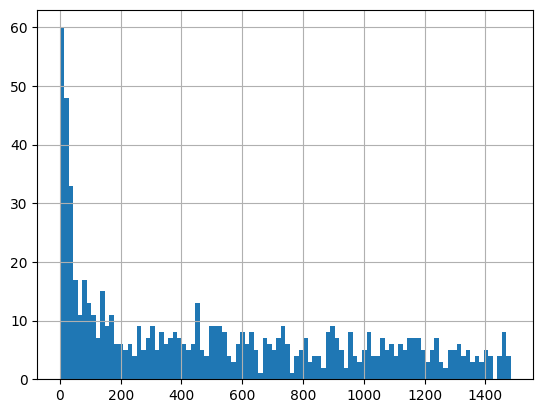

11189 , W_Completeren aanvraag : 957.0
count     957.000000
mean      444.300940
std       491.933772
min         1.000000
25%       147.000000
50%       301.000000
75%       648.000000
max      7058.000000
Name: duration_seconds, dtype: float64


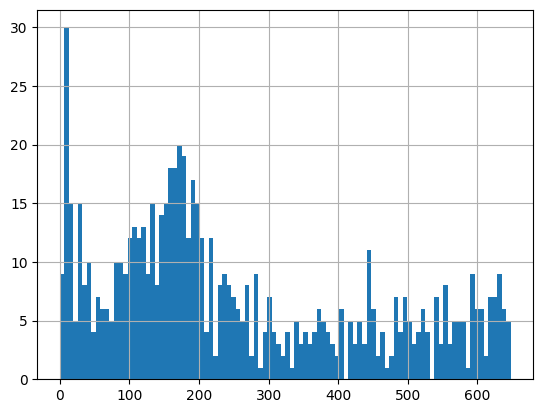

11179 , W_Completeren aanvraag : 954.0
count      954.000000
mean       638.641509
std       4547.118898
min          1.000000
25%         40.250000
50%        128.500000
75%        433.000000
max      66125.000000
Name: duration_seconds, dtype: float64


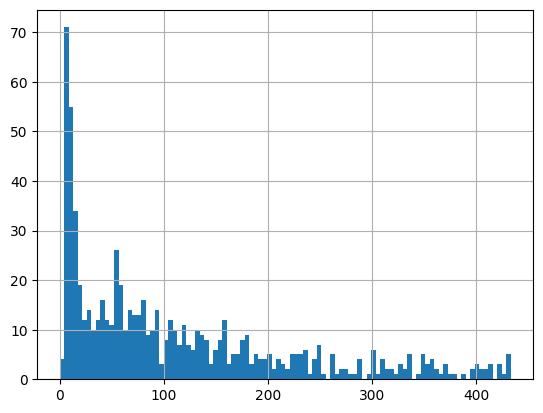

11119 , W_Completeren aanvraag : 948.0
count      948.000000
mean       392.176160
std       2155.664913
min          1.000000
25%         55.000000
50%        131.000000
75%        451.000000
max      40905.000000
Name: duration_seconds, dtype: float64


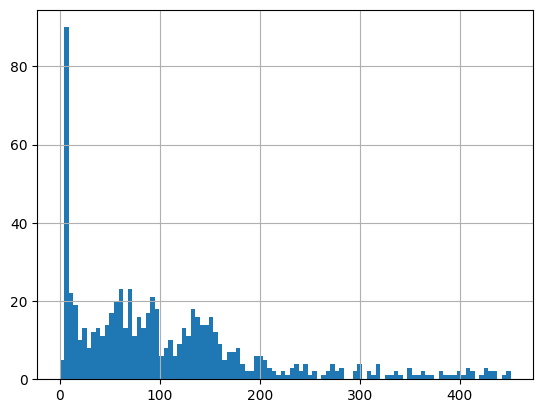

10861 , W_Nabellen offertes : 912.0
count      912.000000
mean       245.070175
std       1754.298934
min          1.000000
25%         53.000000
50%         98.000000
75%        155.000000
max      48627.000000
Name: duration_seconds, dtype: float64


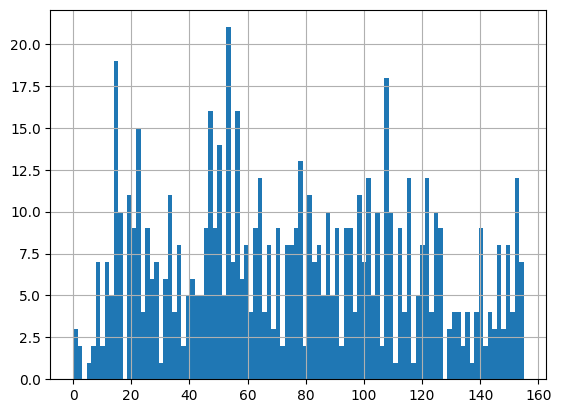

11259 , W_Nabellen offertes : 893.0
count      893.00000
mean       102.44009
std       2273.73785
min          1.00000
25%         13.00000
50%         16.00000
75%         23.00000
max      67956.00000
Name: duration_seconds, dtype: float64


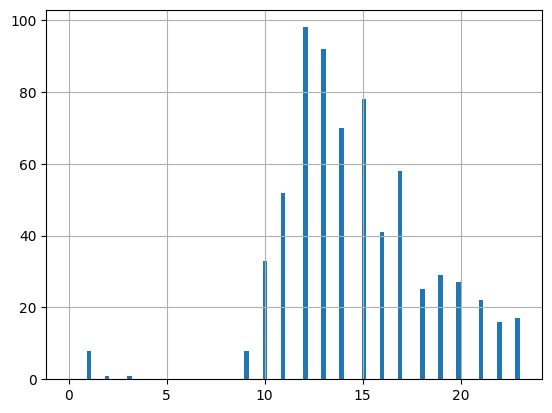

10913 , W_Nabellen offertes : 880.0
count     880.000000
mean      255.414773
std       562.249557
min         1.000000
25%        71.750000
50%       147.000000
75%       276.750000
max      9733.000000
Name: duration_seconds, dtype: float64


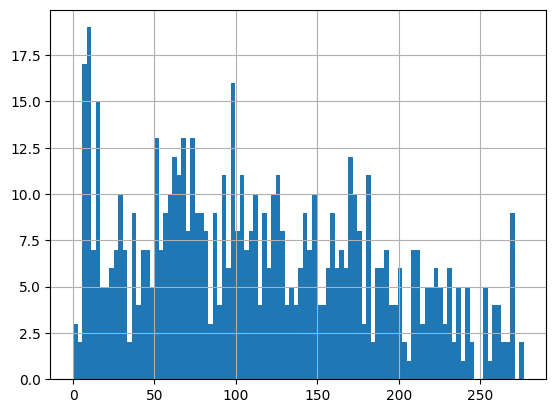

11049 , W_Nabellen offertes : 875.0
count      875.000000
mean       207.588571
std       2642.781988
min          1.000000
25%         26.000000
50%         50.000000
75%         98.000000
max      60275.000000
Name: duration_seconds, dtype: float64


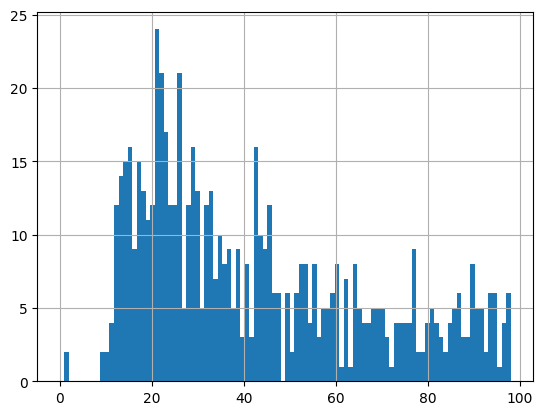

11201 , W_Nabellen offertes : 836.0
count       836.000000
mean        715.147129
std       10375.513541
min           1.000000
25%          48.000000
50%          99.000000
75%         183.000000
max      216180.000000
Name: duration_seconds, dtype: float64


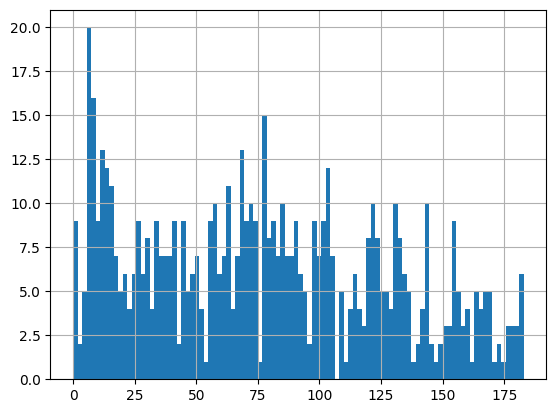

10899 , W_Nabellen offertes : 794.0
count      794.000000
mean       133.729219
std       2009.988367
min          2.000000
25%         11.000000
50%         15.000000
75%         32.000000
max      50548.000000
Name: duration_seconds, dtype: float64


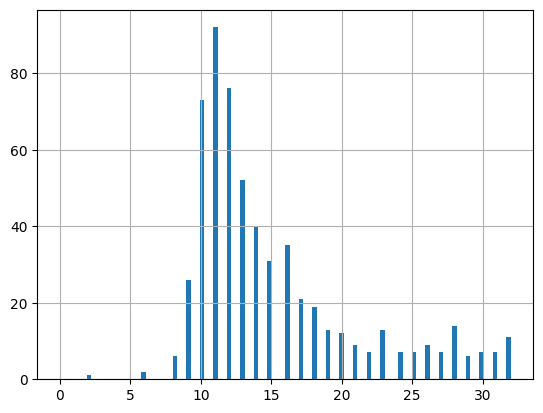

11189 , W_Nabellen offertes : 783.0
count      783.000000
mean       349.851852
std       2832.013001
min          1.000000
25%         69.000000
50%        142.000000
75%        237.000000
max      62734.000000
Name: duration_seconds, dtype: float64


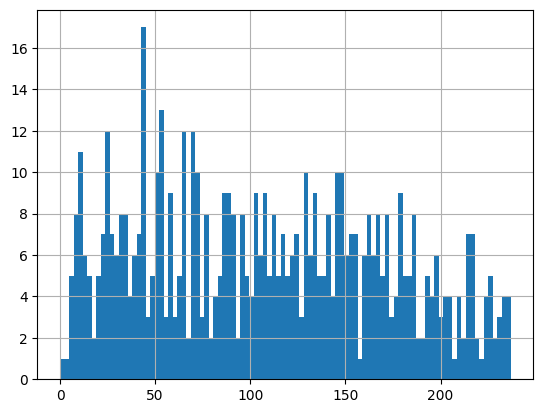

10982 , W_Completeren aanvraag : 743.0
count     743.000000
mean      306.267833
std       632.319810
min         3.000000
25%        42.000000
50%       105.000000
75%       415.000000
max      9926.000000
Name: duration_seconds, dtype: float64


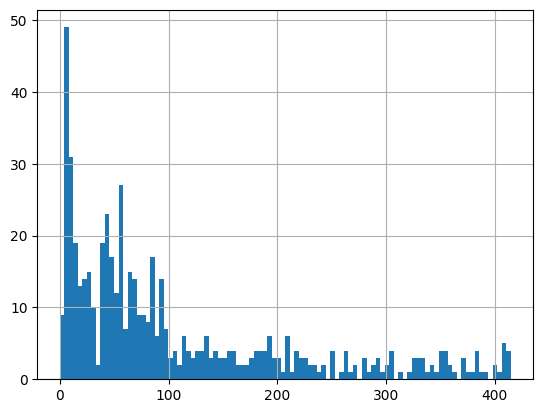

11122 , W_Completeren aanvraag : 740.0
count      740.000000
mean       449.435135
std       1933.291648
min          3.000000
25%         74.750000
50%        207.500000
75%        479.000000
max      38247.000000
Name: duration_seconds, dtype: float64


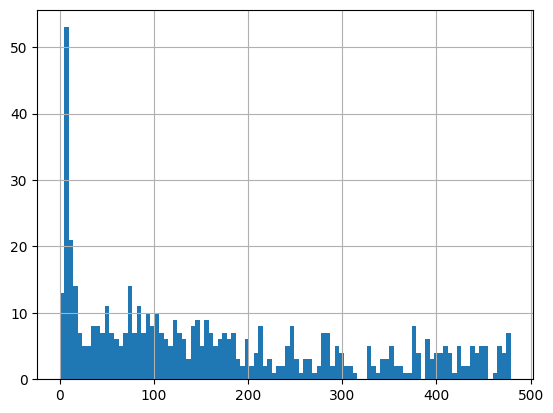

10913 , W_Completeren aanvraag : 712.0
count     712.000000
mean      348.765449
std       435.748956
min         3.000000
25%        85.000000
50%       209.500000
75%       478.500000
max      4534.000000
Name: duration_seconds, dtype: float64


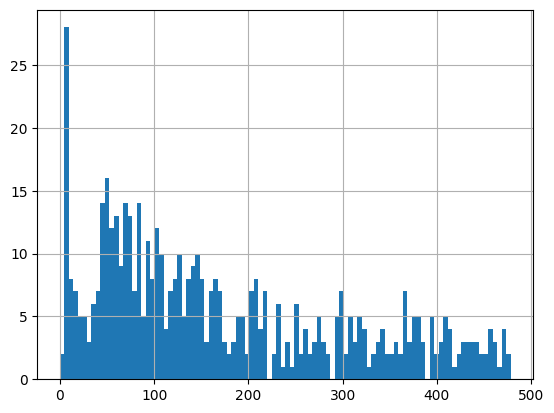

10913 , W_Nabellen incomplete dossiers : 709.0
count       709.000000
mean        728.703808
std        8449.848215
min           1.000000
25%          51.000000
50%         172.000000
75%         392.000000
max      219766.000000
Name: duration_seconds, dtype: float64


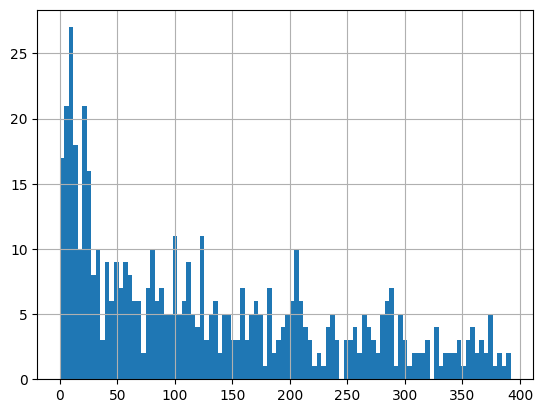

11049 , W_Nabellen incomplete dossiers : 708.0
count     708.000000
mean       88.487288
std       185.157179
min         1.000000
25%        22.000000
50%        53.000000
75%        95.250000
max      3743.000000
Name: duration_seconds, dtype: float64


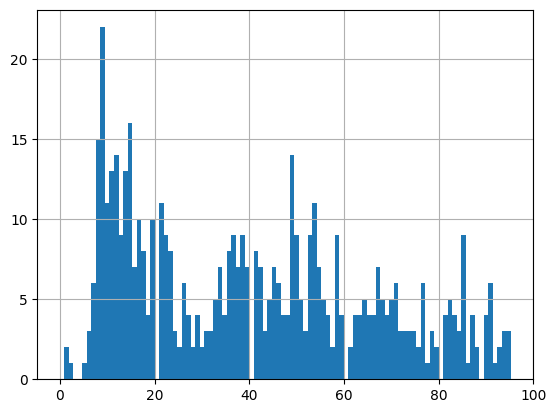

10909 , W_Completeren aanvraag : 693.0
count      693.000000
mean       921.525253
std       6366.477626
min          4.000000
25%         58.000000
50%        119.000000
75%        381.000000
max      61298.000000
Name: duration_seconds, dtype: float64


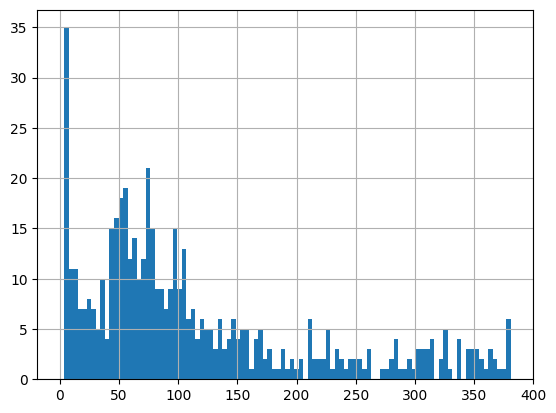

10881 , W_Nabellen offertes : 690.0
count      690.000000
mean       294.802899
std       2259.785029
min          5.000000
25%         53.250000
50%        101.000000
75%        168.000000
max      34385.000000
Name: duration_seconds, dtype: float64


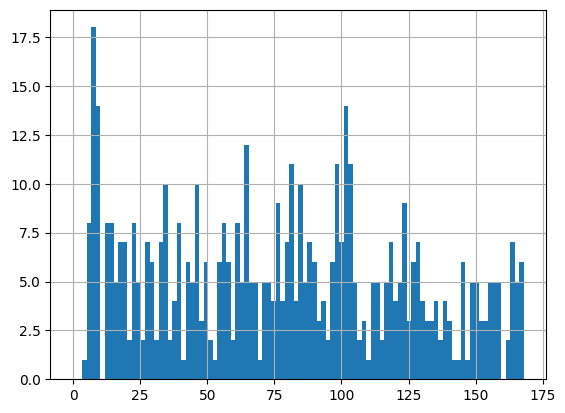

11289 , W_Valideren aanvraag : 661.0
count       661.000000
mean       2198.655068
std        9125.914899
min           1.000000
25%         343.000000
50%        1268.000000
75%        2620.000000
max      222687.000000
Name: duration_seconds, dtype: float64


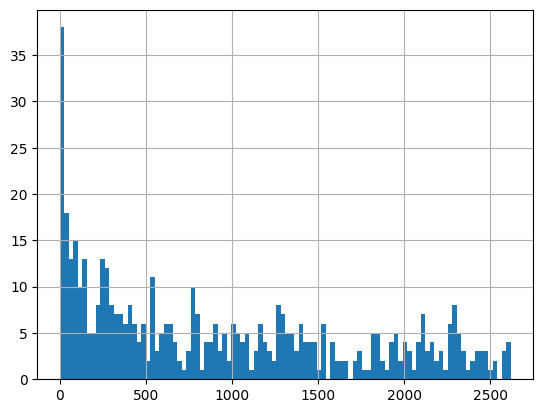

11169 , W_Nabellen incomplete dossiers : 660.0
count       660.000000
mean       1866.931818
std       12982.886686
min           1.000000
25%         105.500000
50%         308.000000
75%         800.500000
max      226055.000000
Name: duration_seconds, dtype: float64


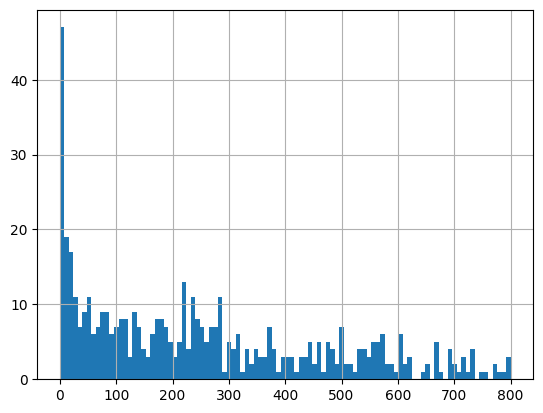

11121 , W_Completeren aanvraag : 640.0
count      640.000000
mean       511.975000
std       3386.485265
min          4.000000
25%         43.750000
50%        106.500000
75%        375.500000
max      62168.000000
Name: duration_seconds, dtype: float64


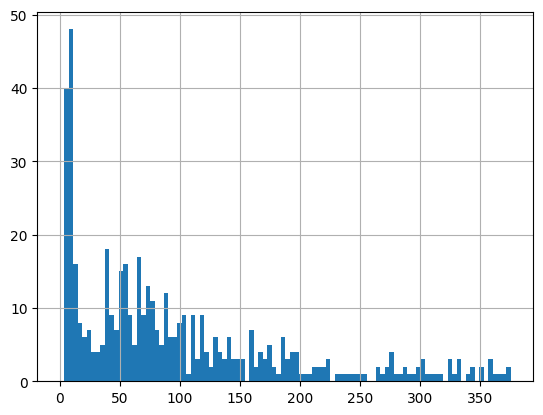

11122 , W_Nabellen offertes : 609.0
count      609.000000
mean       281.057471
std       1420.386832
min          1.000000
25%         60.000000
50%        124.000000
75%        244.000000
max      33354.000000
Name: duration_seconds, dtype: float64


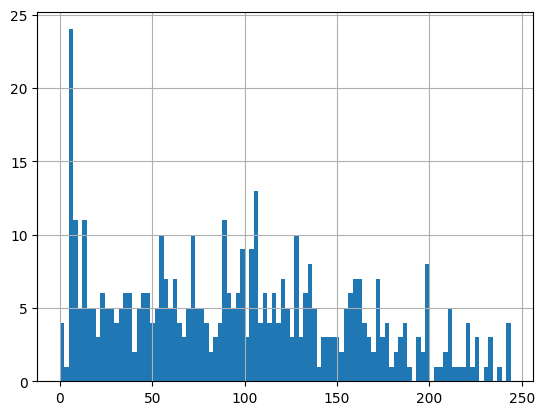

10982 , W_Nabellen offertes : 601.0
count      601.000000
mean       455.094842
std       3325.032706
min          1.000000
25%         34.000000
50%         77.000000
75%        155.000000
max      46557.000000
Name: duration_seconds, dtype: float64


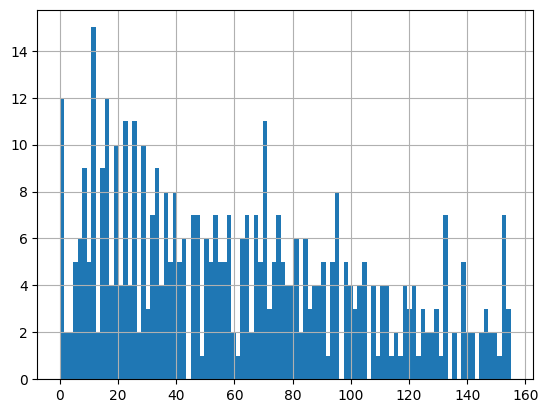

11019 , W_Completeren aanvraag : 580.0
count      580.000000
mean       421.639655
std        694.439586
min          1.000000
25%         89.250000
50%        218.000000
75%        525.750000
max      10202.000000
Name: duration_seconds, dtype: float64


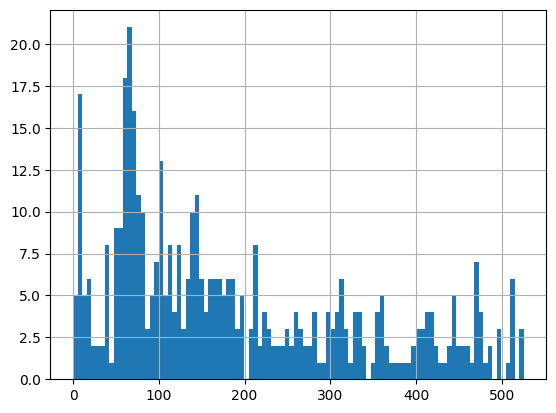

10910 , W_Completeren aanvraag : 556.0
count       556.000000
mean        865.960432
std       10269.896997
min           3.000000
25%          77.500000
50%         163.000000
75%         406.250000
max      239183.000000
Name: duration_seconds, dtype: float64


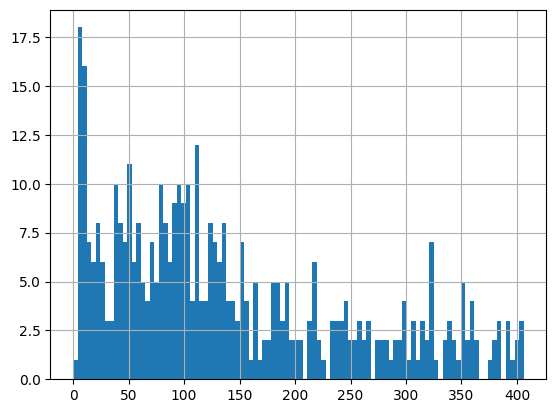

10932 , W_Completeren aanvraag : 536.0
count       536.000000
mean       1012.483209
std        7618.119452
min           5.000000
25%          86.000000
50%         276.500000
75%         483.500000
max      148817.000000
Name: duration_seconds, dtype: float64


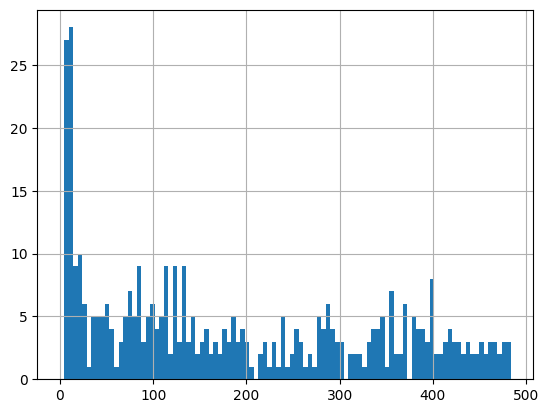

11003 , W_Completeren aanvraag : 530.0
count     530.000000
mean      232.064151
std       290.254760
min         4.000000
25%        40.000000
50%       113.000000
75%       333.250000
max      2633.000000
Name: duration_seconds, dtype: float64


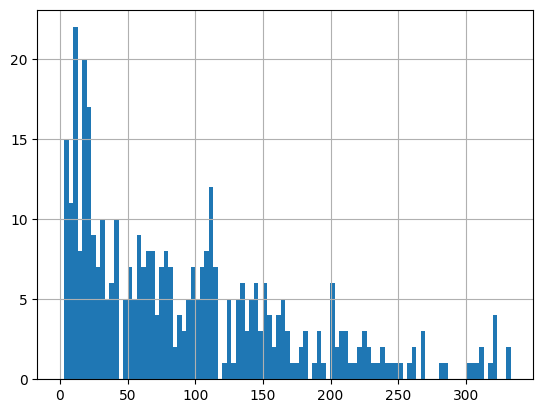

11169 , W_Afhandelen leads : 510.0
count       510.000000
mean       1387.976471
std       10659.194709
min           2.000000
25%          70.250000
50%         127.000000
75%         387.500000
max      223506.000000
Name: duration_seconds, dtype: float64


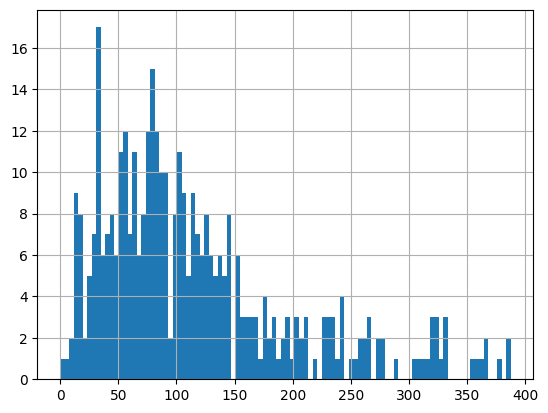

11181 , W_Nabellen incomplete dossiers : 506.0
count     506.000000
mean      355.924901
std       401.386442
min         1.000000
25%        97.500000
50%       216.000000
75%       482.000000
max      2633.000000
Name: duration_seconds, dtype: float64


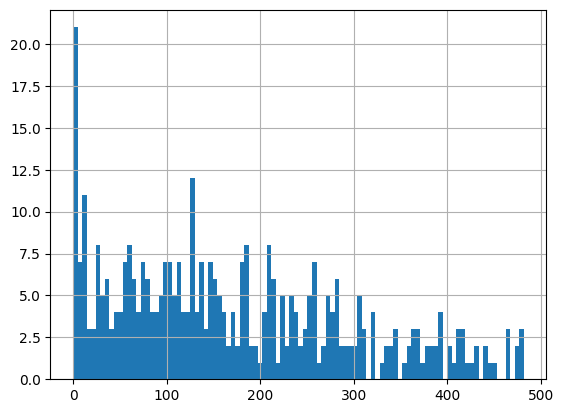

10863 , W_Completeren aanvraag : 477.0
count     477.000000
mean      322.044025
std       573.168519
min         1.000000
25%        54.000000
50%       123.000000
75%       421.000000
max      8450.000000
Name: duration_seconds, dtype: float64


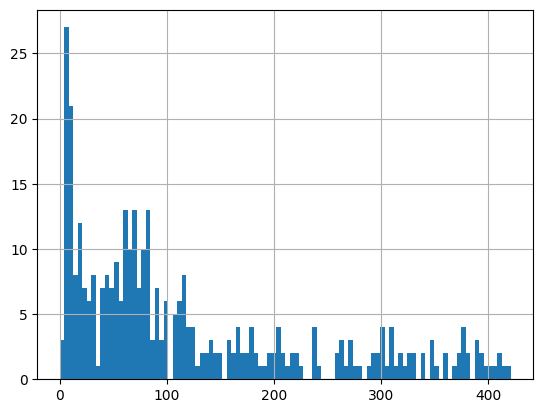

10889 , W_Nabellen offertes : 471.0
count       471.000000
mean       1237.878981
std        8599.441533
min           1.000000
25%          76.500000
50%         150.000000
75%         247.000000
max      138996.000000
Name: duration_seconds, dtype: float64


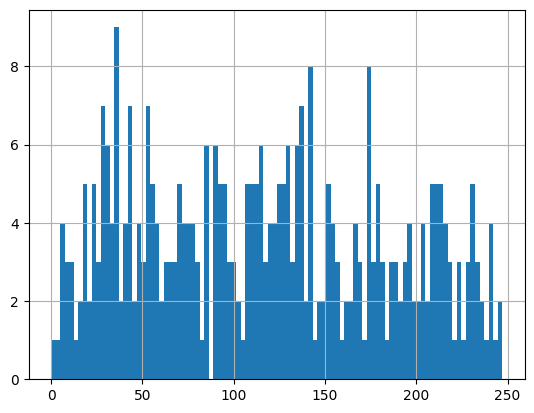

11003 , W_Nabellen offertes : 468.0
count     468.000000
mean      173.369658
std       346.605006
min         1.000000
25%        39.000000
50%       111.000000
75%       203.250000
max      6595.000000
Name: duration_seconds, dtype: float64


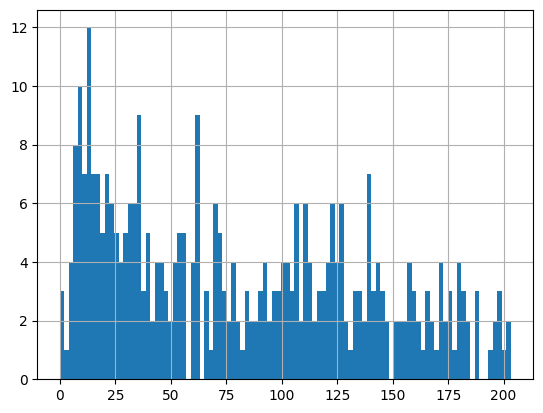

11000 , W_Completeren aanvraag : 452.0
count      452.000000
mean       363.827434
std        709.607606
min          1.000000
25%         95.750000
50%        211.000000
75%        520.000000
max      12958.000000
Name: duration_seconds, dtype: float64


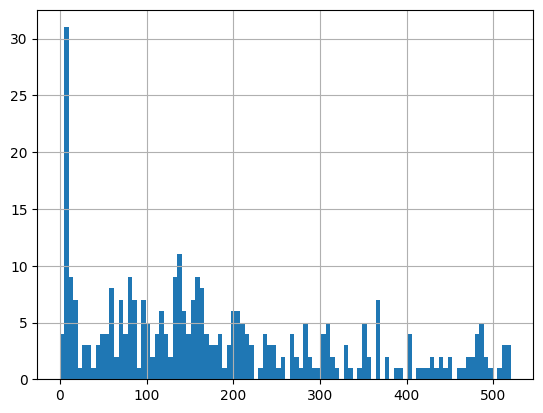

10910 , W_Afhandelen leads : 445.0
count      445.000000
mean      1310.107865
std       7348.100333
min          1.000000
25%         54.000000
50%         82.000000
75%        180.000000
max      64327.000000
Name: duration_seconds, dtype: float64


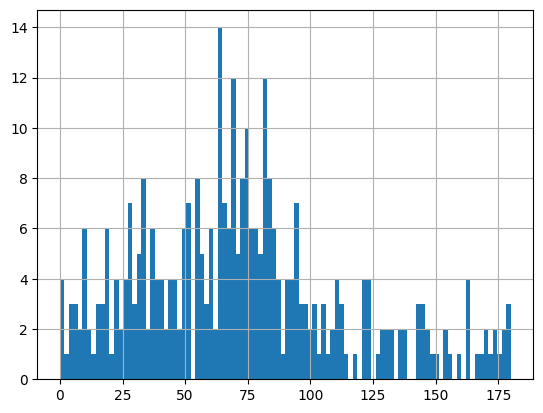

11000 , W_Nabellen offertes : 437.0
count       437.000000
mean       1706.210526
std       15895.704500
min           1.000000
25%          66.000000
50%         144.000000
75%         250.000000
max      243191.000000
Name: duration_seconds, dtype: float64


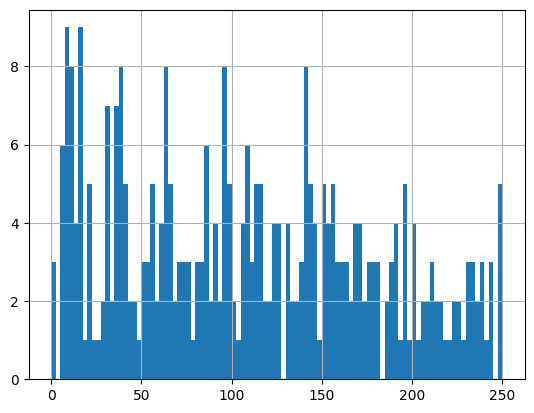

10909 , W_Nabellen incomplete dossiers : 432.0
count      432.000000
mean       356.335648
std        734.755831
min          1.000000
25%         74.500000
50%        166.500000
75%        410.750000
max      12285.000000
Name: duration_seconds, dtype: float64


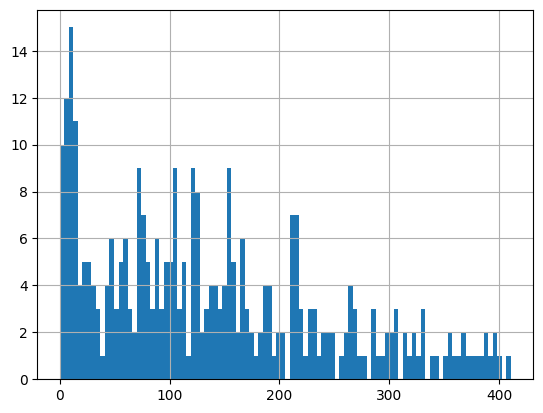

11121 , W_Nabellen incomplete dossiers : 402.0
count       402.000000
mean        968.164179
std       11259.772656
min           1.000000
25%          24.000000
50%         125.500000
75%         393.000000
max      225482.000000
Name: duration_seconds, dtype: float64


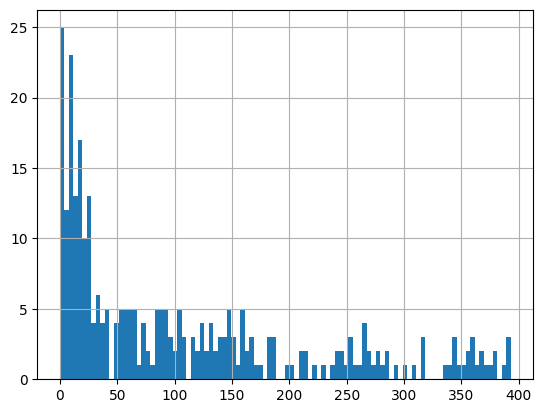

11000 , W_Nabellen incomplete dossiers : 391.0
count      391.000000
mean       644.907928
std       4043.925250
min          1.000000
25%         60.500000
50%        198.000000
75%        375.000000
max      54357.000000
Name: duration_seconds, dtype: float64


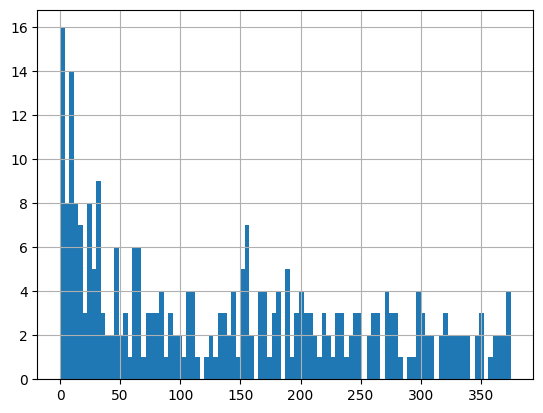

11259 , W_Nabellen incomplete dossiers : 391.0
count      391.000000
mean       470.219949
std       4168.853793
min          1.000000
25%         20.000000
50%         48.000000
75%         81.500000
max      47871.000000
Name: duration_seconds, dtype: float64


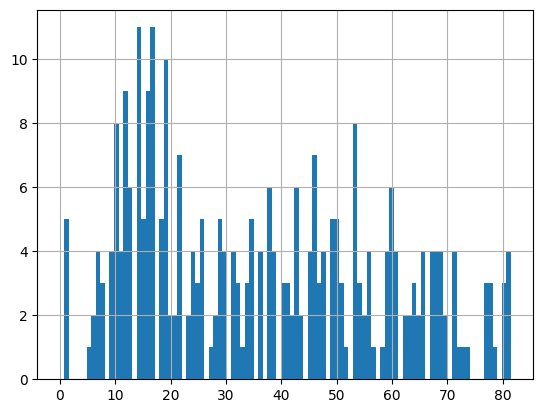

10939 , W_Completeren aanvraag : 388.0
count     388.000000
mean      368.494845
std       364.516390
min         1.000000
25%       107.500000
50%       260.500000
75%       551.250000
max      3182.000000
Name: duration_seconds, dtype: float64


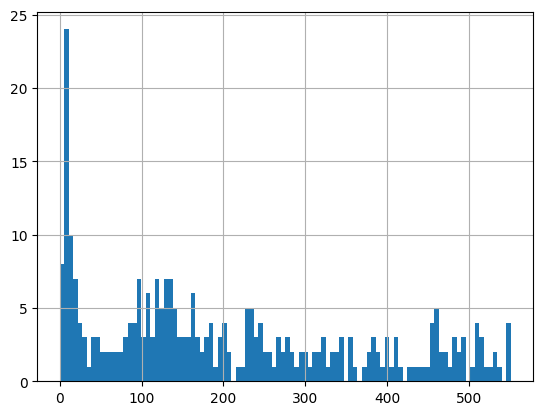

10929 , W_Nabellen incomplete dossiers : 387.0
count     387.000000
mean      403.144703
std       554.963939
min         1.000000
25%        72.000000
50%       213.000000
75%       492.000000
max      4467.000000
Name: duration_seconds, dtype: float64


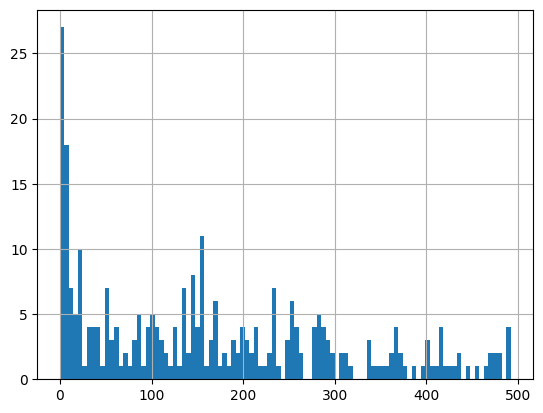

10899 , W_Nabellen incomplete dossiers : 384.0
count      384.000000
mean       189.322917
std       2503.468978
min          1.000000
25%         25.000000
50%         34.500000
75%         57.250000
max      49067.000000
Name: duration_seconds, dtype: float64


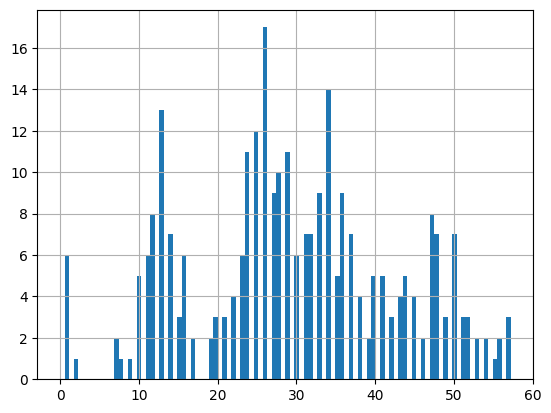

10912 , W_Completeren aanvraag : 380.0
count       380.000000
mean       1155.705263
std        9995.428787
min           5.000000
25%         115.500000
50%         313.500000
75%         621.250000
max      140573.000000
Name: duration_seconds, dtype: float64


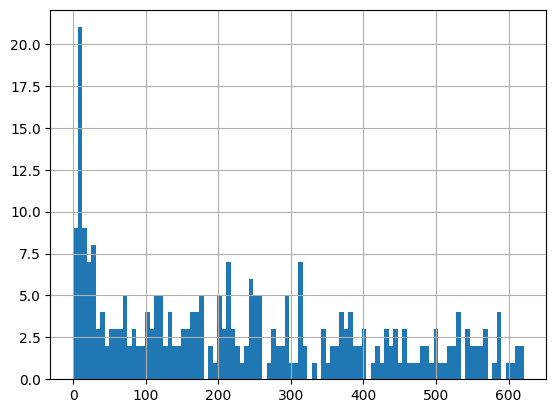

10933 , W_Completeren aanvraag : 352.0
count      352.000000
mean       417.576705
std       2132.412075
min          1.000000
25%         18.000000
50%        119.000000
75%        421.500000
max      39465.000000
Name: duration_seconds, dtype: float64


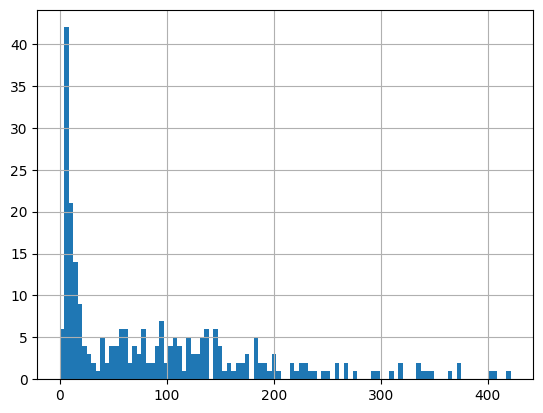

10982 , W_Nabellen incomplete dossiers : 350.0
count      350.000000
mean       466.314286
std       2869.944260
min          1.000000
25%         28.250000
50%         78.500000
75%        225.750000
max      39255.000000
Name: duration_seconds, dtype: float64


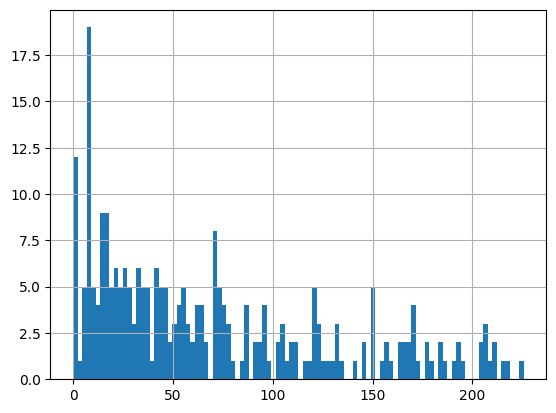

10609 , W_Nabellen incomplete dossiers : 339.0
count     339.000000
mean      229.085546
std       512.330990
min         5.000000
25%        12.000000
50%        36.000000
75%       144.500000
max      4689.000000
Name: duration_seconds, dtype: float64


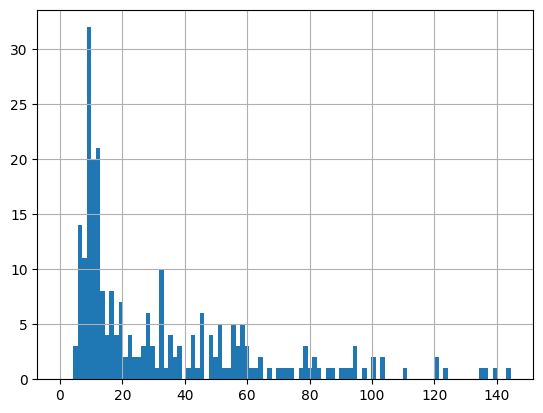

11002 , W_Nabellen incomplete dossiers : 339.0
count       339.000000
mean       3765.327434
std       25139.460541
min           1.000000
25%          62.000000
50%         200.000000
75%         609.000000
max      236278.000000
Name: duration_seconds, dtype: float64


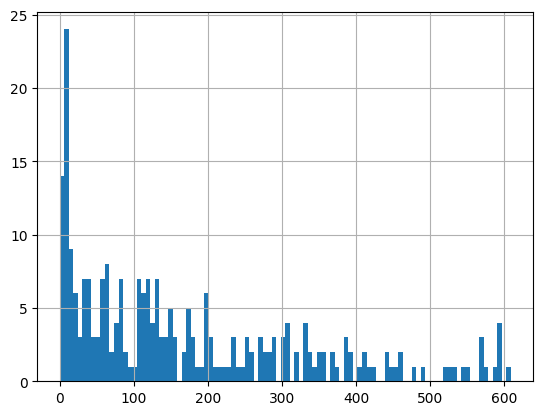

10929 , W_Completeren aanvraag : 338.0
count     338.000000
mean      444.686391
std       461.912309
min         4.000000
25%       114.250000
50%       244.000000
75%       680.000000
max      3409.000000
Name: duration_seconds, dtype: float64


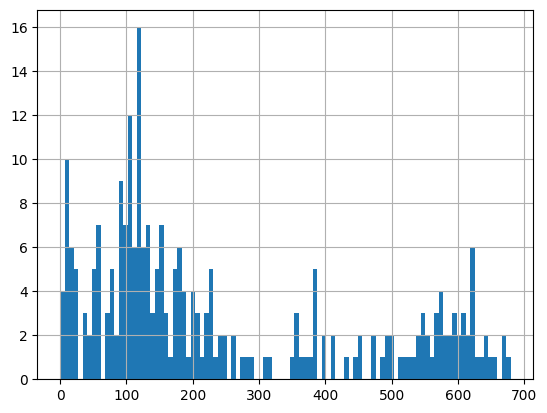

11009 , W_Nabellen offertes : 322.0
count     322.000000
mean      180.021739
std       283.347803
min         2.000000
25%        43.000000
50%       104.500000
75%       202.750000
max      3523.000000
Name: duration_seconds, dtype: float64


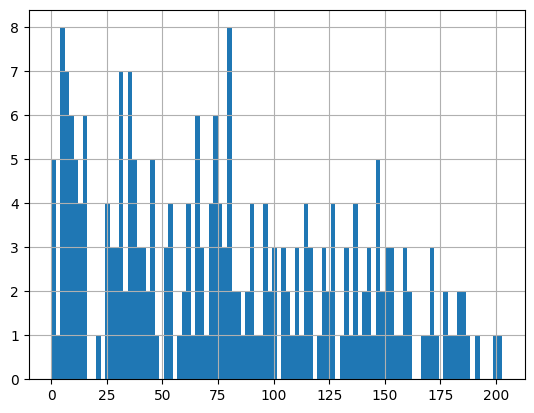

10881 , W_Completeren aanvraag : 322.0
count      322.000000
mean       453.642857
std       3649.417001
min          2.000000
25%         66.250000
50%        144.000000
75%        384.750000
max      65579.000000
Name: duration_seconds, dtype: float64


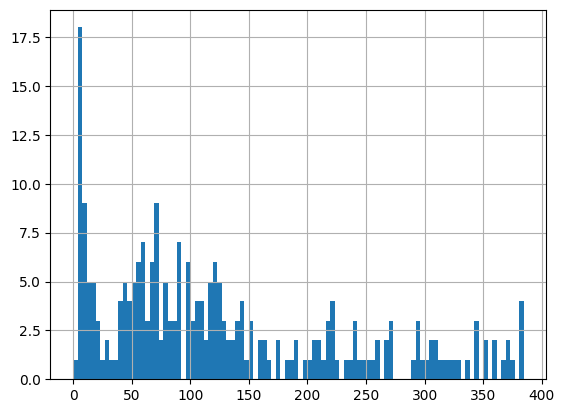

11009 , W_Completeren aanvraag : 322.0
count      322.000000
mean       778.987578
std       4089.779878
min          5.000000
25%        139.500000
50%        308.500000
75%        604.500000
max      55301.000000
Name: duration_seconds, dtype: float64


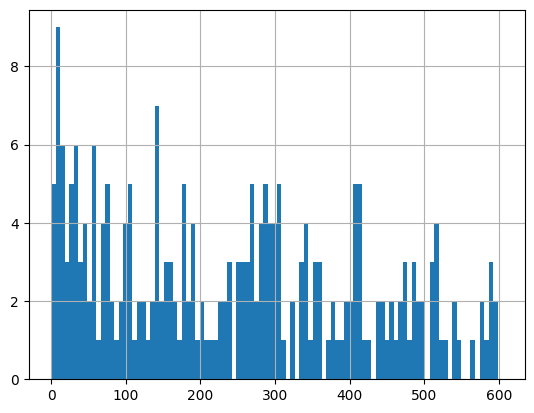

11121 , W_Nabellen offertes : 320.0
count       320.000000
mean       1046.075000
std       12622.281361
min           1.000000
25%          46.000000
50%          99.500000
75%         212.250000
max      220667.000000
Name: duration_seconds, dtype: float64


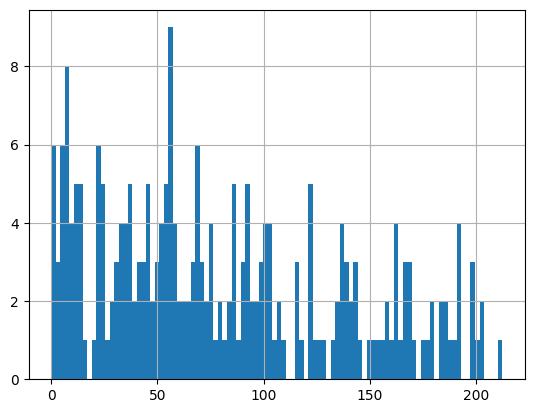

11189 , W_Nabellen incomplete dossiers : 302.0
count     302.000000
mean      374.076159
std       453.473157
min         1.000000
25%        64.500000
50%       248.000000
75%       490.250000
max      3749.000000
Name: duration_seconds, dtype: float64


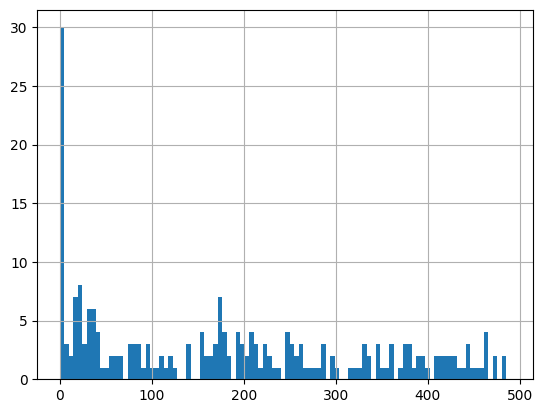

11179 , W_Nabellen offertes : 295.0
count     295.000000
mean      194.532203
std       382.750916
min         6.000000
25%        35.500000
50%        94.000000
75%       222.000000
max      5370.000000
Name: duration_seconds, dtype: float64


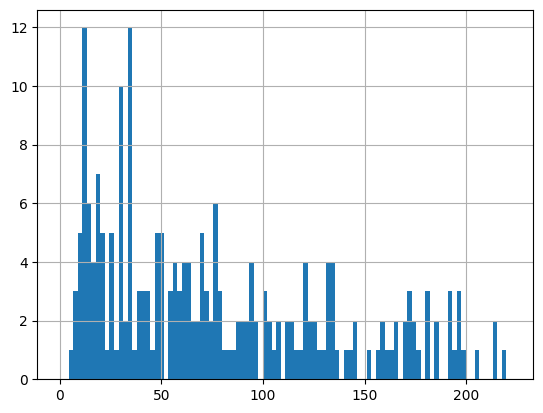

10929 , W_Nabellen offertes : 292.0
count       292.000000
mean       1005.972603
std       13154.047021
min           1.000000
25%          54.000000
50%         121.000000
75%         256.500000
max      224885.000000
Name: duration_seconds, dtype: float64


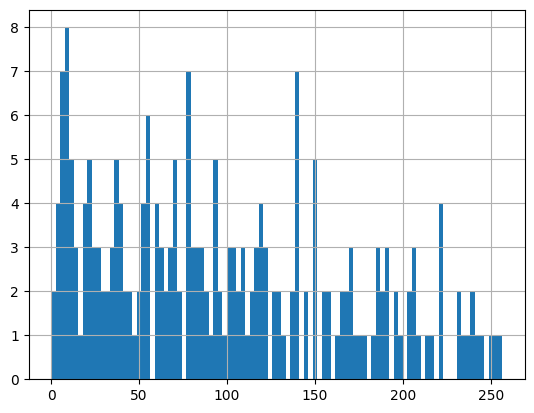

10889 , W_Completeren aanvraag : 289.0
count       289.000000
mean       1050.681661
std        9042.163799
min           2.000000
25%         123.000000
50%         299.000000
75%         662.000000
max      152552.000000
Name: duration_seconds, dtype: float64


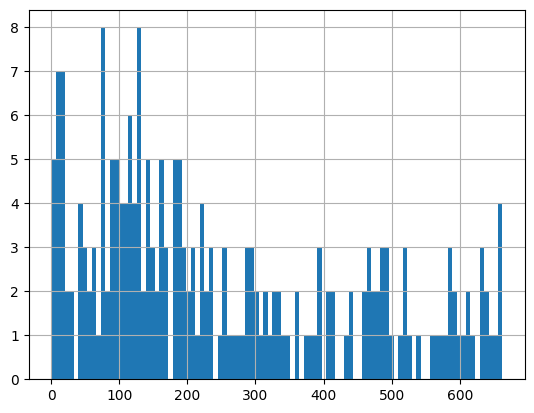

10982 , W_Afhandelen leads : 283.0
count     283.000000
mean      147.929329
std       228.833587
min         1.000000
25%        53.000000
50%        92.000000
75%       154.000000
max      2767.000000
Name: duration_seconds, dtype: float64


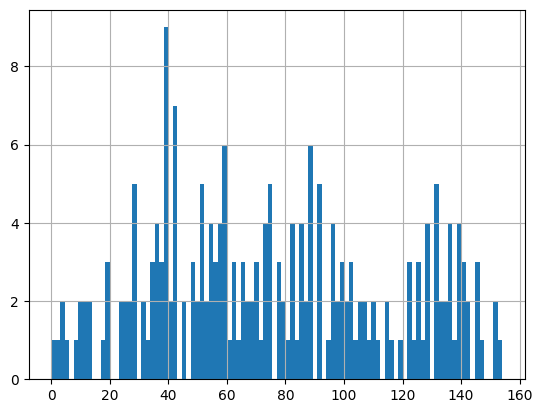

10932 , W_Nabellen incomplete dossiers : 276.0
count       276.000000
mean       3526.329710
std       24316.561691
min           1.000000
25%          21.000000
50%         149.500000
75%         508.750000
max      242764.000000
Name: duration_seconds, dtype: float64


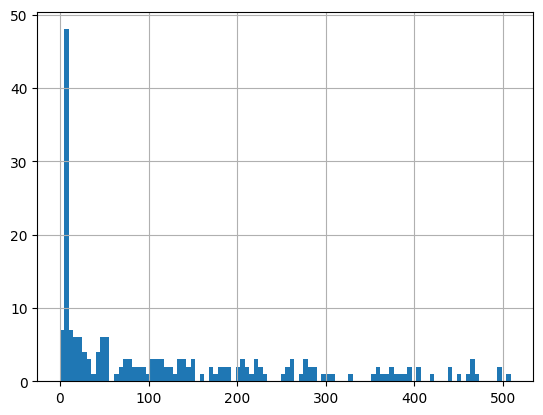

10863 , W_Nabellen offertes : 276.0
count     276.000000
mean      270.275362
std       704.478218
min         2.000000
25%        61.500000
50%       110.000000
75%       207.000000
max      9173.000000
Name: duration_seconds, dtype: float64


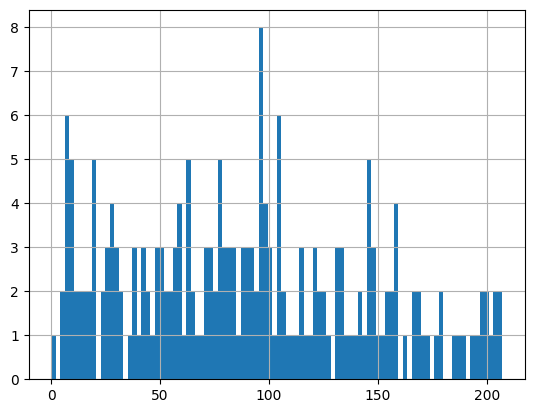

10809 , W_Nabellen incomplete dossiers : 274.0
count     274.000000
mean      308.894161
std       773.749072
min         1.000000
25%        37.250000
50%        85.000000
75%       189.750000
max      8606.000000
Name: duration_seconds, dtype: float64


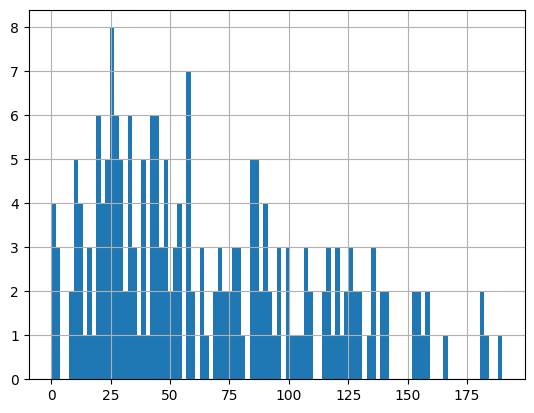

10910 , W_Nabellen incomplete dossiers : 272.0
count      272.000000
mean       566.757353
std       4423.223755
min          1.000000
25%         19.000000
50%         59.000000
75%        226.500000
max      55013.000000
Name: duration_seconds, dtype: float64


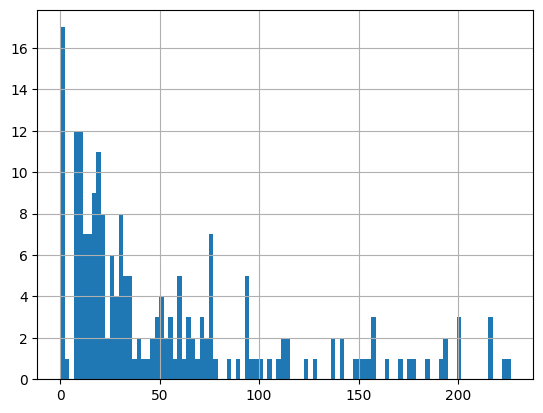

10789 , W_Nabellen offertes : 267.0
count    267.000000
mean      33.187266
std       47.357568
min        1.000000
25%       13.000000
50%       16.000000
75%       29.000000
max      373.000000
Name: duration_seconds, dtype: float64


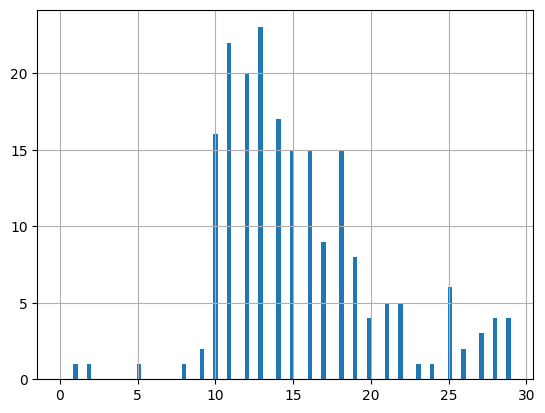

11009 , W_Nabellen incomplete dossiers : 264.0
count     264.000000
mean      496.284091
std       729.219781
min         1.000000
25%        73.250000
50%       243.000000
75%       604.250000
max      4096.000000
Name: duration_seconds, dtype: float64


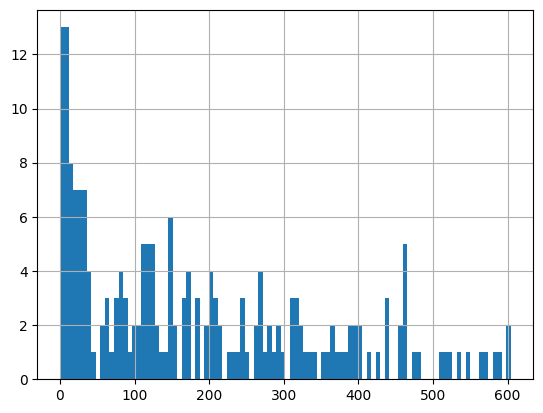

10861 , W_Nabellen incomplete dossiers : 261.0
count     261.000000
mean      234.268199
std       434.644405
min         1.000000
25%        39.000000
50%       118.000000
75%       306.000000
max      5522.000000
Name: duration_seconds, dtype: float64


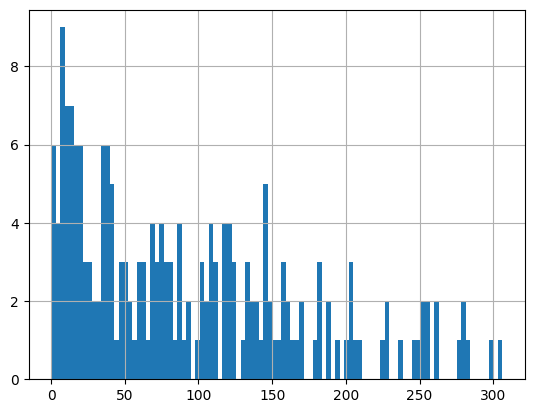

10881 , W_Nabellen incomplete dossiers : 255.0
count     255.000000
mean      274.705882
std       347.131842
min         1.000000
25%        60.500000
50%       157.000000
75%       308.000000
max      2381.000000
Name: duration_seconds, dtype: float64


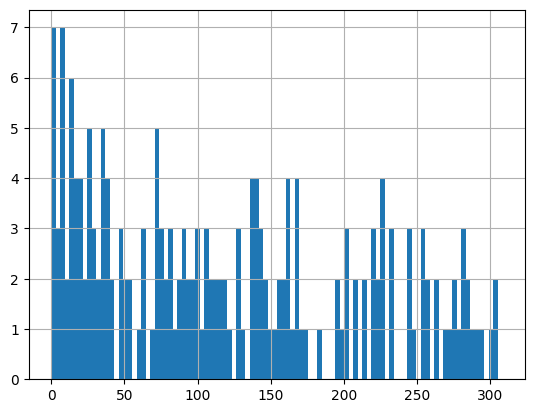

11302 , W_Completeren aanvraag : 251.0
count     251.000000
mean      274.605578
std       442.152833
min         4.000000
25%        14.500000
50%        99.000000
75%       316.000000
max      3531.000000
Name: duration_seconds, dtype: float64


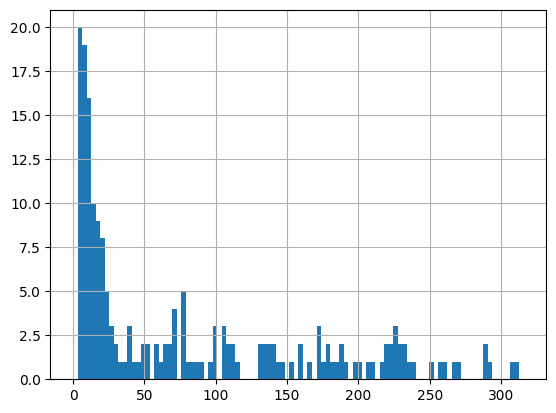

10932 , W_Nabellen offertes : 244.0
count      244.000000
mean      1634.372951
std       8074.197127
min          1.000000
25%         72.750000
50%        179.000000
75%        351.500000
max      64599.000000
Name: duration_seconds, dtype: float64


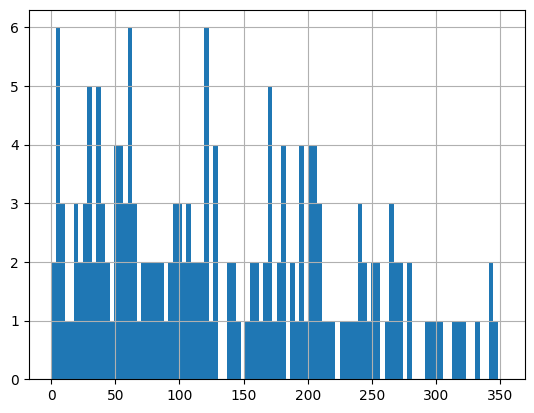

11122 , W_Nabellen incomplete dossiers : 233.0
count     233.000000
mean      430.695279
std       588.065485
min         1.000000
25%        38.000000
50%       190.000000
75%       596.000000
max      4098.000000
Name: duration_seconds, dtype: float64


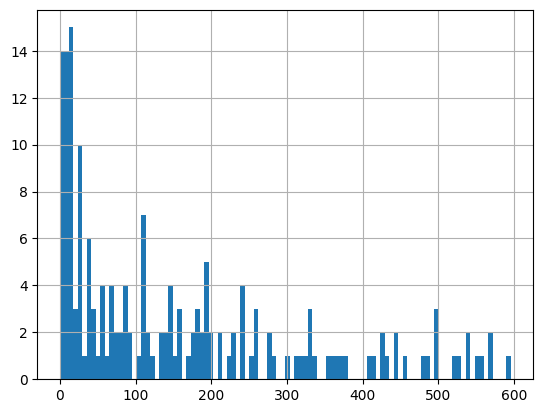

10939 , W_Nabellen offertes : 227.0
count     227.000000
mean      238.013216
std       358.493412
min         5.000000
25%        71.000000
50%       127.000000
75%       264.000000
max      2620.000000
Name: duration_seconds, dtype: float64


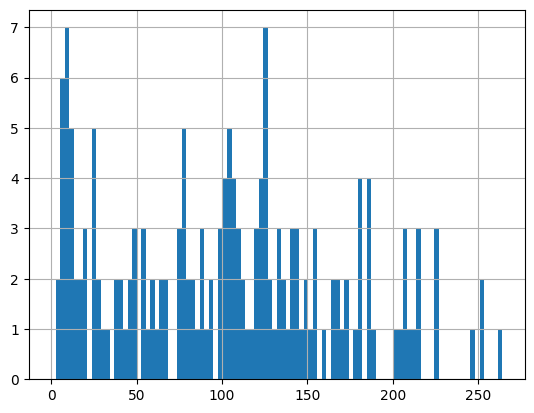

10933 , W_Nabellen offertes : 220.0
count     220.000000
mean      202.463636
std       312.063062
min         6.000000
25%        59.750000
50%       125.000000
75%       214.750000
max      2649.000000
Name: duration_seconds, dtype: float64


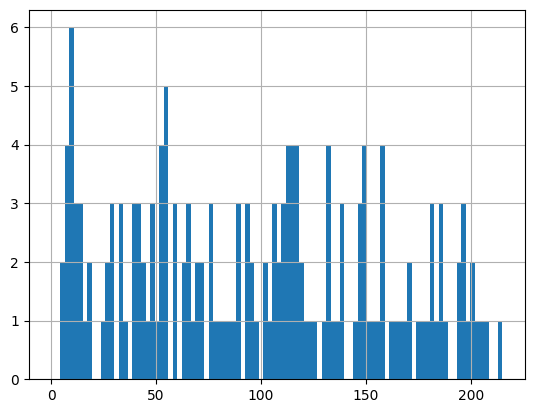

10932 , W_Afhandelen leads : 218.0
count       218.000000
mean       8009.096330
std       38022.341203
min           6.000000
25%          84.500000
50%         159.000000
75%         359.750000
max      243739.000000
Name: duration_seconds, dtype: float64


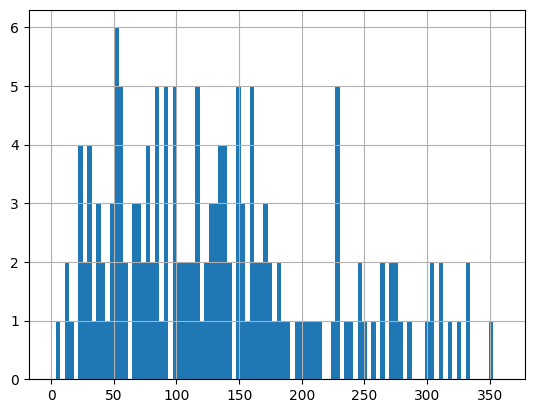

11169 , W_Nabellen offertes : 217.0
count       217.000000
mean       2038.576037
std       15754.384385
min           3.000000
25%          87.000000
50%         195.000000
75%         364.000000
max      221363.000000
Name: duration_seconds, dtype: float64


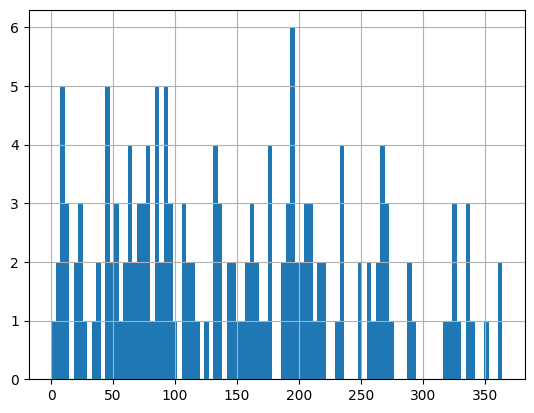

10889 , W_Afhandelen leads : 211.0
count      211.000000
mean       627.516588
std       4124.104401
min          1.000000
25%         36.500000
50%        102.000000
75%        241.000000
max      58518.000000
Name: duration_seconds, dtype: float64


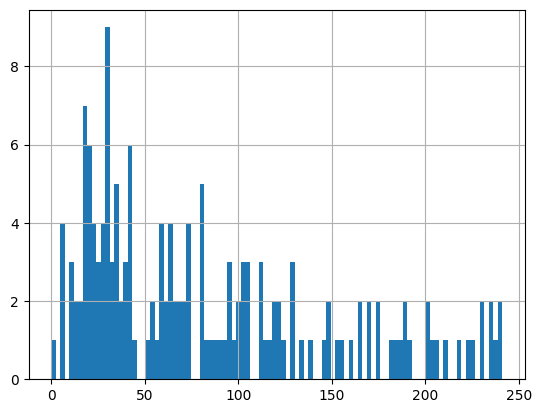

10188 , W_Beoordelen fraude : 210.0
count     210.000000
mean      121.861905
std       832.377074
min         1.000000
25%         5.250000
50%         8.000000
75%        11.000000
max      9240.000000
Name: duration_seconds, dtype: float64


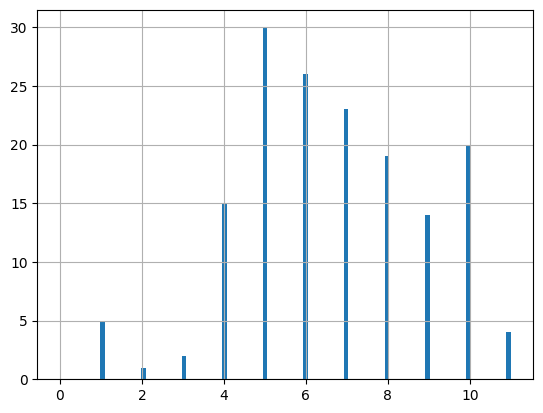

11299 , W_Nabellen offertes : 204.0
count      204.000000
mean      1033.995098
std       5624.810760
min          5.000000
25%        102.000000
50%        169.000000
75%        277.750000
max      48518.000000
Name: duration_seconds, dtype: float64


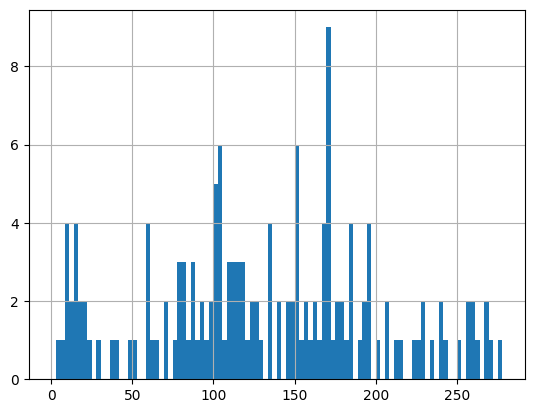

11002 , W_Nabellen offertes : 200.0
count      200.000000
mean      1513.590000
std       6585.768738
min          1.000000
25%         59.000000
50%        131.500000
75%        313.000000
max      40389.000000
Name: duration_seconds, dtype: float64


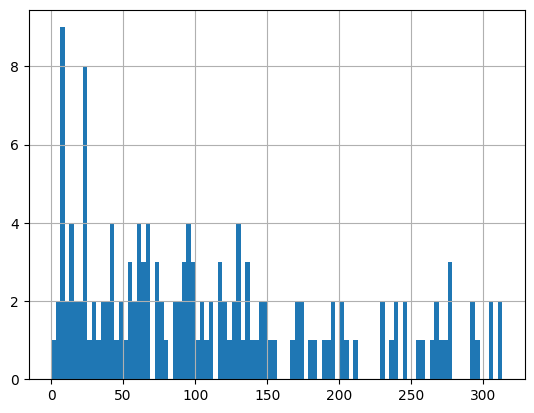

10863 , W_Afhandelen leads : 199.0
count      199.000000
mean       653.673367
std       2612.564346
min          8.000000
25%        126.000000
50%        228.000000
75%        380.500000
max      34577.000000
Name: duration_seconds, dtype: float64


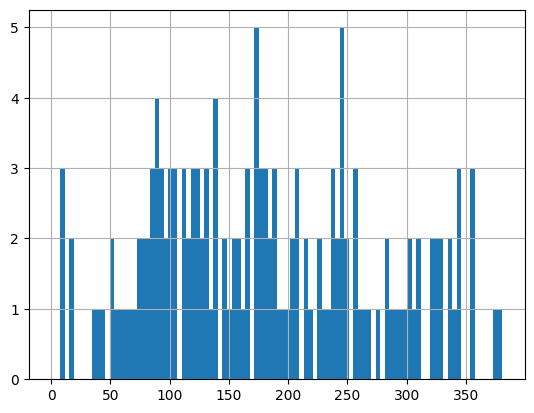

10909 , W_Afhandelen leads : 195.0
count      195.000000
mean       652.158974
std       4899.899664
min          6.000000
25%         70.500000
50%        127.000000
75%        204.500000
max      59838.000000
Name: duration_seconds, dtype: float64


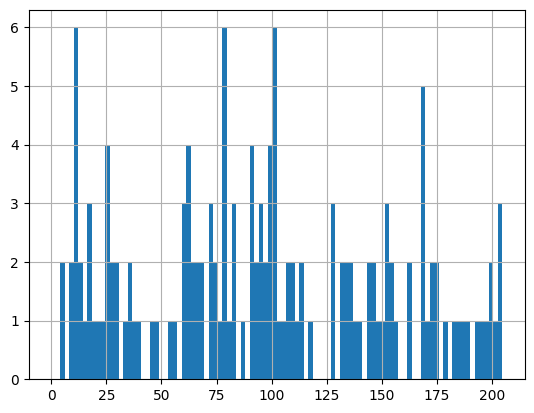

10861 , W_Afhandelen leads : 192.0
count      192.000000
mean      2001.208333
std       8657.801778
min          1.000000
25%         62.250000
50%        125.500000
75%        248.750000
max      59505.000000
Name: duration_seconds, dtype: float64


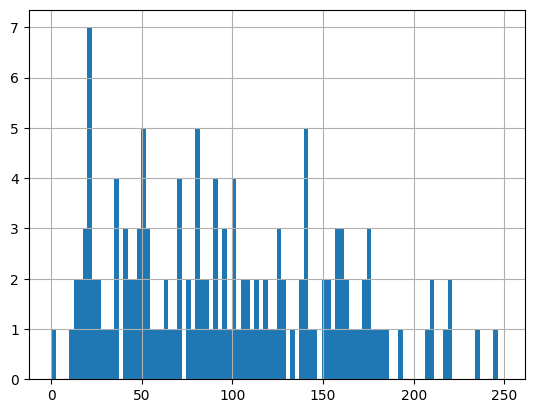

11309 , W_Completeren aanvraag : 192.0
count     192.000000
mean      277.312500
std       600.757947
min         5.000000
25%        24.000000
50%        84.500000
75%       287.750000
max      6606.000000
Name: duration_seconds, dtype: float64


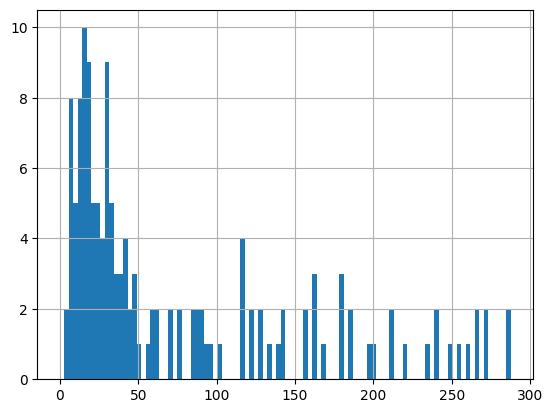

11009 , W_Afhandelen leads : 191.0
count     191.000000
mean      315.403141
std       778.431243
min        11.000000
25%        98.500000
50%       140.000000
75%       263.500000
max      9216.000000
Name: duration_seconds, dtype: float64


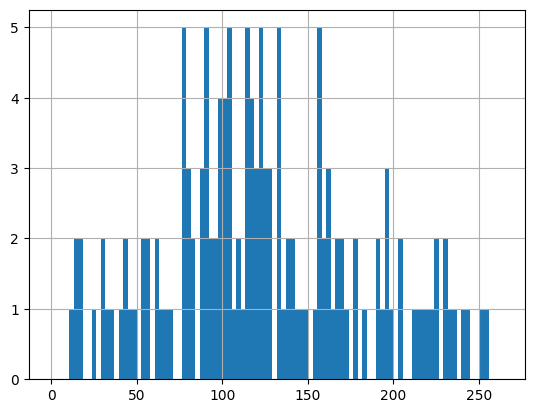

11300 , W_Completeren aanvraag : 190.0
count     190.000000
mean      371.463158
std       415.521303
min         5.000000
25%       113.500000
50%       194.500000
75%       568.000000
max      3360.000000
Name: duration_seconds, dtype: float64


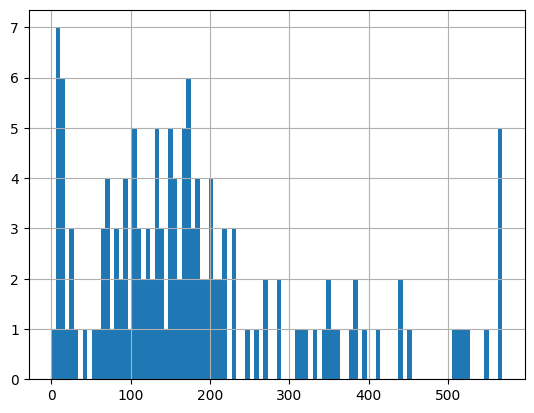

11002 , W_Completeren aanvraag : 188.0
count      188.000000
mean      1643.090426
std       8708.257976
min          6.000000
25%        115.750000
50%        308.000000
75%        668.500000
max      74400.000000
Name: duration_seconds, dtype: float64


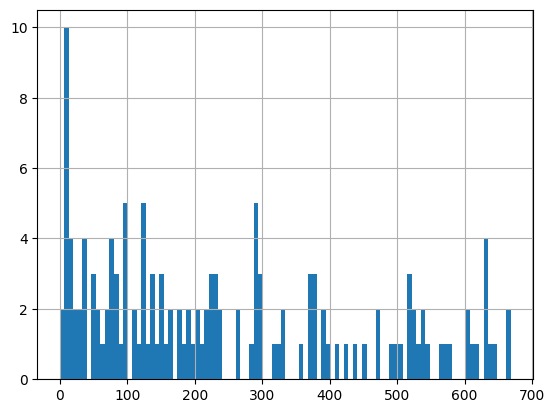

10913 , W_Afhandelen leads : 188.0
count      188.000000
mean       306.297872
std       2595.865838
min          1.000000
25%         44.000000
50%         76.500000
75%        123.250000
max      35636.000000
Name: duration_seconds, dtype: float64


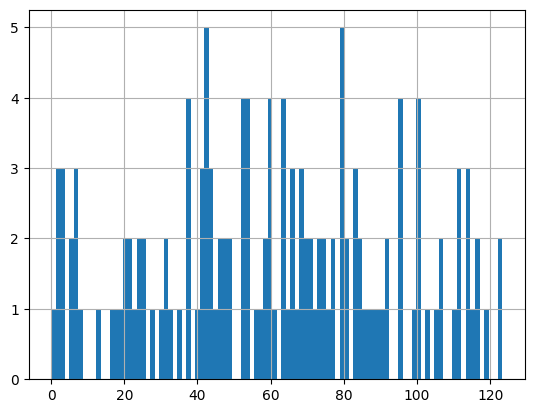

11189 , W_Afhandelen leads : 183.0
count     183.000000
mean      230.945355
std       605.391724
min        12.000000
25%        75.500000
50%       115.000000
75%       197.000000
max      7836.000000
Name: duration_seconds, dtype: float64


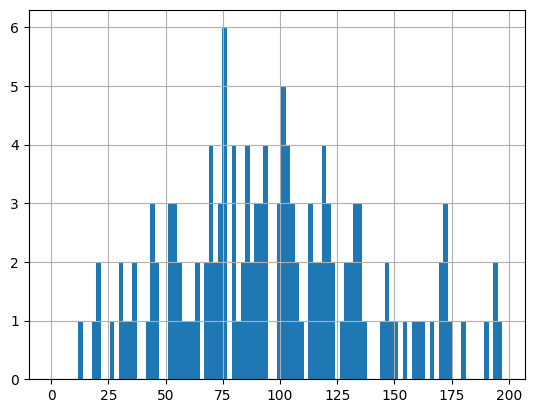

10931 , W_Nabellen incomplete dossiers : 180.0
count      180.000000
mean       644.611111
std       1296.150732
min          1.000000
25%         82.500000
50%        241.500000
75%        759.000000
max      12325.000000
Name: duration_seconds, dtype: float64


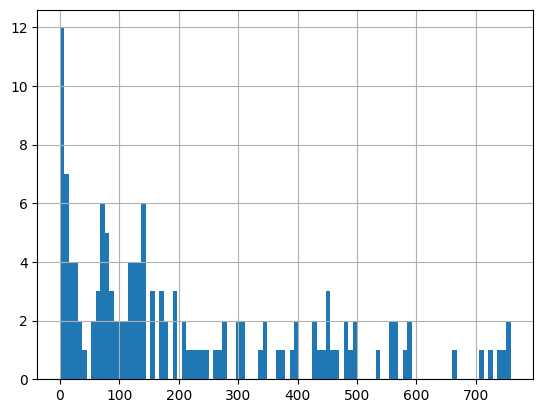

10881 , W_Afhandelen leads : 176.0
count     176.000000
mean      104.323864
std       168.839883
min         5.000000
25%        32.750000
50%        73.000000
75%       117.250000
max      1934.000000
Name: duration_seconds, dtype: float64


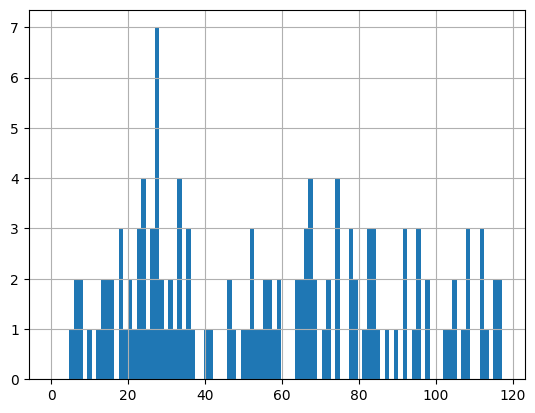

11122 , W_Afhandelen leads : 174.0
count     174.000000
mean      196.178161
std       268.404680
min         1.000000
25%        66.250000
50%       126.500000
75%       205.000000
max      2094.000000
Name: duration_seconds, dtype: float64


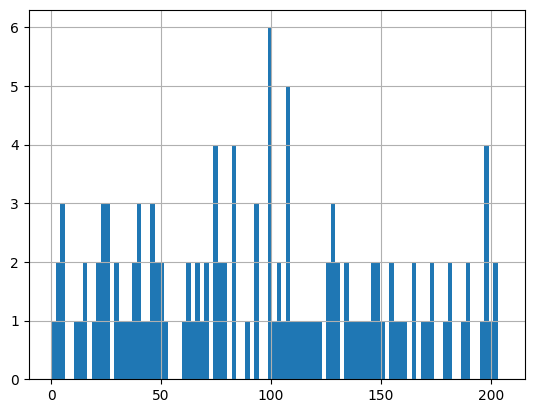

11180 , W_Nabellen incomplete dossiers : 173.0
count     173.000000
mean      379.907514
std       387.445244
min         1.000000
25%        79.000000
50%       273.000000
75%       554.000000
max      2182.000000
Name: duration_seconds, dtype: float64


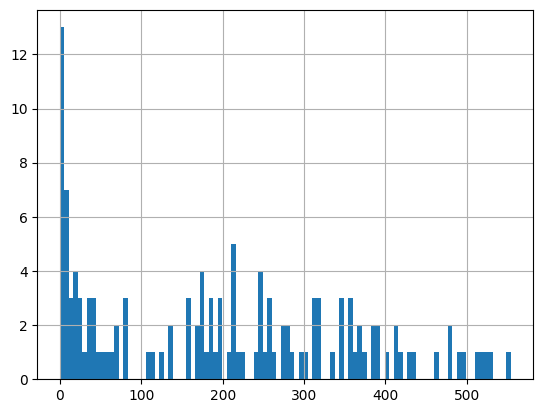

10972 , W_Nabellen incomplete dossiers : 171.0
count      171.000000
mean       994.561404
std       6168.080921
min          1.000000
25%         46.000000
50%        140.000000
75%        573.000000
max      64358.000000
Name: duration_seconds, dtype: float64


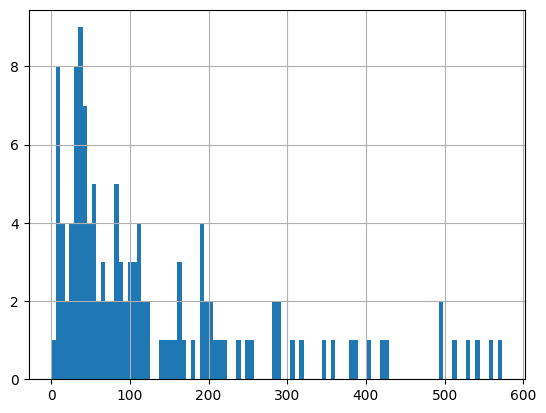

10931 , W_Completeren aanvraag : 168.0
count      168.000000
mean       697.065476
std       2768.343419
min          7.000000
25%        178.000000
50%        369.500000
75%        606.000000
max      35374.000000
Name: duration_seconds, dtype: float64


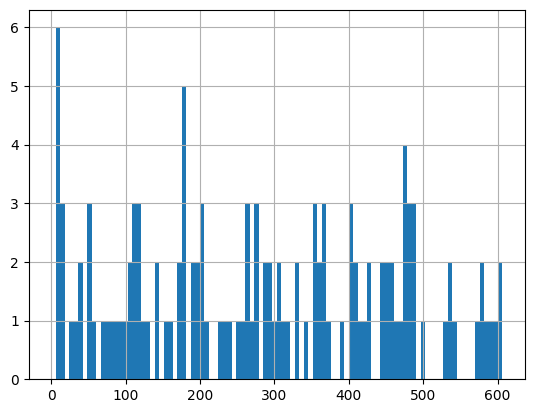

11319 , W_Completeren aanvraag : 167.0
count      167.000000
mean       652.742515
std       4425.344798
min          5.000000
25%         59.500000
50%        179.000000
75%        382.000000
max      57189.000000
Name: duration_seconds, dtype: float64


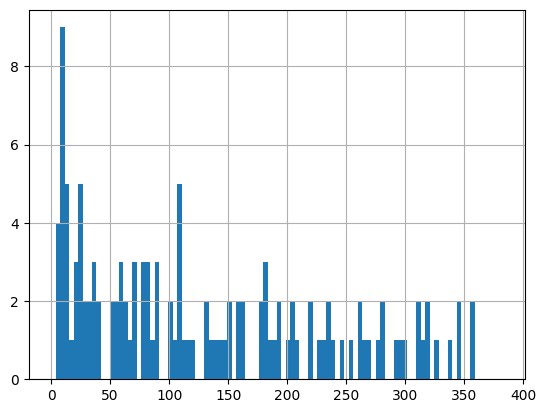

11003 , W_Afhandelen leads : 166.0
count    166.000000
mean     109.602410
std      120.193878
min        1.000000
25%       44.500000
50%       81.000000
75%      116.500000
max      758.000000
Name: duration_seconds, dtype: float64


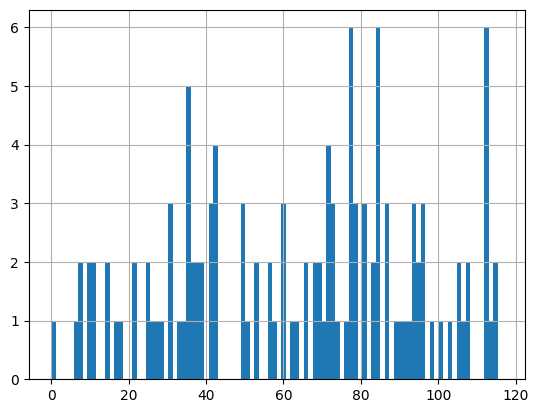

10912 , W_Nabellen offertes : 163.0
count       163.000000
mean       2784.846626
std       20513.800317
min           7.000000
25%          54.000000
50%         143.000000
75%         313.500000
max      209535.000000
Name: duration_seconds, dtype: float64


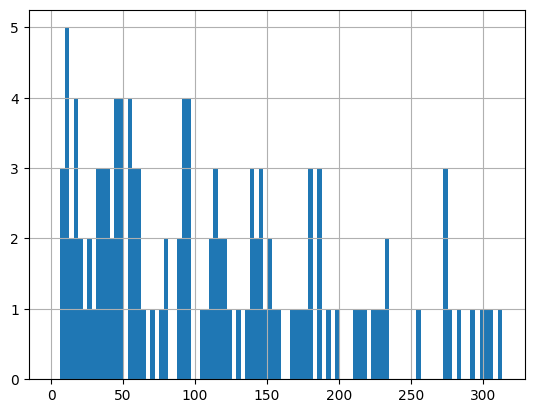

10910 , W_Nabellen offertes : 161.0
count       161.000000
mean       1647.757764
std       17645.779893
min           2.000000
25%          39.000000
50%          75.000000
75%         130.000000
max      223624.000000
Name: duration_seconds, dtype: float64


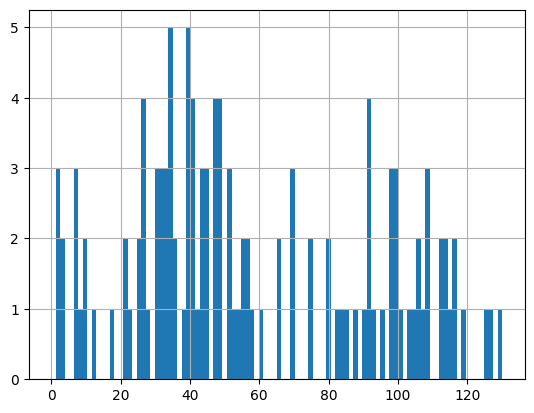

11300 , W_Nabellen offertes : 156.0
count     156.000000
mean      177.974359
std       189.676225
min         5.000000
25%        79.000000
50%       141.000000
75%       209.250000
max      1777.000000
Name: duration_seconds, dtype: float64


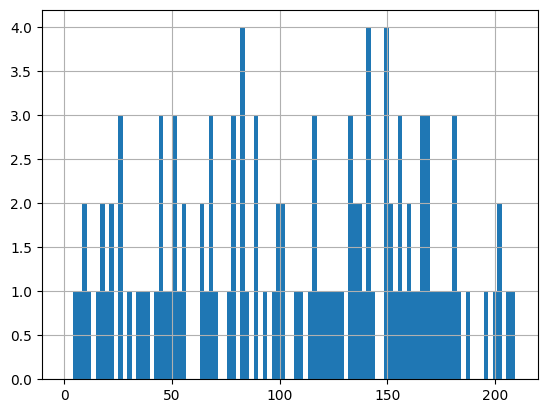

11119 , W_Nabellen incomplete dossiers : 155.0
count     155.000000
mean      505.870968
std       604.682322
min         1.000000
25%       132.000000
50%       310.000000
75%       643.500000
max      3385.000000
Name: duration_seconds, dtype: float64


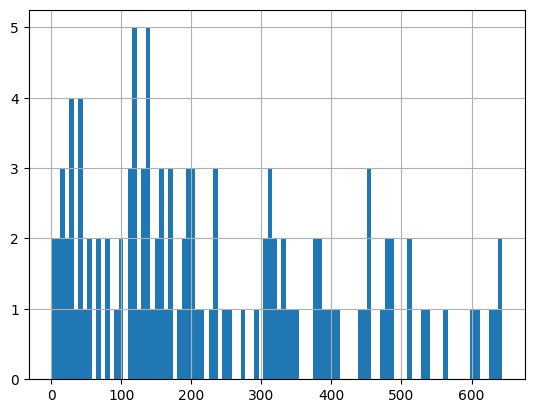

10939 , W_Afhandelen leads : 154.0
count     154.000000
mean      142.766234
std       197.360153
min         1.000000
25%        66.500000
50%        89.500000
75%       165.000000
max      2007.000000
Name: duration_seconds, dtype: float64


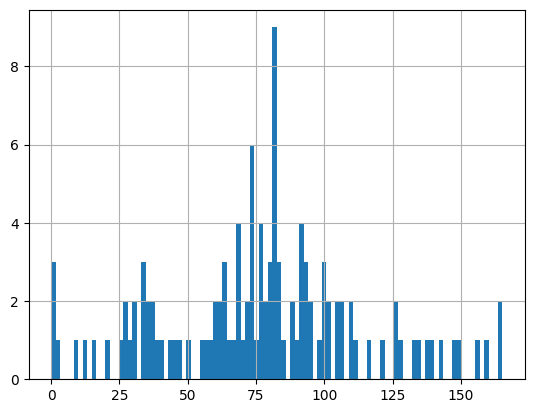

10929 , W_Afhandelen leads : 153.0
count       153.000000
mean       1344.816993
std       11710.075383
min           6.000000
25%          66.000000
50%          86.000000
75%         135.000000
max      135954.000000
Name: duration_seconds, dtype: float64


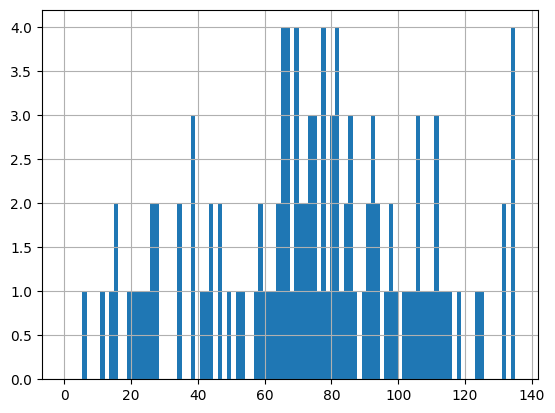

10138 , W_Nabellen incomplete dossiers : 152.0
count     152.000000
mean      163.519737
std       191.418614
min         8.000000
25%        43.000000
50%        89.500000
75%       203.000000
max      1225.000000
Name: duration_seconds, dtype: float64


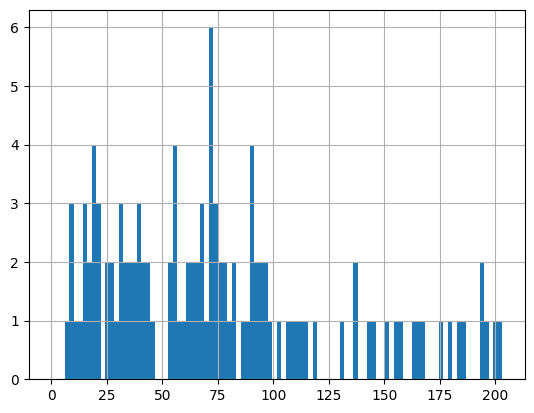

11119 , W_Afhandelen leads : 148.0
count     148.000000
mean      117.729730
std       184.831182
min         4.000000
25%        54.000000
50%        81.500000
75%       124.250000
max      1994.000000
Name: duration_seconds, dtype: float64


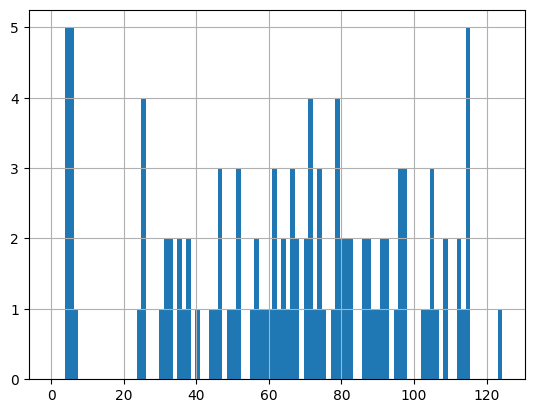

11203 , W_Afhandelen leads : 143.0
count      143.000000
mean      1136.412587
std       6783.116748
min          5.000000
25%         71.000000
50%        124.000000
75%        215.500000
max      59046.000000
Name: duration_seconds, dtype: float64


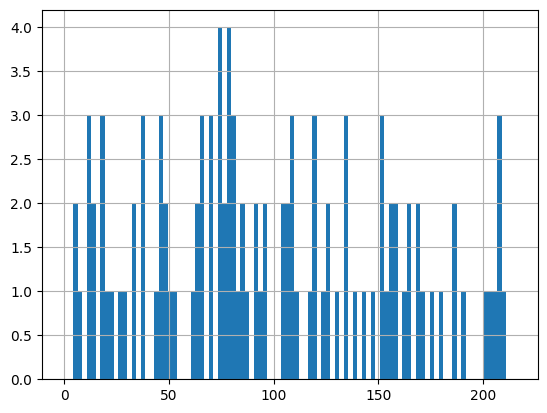

11299 , W_Completeren aanvraag : 143.0
count      143.000000
mean       747.307692
std       4651.492334
min          6.000000
25%         76.500000
50%        120.000000
75%        227.000000
max      54122.000000
Name: duration_seconds, dtype: float64


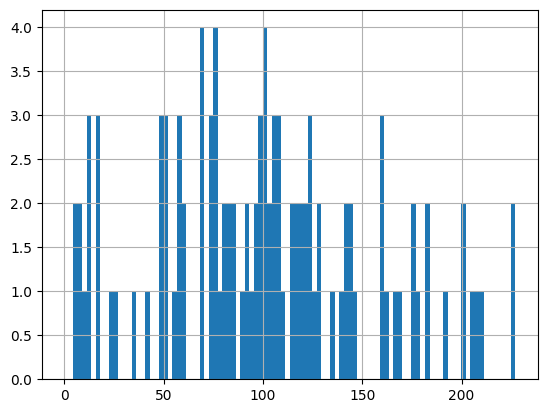

11003 , W_Nabellen incomplete dossiers : 139.0
count     139.000000
mean      253.079137
std       359.514872
min         1.000000
25%        39.000000
50%       121.000000
75%       329.000000
max      2522.000000
Name: duration_seconds, dtype: float64


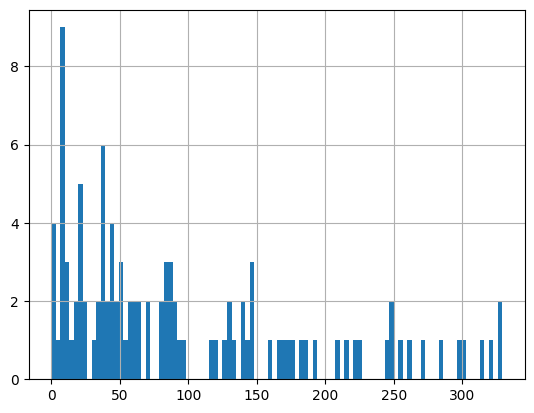

10935 , W_Nabellen offertes : 129.0
count       129.000000
mean       4457.992248
std       28667.268153
min           5.000000
25%          80.000000
50%         189.000000
75%         326.000000
max      233401.000000
Name: duration_seconds, dtype: float64


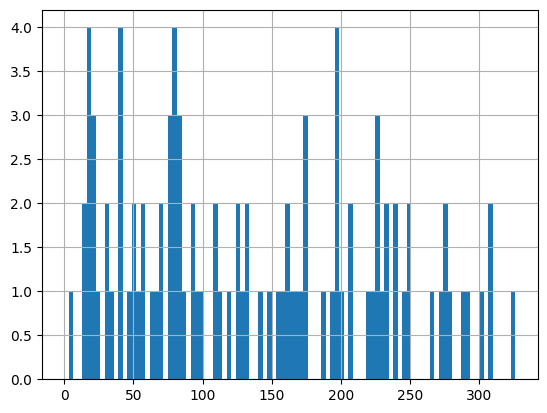

10789 , W_Nabellen incomplete dossiers : 127.0
count    127.000000
mean      73.527559
std       75.934896
min        1.000000
25%       34.500000
50%       50.000000
75%       85.000000
max      534.000000
Name: duration_seconds, dtype: float64


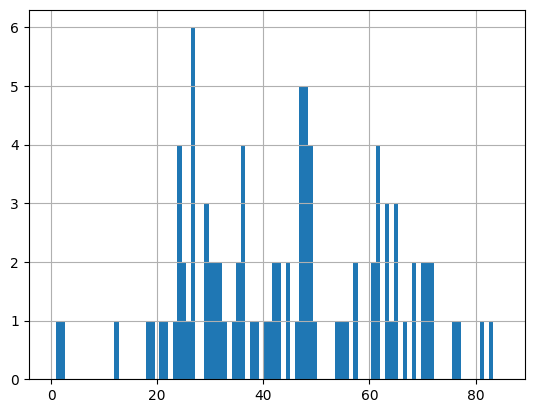

10863 , W_Nabellen incomplete dossiers : 124.0
count      124.000000
mean       430.403226
std       1376.701690
min          1.000000
25%         68.000000
50%        221.000000
75%        356.750000
max      15097.000000
Name: duration_seconds, dtype: float64


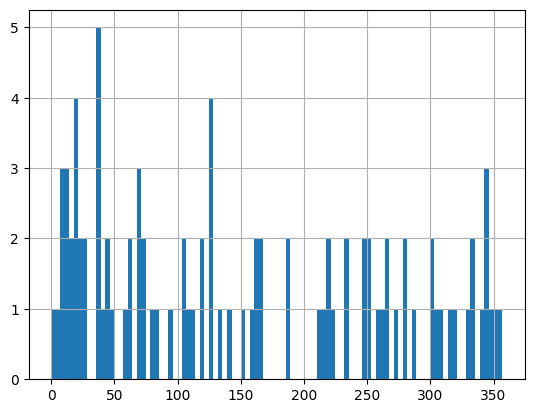

10629 , W_Nabellen incomplete dossiers : 123.0
count     123.000000
mean      233.869919
std       342.962455
min         6.000000
25%        21.500000
50%        63.000000
75%       350.500000
max      1859.000000
Name: duration_seconds, dtype: float64


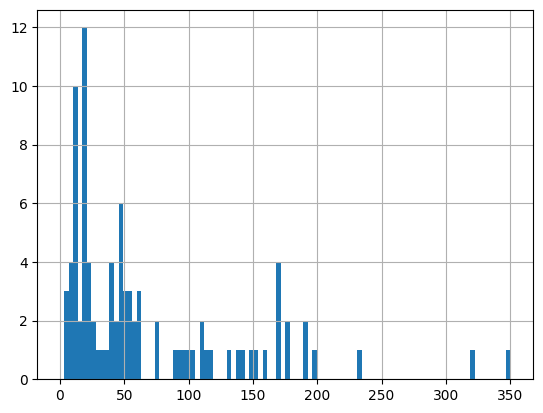

11000 , W_Afhandelen leads : 117.0
count      117.000000
mean      1664.923077
std       9475.718413
min          2.000000
25%        116.000000
50%        180.000000
75%        304.000000
max      74601.000000
Name: duration_seconds, dtype: float64


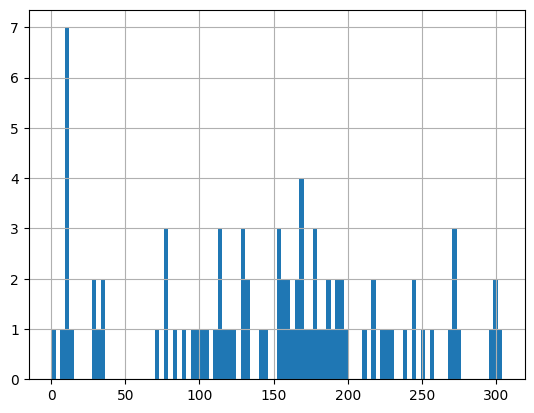

11302 , W_Nabellen offertes : 117.0
count     117.000000
mean      178.632479
std       186.098120
min         7.000000
25%        61.000000
50%       127.000000
75%       208.000000
max      1088.000000
Name: duration_seconds, dtype: float64


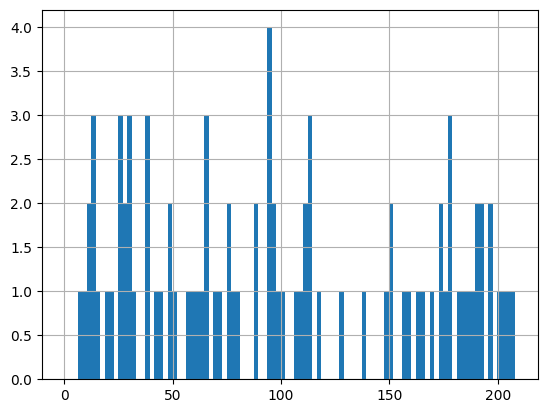

10935 , W_Nabellen incomplete dossiers : 115.0
count       115.000000
mean       2652.217391
std       21354.628280
min           1.000000
25%          44.500000
50%         195.000000
75%         444.500000
max      229152.000000
Name: duration_seconds, dtype: float64


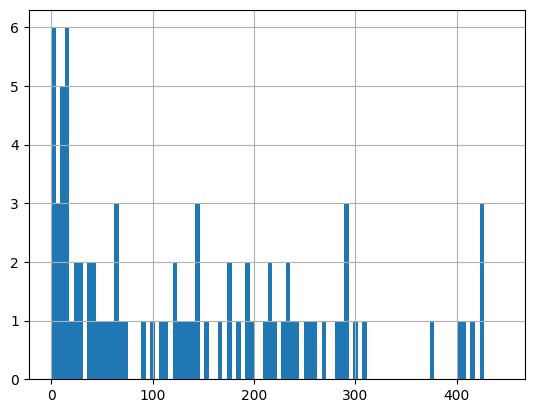

11319 , W_Nabellen offertes : 114.0
count     114.000000
mean      179.087719
std       216.470381
min         8.000000
25%        66.500000
50%       102.500000
75%       194.000000
max      1126.000000
Name: duration_seconds, dtype: float64


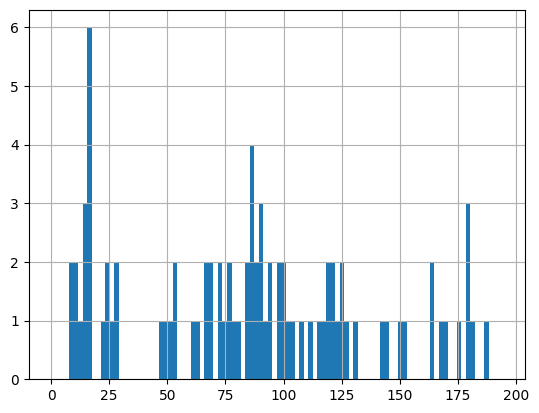

11309 , W_Nabellen offertes : 112.0
count       112.000000
mean       2109.455357
std       19686.472579
min           9.000000
25%         142.000000
50%         208.000000
75%         307.750000
max      208579.000000
Name: duration_seconds, dtype: float64


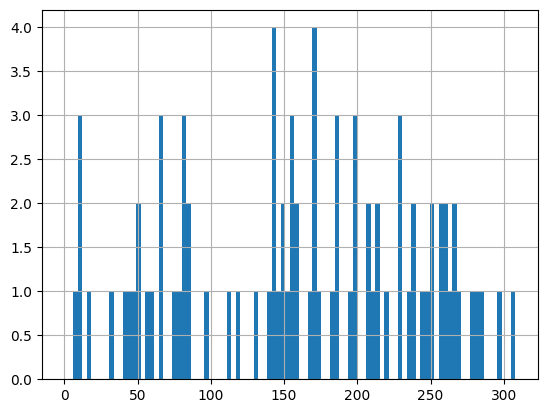

10228 , W_Afhandelen leads : 110.0
count      110.000000
mean       619.390909
std       3151.778229
min          5.000000
25%         82.750000
50%        164.000000
75%        341.250000
max      32886.000000
Name: duration_seconds, dtype: float64


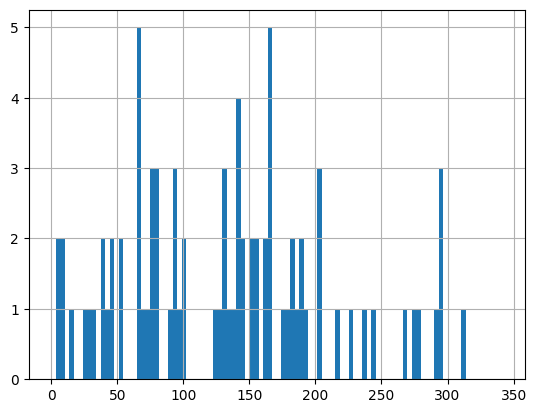

11121 , W_Afhandelen leads : 108.0
count      108.000000
mean       720.583333
std       4662.463256
min          1.000000
25%         91.000000
50%        159.500000
75%        219.500000
max      48505.000000
Name: duration_seconds, dtype: float64


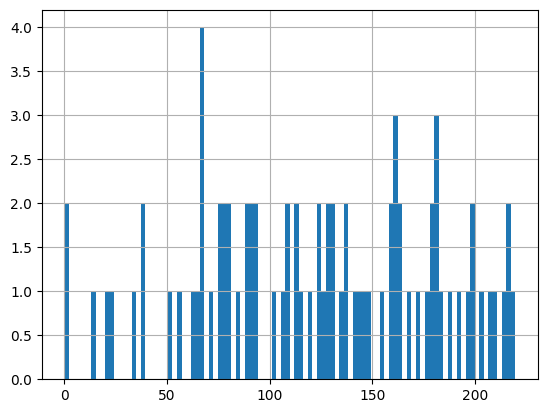

11201 , W_Nabellen incomplete dossiers : 108.0
count      108.000000
mean      1700.388889
std       7461.875946
min          1.000000
25%         48.000000
50%        133.000000
75%        346.000000
max      41820.000000
Name: duration_seconds, dtype: float64


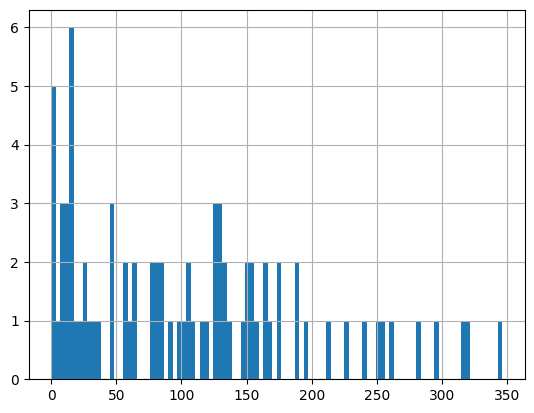

10939 , W_Nabellen incomplete dossiers : 103.0
count      103.000000
mean       496.640777
std       1177.612797
min          1.000000
25%         81.000000
50%        205.000000
75%        544.000000
max      11389.000000
Name: duration_seconds, dtype: float64


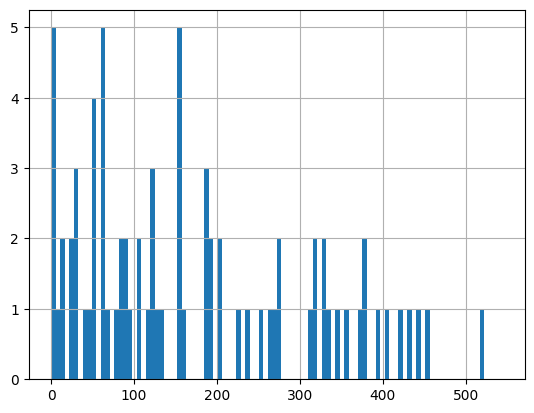

10912 , W_Nabellen incomplete dossiers : 103.0
count     103.000000
mean      301.058252
std       435.609238
min         1.000000
25%        26.000000
50%       116.000000
75%       470.000000
max      2751.000000
Name: duration_seconds, dtype: float64


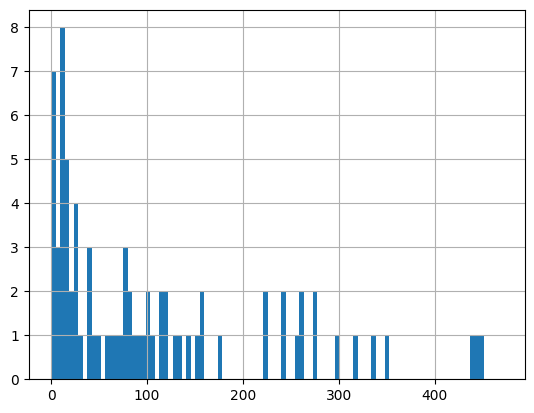

10889 , W_Nabellen incomplete dossiers : 101.0
count      101.000000
mean       743.356436
std       3866.998517
min          1.000000
25%         41.000000
50%        167.000000
75%        461.000000
max      38893.000000
Name: duration_seconds, dtype: float64


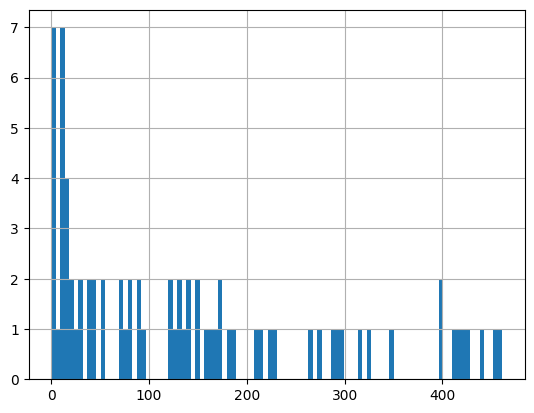

10609 , W_Nabellen offertes : 94.0
count     94.000000
mean      26.042553
std       52.433453
min        1.000000
25%       11.000000
50%       13.000000
75%       20.750000
max      440.000000
Name: duration_seconds, dtype: float64


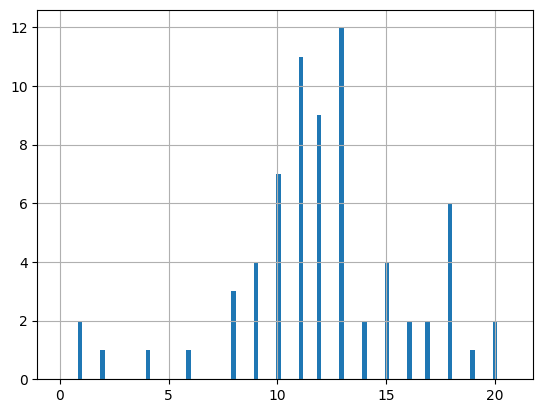

11019 , W_Nabellen incomplete dossiers : 92.0
count       92.000000
mean      1172.586957
std       5054.566231
min          1.000000
25%         99.500000
50%        268.000000
75%        788.750000
max      48258.000000
Name: duration_seconds, dtype: float64


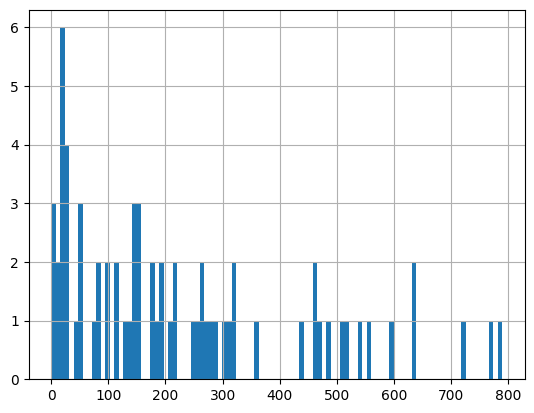

11179 , W_Nabellen incomplete dossiers : 91.0
count      91.000000
mean      420.406593
std       585.263663
min         1.000000
25%        60.000000
50%       207.000000
75%       537.000000
max      3039.000000
Name: duration_seconds, dtype: float64


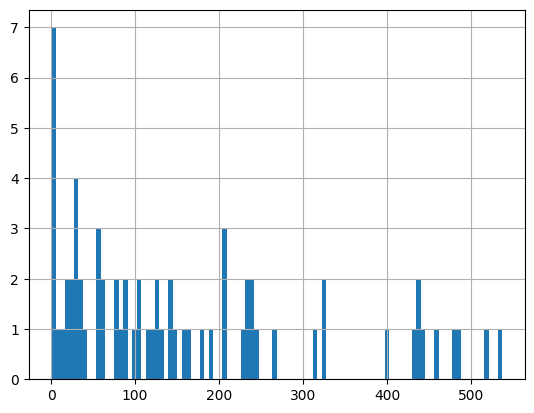

10629 , W_Afhandelen leads : 83.0
count     83.000000
mean     130.000000
std       96.496809
min        1.000000
25%       67.500000
50%      109.000000
75%      172.000000
max      548.000000
Name: duration_seconds, dtype: float64


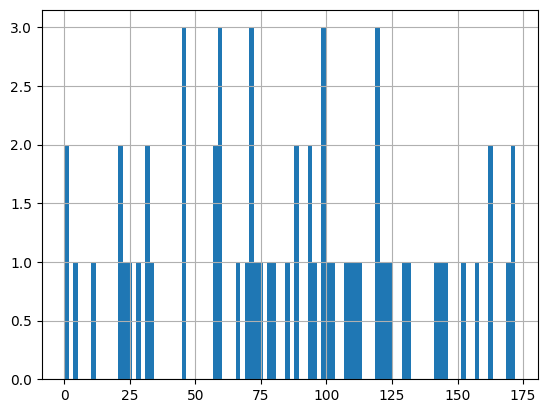

10931 , W_Afhandelen leads : 83.0
count      83.000000
mean      399.084337
std       626.108816
min         2.000000
25%       126.000000
50%       248.000000
75%       445.000000
max      5257.000000
Name: duration_seconds, dtype: float64


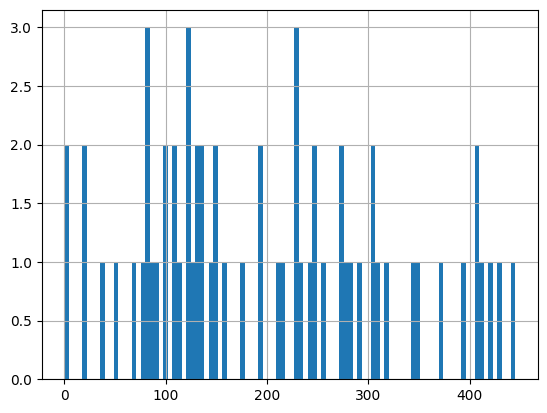

11181 , W_Afhandelen leads : 81.0
count     81.000000
mean     104.283951
std       85.608007
min        3.000000
25%       36.000000
50%       87.000000
75%      144.000000
max      431.000000
Name: duration_seconds, dtype: float64


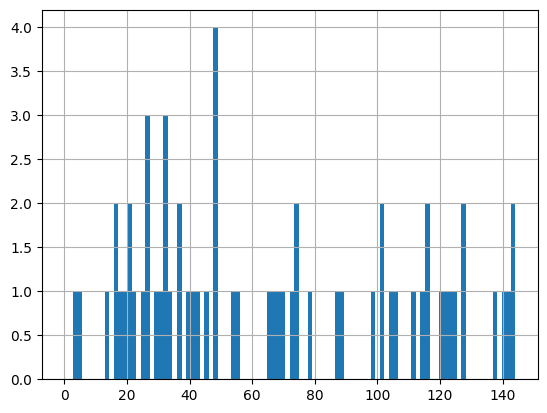

10931 , W_Nabellen offertes : 80.0
count        80.000000
mean       3145.050000
std       18770.087363
min           1.000000
25%          77.000000
50%         176.500000
75%         363.500000
max      151208.000000
Name: duration_seconds, dtype: float64


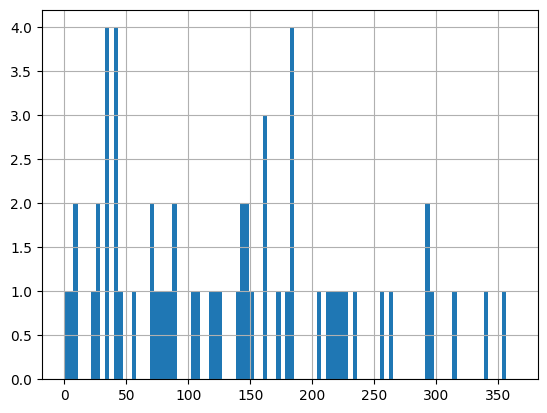

10912 , W_Afhandelen leads : 79.0
count      79.000000
mean      171.291139
std       370.153369
min         7.000000
25%        64.500000
50%        95.000000
75%       167.500000
max      3259.000000
Name: duration_seconds, dtype: float64


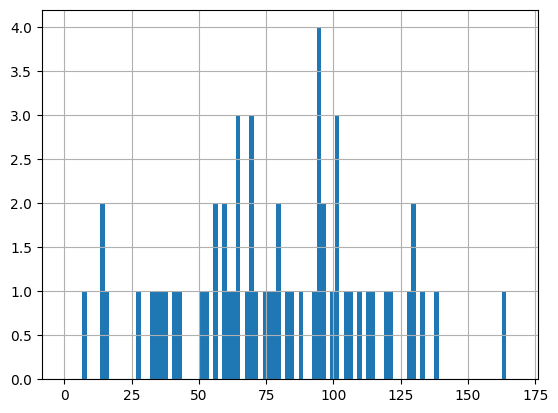

11179 , W_Afhandelen leads : 78.0
count        78.000000
mean       1901.910256
std       15823.999624
min           1.000000
25%          68.250000
50%         106.000000
75%         143.750000
max      139863.000000
Name: duration_seconds, dtype: float64


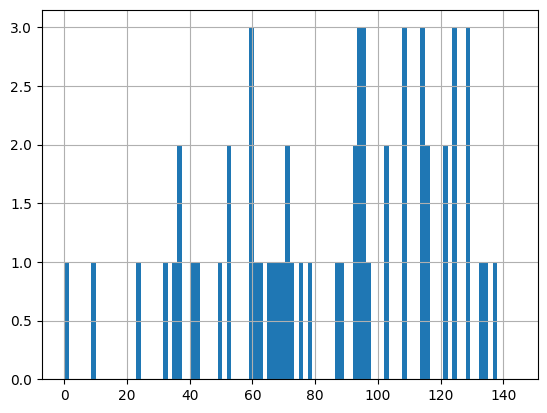

11180 , W_Afhandelen leads : 76.0
count      76.000000
mean      202.539474
std       252.747381
min         1.000000
25%        74.750000
50%       134.500000
75%       224.000000
max      1659.000000
Name: duration_seconds, dtype: float64


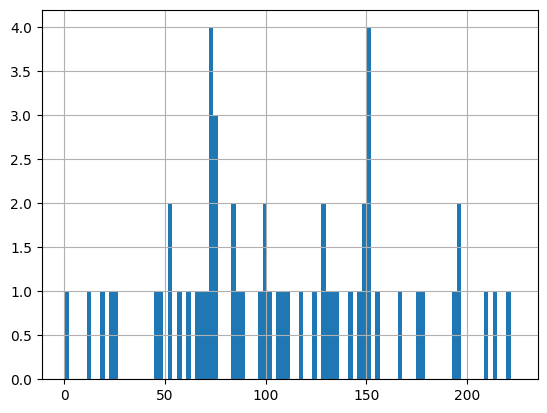

10228 , W_Completeren aanvraag : 71.0
count       71.000000
mean      4786.830986
std      14376.347056
min          6.000000
25%         16.000000
50%        176.000000
75%        770.000000
max      66005.000000
Name: duration_seconds, dtype: float64


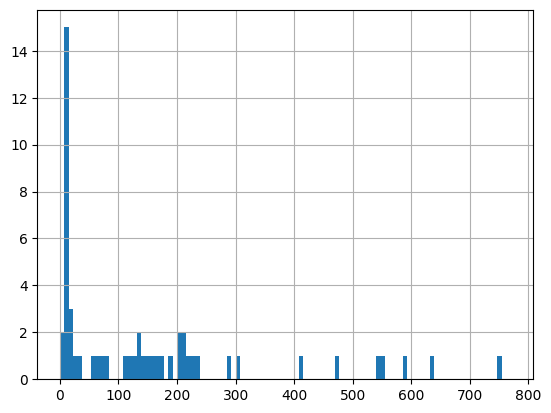

10935 , W_Afhandelen leads : 70.0
count       70.000000
mean       897.542857
std       5959.177972
min         18.000000
25%         66.000000
50%        102.000000
75%        170.000000
max      49996.000000
Name: duration_seconds, dtype: float64


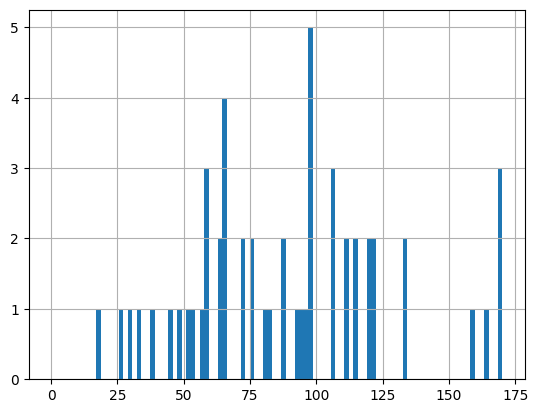

10914 , W_Nabellen offertes : 67.0
count     67.000000
mean     182.432836
std      141.738687
min       13.000000
25%      102.000000
50%      139.000000
75%      206.000000
max      753.000000
Name: duration_seconds, dtype: float64


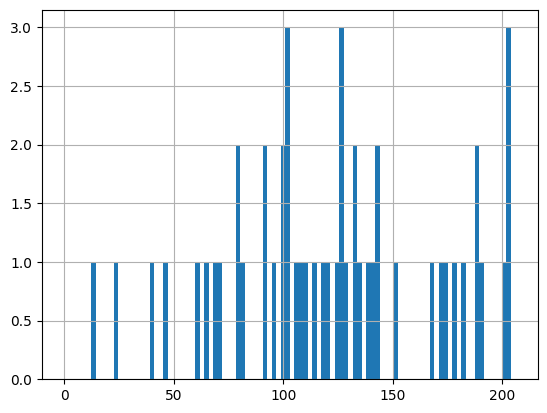

11019 , W_Nabellen offertes : 65.0
count      65.000000
mean      309.507692
std       438.834078
min         6.000000
25%       125.000000
50%       208.000000
75%       313.000000
max      3227.000000
Name: duration_seconds, dtype: float64


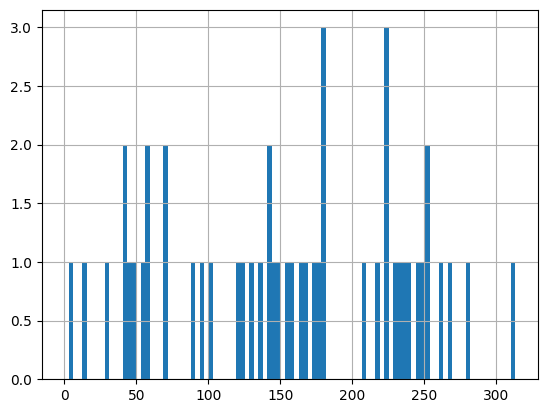

11289 , W_Nabellen incomplete dossiers : 64.0
count     64.000000
mean     101.656250
std      137.791794
min        1.000000
25%       29.500000
50%       49.000000
75%      100.000000
max      599.000000
Name: duration_seconds, dtype: float64


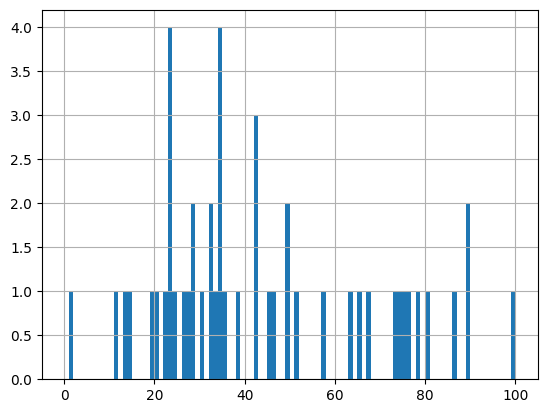

11203 , W_Nabellen incomplete dossiers : 57.0
count        57.000000
mean       3079.842105
std       20901.342051
min           1.000000
25%          69.000000
50%         196.000000
75%         431.000000
max      158089.000000
Name: duration_seconds, dtype: float64


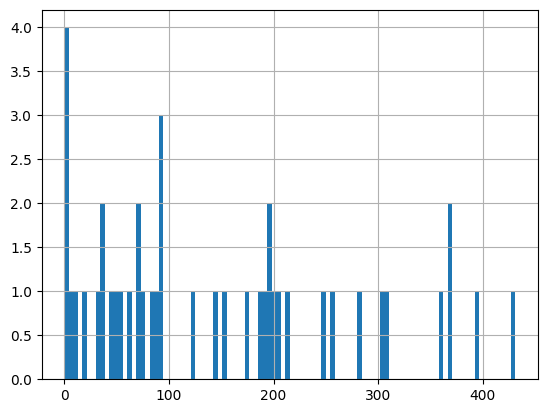

10933 , W_Afhandelen leads : 51.0
count      51.000000
mean      473.745098
std      1055.275771
min        15.000000
25%        76.000000
50%       119.000000
75%       284.500000
max      4891.000000
Name: duration_seconds, dtype: float64


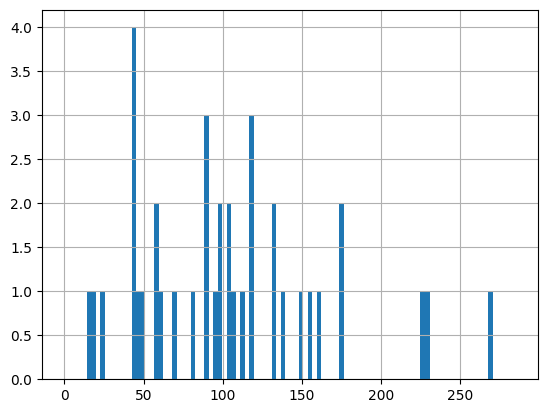

11201 , W_Afhandelen leads : 49.0
count       49.000000
mean      2076.612245
std       8912.362247
min          7.000000
25%        107.000000
50%        172.000000
75%        328.000000
max      48500.000000
Name: duration_seconds, dtype: float64


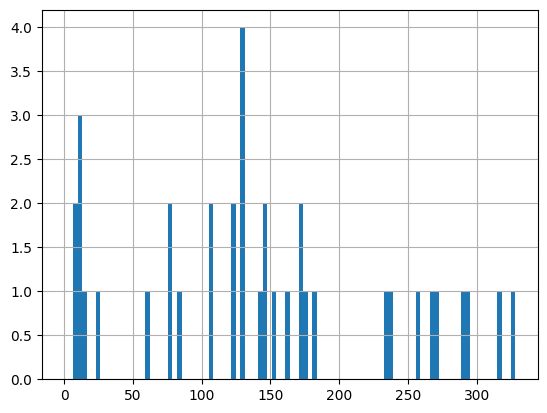

10629 , W_Nabellen offertes : 44.0
count      44.000000
mean      122.113636
std       345.727222
min        10.000000
25%        13.000000
50%        18.500000
75%        30.750000
max      1745.000000
Name: duration_seconds, dtype: float64


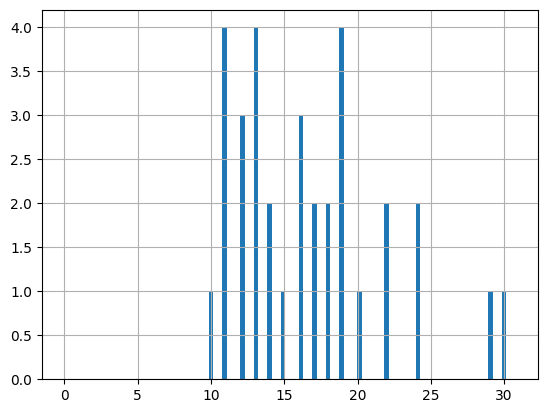

11049 , W_Valideren aanvraag : 43.0
count      43.000000
mean       97.581395
std       264.891913
min         7.000000
25%        15.000000
50%        40.000000
75%        68.500000
max      1729.000000
Name: duration_seconds, dtype: float64


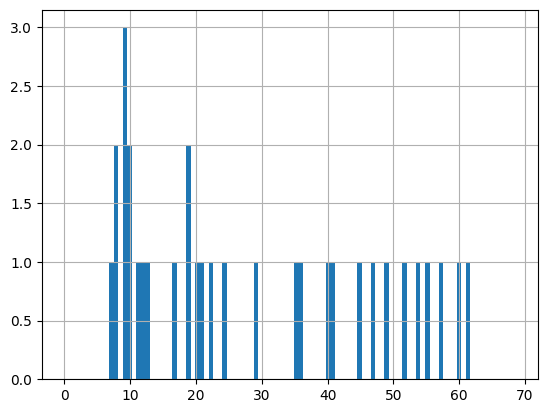

10914 , W_Completeren aanvraag : 40.0
count       40.000000
mean      1625.600000
std       7957.754044
min         62.000000
25%        140.500000
50%        221.000000
75%        559.000000
max      50644.000000
Name: duration_seconds, dtype: float64


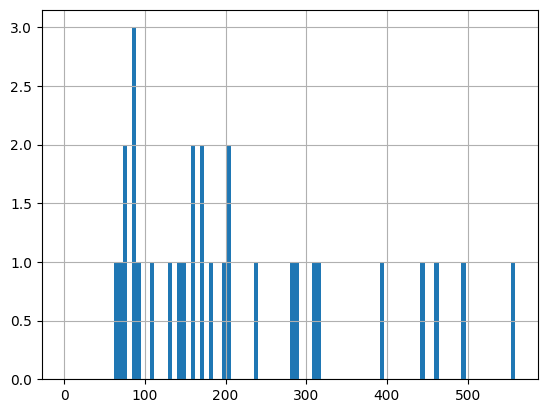

11169 , W_Valideren aanvraag : 38.0
count      38.000000
mean      545.973684
std      1339.140375
min         6.000000
25%        89.750000
50%       145.500000
75%       329.500000
max      7436.000000
Name: duration_seconds, dtype: float64


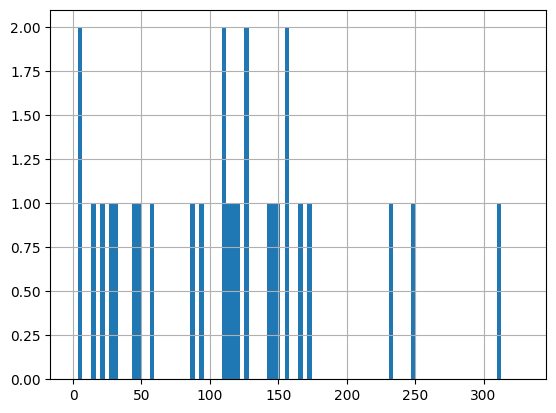

11001 , W_Completeren aanvraag : 37.0
count     37.000000
mean     270.108108
std      255.442947
min        1.000000
25%       68.000000
50%      204.000000
75%      475.000000
max      928.000000
Name: duration_seconds, dtype: float64


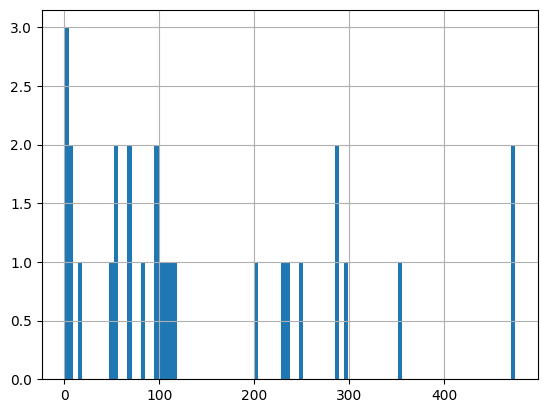

10629 , W_Completeren aanvraag : 37.0
count     37.000000
mean     488.459459
std      256.355287
min        9.000000
25%      316.000000
50%      544.000000
75%      683.000000
max      980.000000
Name: duration_seconds, dtype: float64


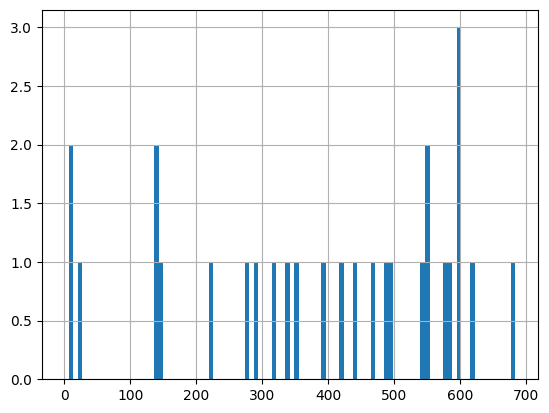

10914 , W_Nabellen incomplete dossiers : 37.0
count       37.000000
mean      1044.702703
std       2232.299660
min          1.000000
25%        160.000000
50%        355.000000
75%        884.000000
max      12279.000000
Name: duration_seconds, dtype: float64


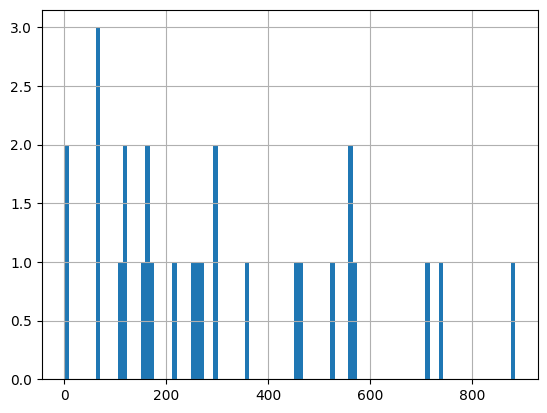

10809 , W_Beoordelen fraude : 36.0
count     36.000000
mean      41.277778
std       59.774152
min        1.000000
25%       10.000000
50%       14.500000
75%       30.000000
max      204.000000
Name: duration_seconds, dtype: float64


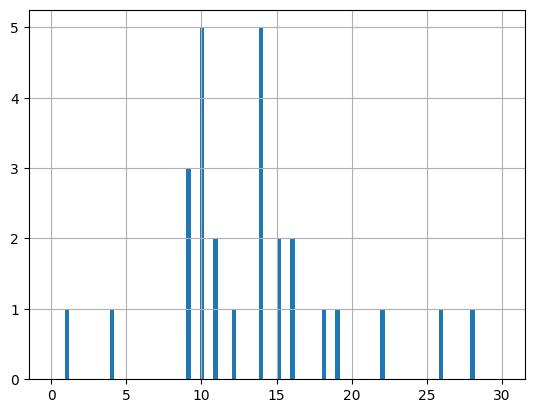

11001 , W_Afhandelen leads : 35.0
count     35.000000
mean     124.314286
std       76.913539
min        6.000000
25%       92.500000
50%      109.000000
75%      147.500000
max      352.000000
Name: duration_seconds, dtype: float64


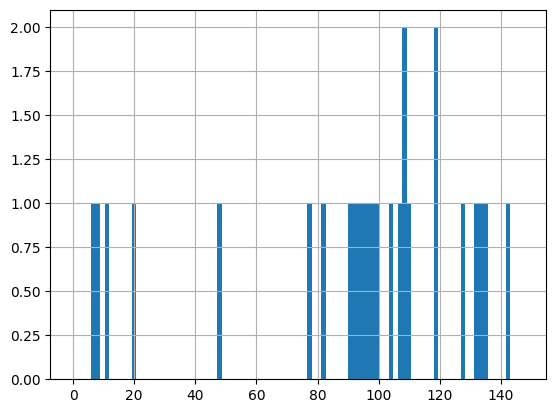

10972 , W_Nabellen offertes : 33.0
count        33.000000
mean       6760.939394
std       38484.972633
min          12.000000
25%          17.000000
50%          22.000000
75%          29.000000
max      221139.000000
Name: duration_seconds, dtype: float64


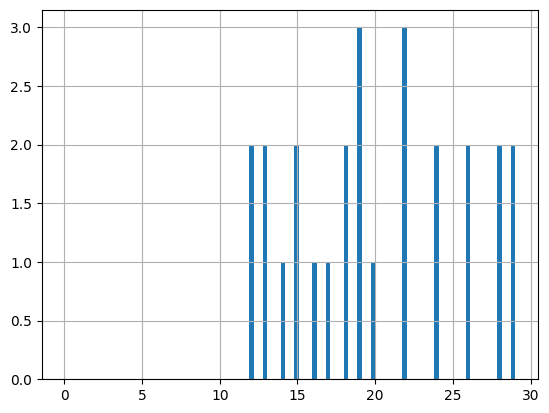

10899 , W_Valideren aanvraag : 32.0
count       32.000000
mean      2236.656250
std      12161.645924
min          1.000000
25%         21.000000
50%         33.500000
75%         78.250000
max      68879.000000
Name: duration_seconds, dtype: float64


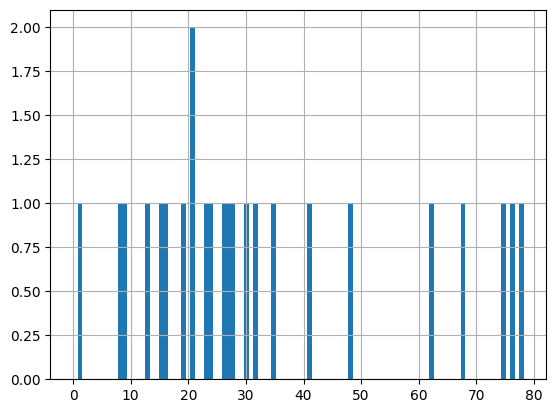

10933 , W_Nabellen incomplete dossiers : 30.0
count       30.000000
mean       821.466667
std       2161.143834
min          1.000000
25%         30.250000
50%        229.500000
75%        792.500000
max      11974.000000
Name: duration_seconds, dtype: float64


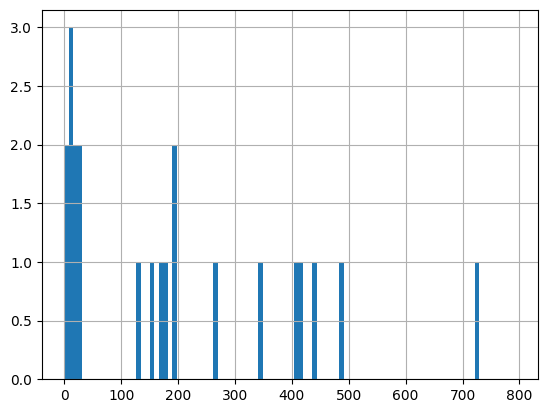

11019 , W_Afhandelen leads : 30.0
count     30.000000
mean     164.233333
std      142.298056
min       38.000000
25%       72.750000
50%      135.500000
75%      176.750000
max      733.000000
Name: duration_seconds, dtype: float64


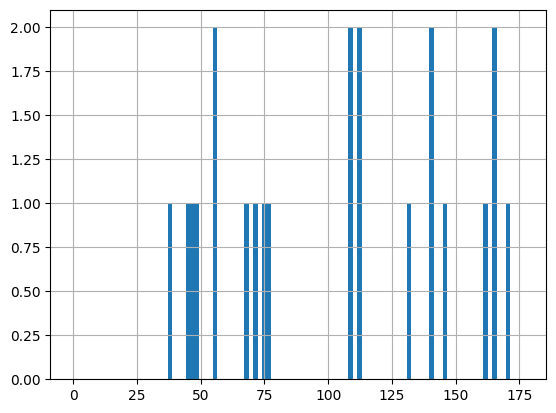

10861 , W_Valideren aanvraag : 29.0
count     29.000000
mean     100.793103
std      157.417865
min        1.000000
25%       12.000000
50%       46.000000
75%      109.000000
max      637.000000
Name: duration_seconds, dtype: float64


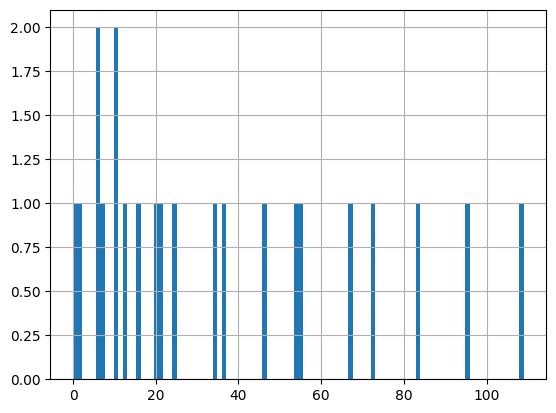

10935 , W_Completeren aanvraag : 29.0
count      29.000000
mean      776.517241
std      1226.829235
min        11.000000
25%       179.000000
50%       466.000000
75%       624.000000
max      5945.000000
Name: duration_seconds, dtype: float64


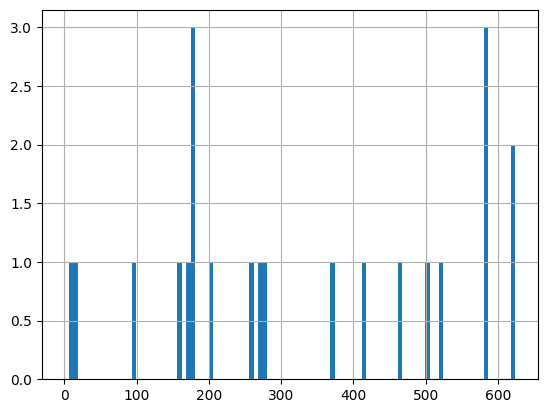

10138 , W_Nabellen offertes : 28.0
count      28.000000
mean      187.142857
std       366.271981
min        10.000000
25%        15.750000
50%        23.500000
75%        80.750000
max      1398.000000
Name: duration_seconds, dtype: float64


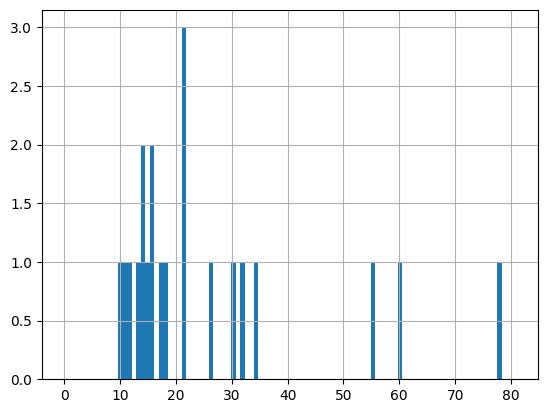

10809 , W_Nabellen offertes : 28.0
count      28.000000
mean      356.285714
std       430.974766
min         1.000000
25%       113.250000
50%       198.500000
75%       370.500000
max      1818.000000
Name: duration_seconds, dtype: float64


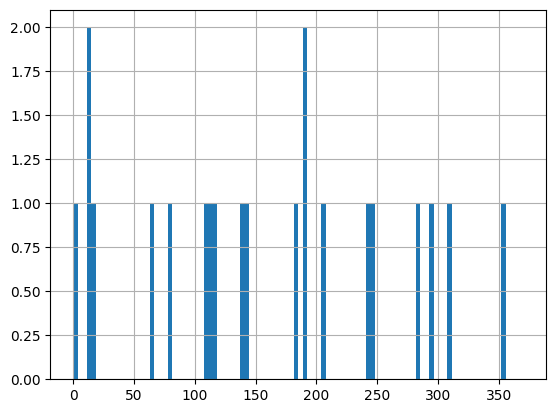

11259 , W_Valideren aanvraag : 23.0
count     23.000000
mean     137.217391
std      161.914106
min       11.000000
25%       24.500000
50%       66.000000
75%      207.500000
max      526.000000
Name: duration_seconds, dtype: float64


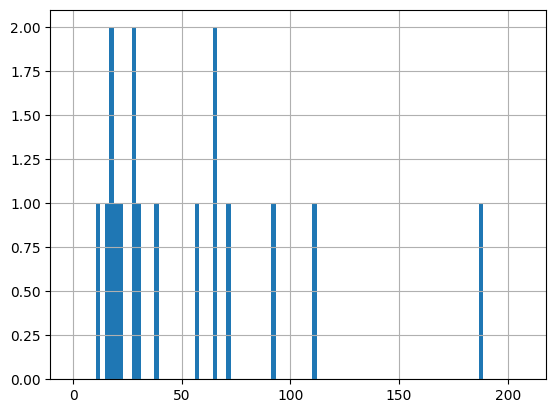

10909 , W_Valideren aanvraag : 23.0
count     23.000000
mean      91.826087
std      105.876709
min        5.000000
25%       32.500000
50%       43.000000
75%       85.000000
max      396.000000
Name: duration_seconds, dtype: float64


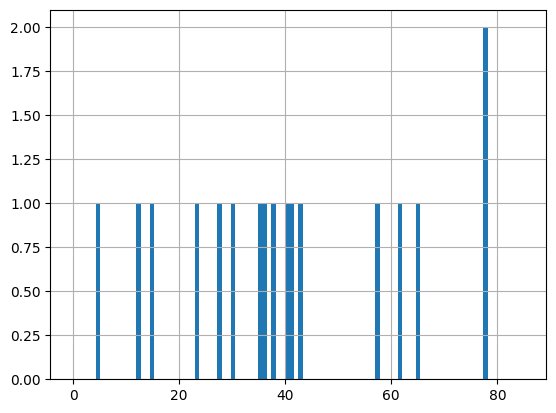

10609 , W_Completeren aanvraag : 21.0
count     21.00000
mean      57.47619
std       61.52692
min        6.00000
25%       11.00000
50%       36.00000
75%       78.00000
max      231.00000
Name: duration_seconds, dtype: float64


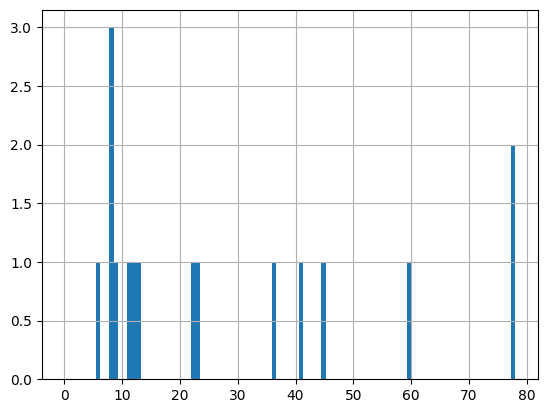

10809 , W_Completeren aanvraag : 20.0
count      20.000000
mean      660.700000
std       983.049771
min        11.000000
25%        47.000000
50%       232.500000
75%       602.250000
max      3526.000000
Name: duration_seconds, dtype: float64


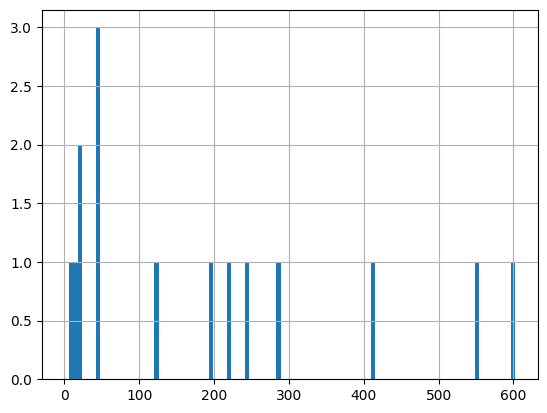

11002 , W_Afhandelen leads : 18.0
count      18.000000
mean      696.388889
std       895.272692
min         7.000000
25%       143.250000
50%       469.500000
75%       778.000000
max      3839.000000
Name: duration_seconds, dtype: float64


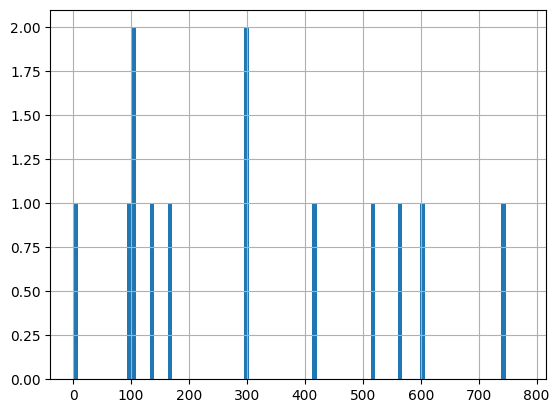

10809 , W_Afhandelen leads : 18.0
count     18.000000
mean     125.944444
std      158.360524
min        7.000000
25%       11.750000
50%       73.500000
75%      158.750000
max      647.000000
Name: duration_seconds, dtype: float64


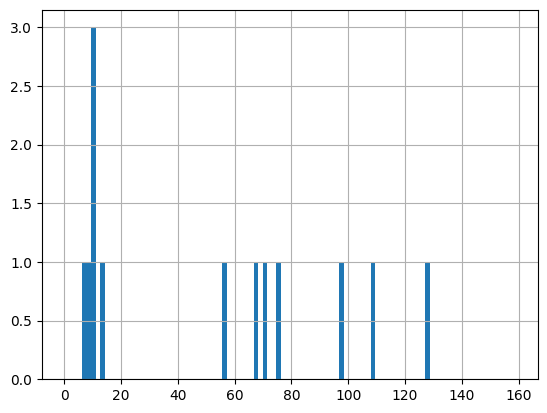

10609 , W_Afhandelen leads : 18.0
count       18.000000
mean      2149.555556
std       8141.825429
min          1.000000
25%         27.500000
50%        127.000000
75%        369.250000
max      34752.000000
Name: duration_seconds, dtype: float64


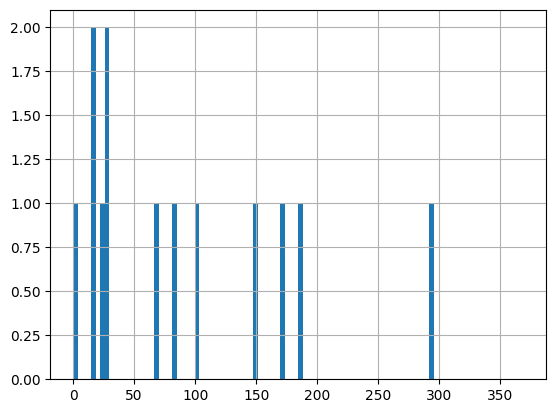

11304 , W_Beoordelen fraude : 18.0
count       18.000000
mean      7675.000000
std      21633.450063
min          1.000000
25%         11.000000
50%         23.500000
75%        269.250000
max      76417.000000
Name: duration_seconds, dtype: float64


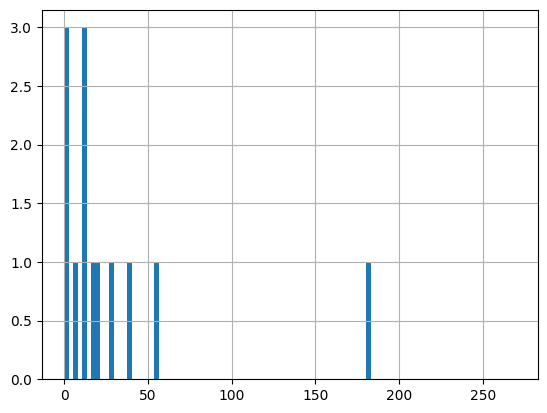

10779 , W_Completeren aanvraag : 17.0
count      17.000000
mean      237.941176
std       337.415632
min         1.000000
25%        26.000000
50%        81.000000
75%       282.000000
max      1180.000000
Name: duration_seconds, dtype: float64


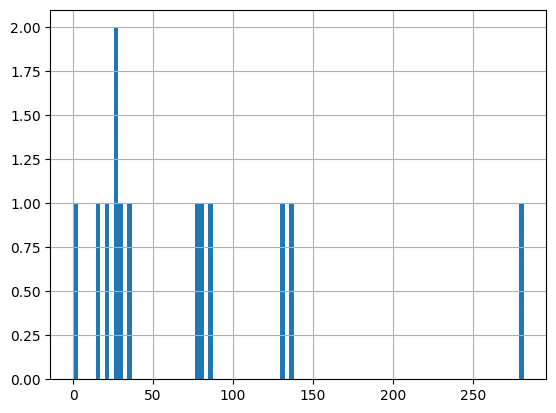

10982 , W_Valideren aanvraag : 17.0
count        17.000000
mean      10024.352941
std       32975.212410
min           1.000000
25%           8.000000
50%          70.000000
75%         365.000000
max      134141.000000
Name: duration_seconds, dtype: float64


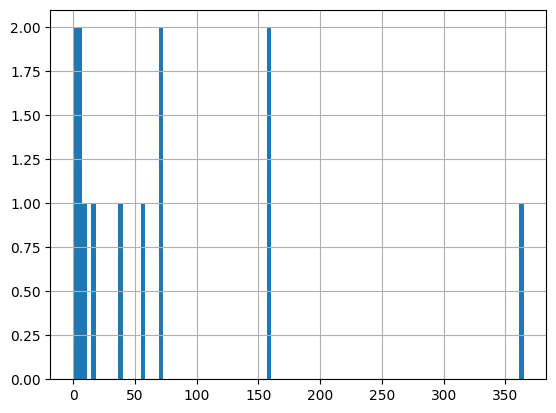

11049 , W_Completeren aanvraag : 15.0
count     15.000000
mean     154.866667
std      128.255808
min        7.000000
25%       55.500000
50%      100.000000
75%      249.000000
max      382.000000
Name: duration_seconds, dtype: float64


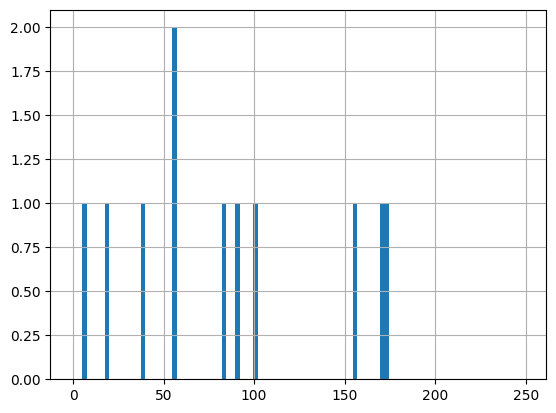

11302 , W_Nabellen incomplete dossiers : 15.0
count      15.000000
mean      445.200000
std       633.090064
min         1.000000
25%       113.500000
50%       174.000000
75%       522.000000
max      2406.000000
Name: duration_seconds, dtype: float64


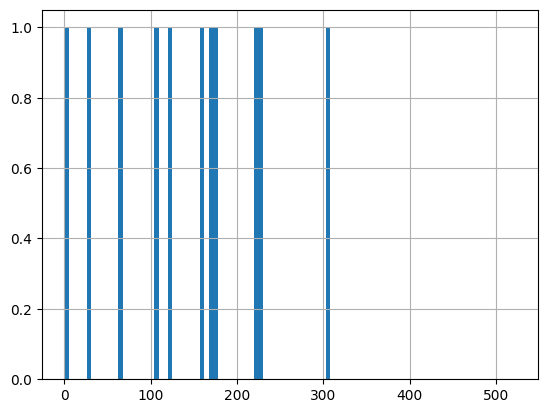

11180 , W_Valideren aanvraag : 14.0
count    14.000000
mean     15.142857
std      17.037773
min       6.000000
25%       7.000000
50%      10.000000
75%      10.750000
max      64.000000
Name: duration_seconds, dtype: float64


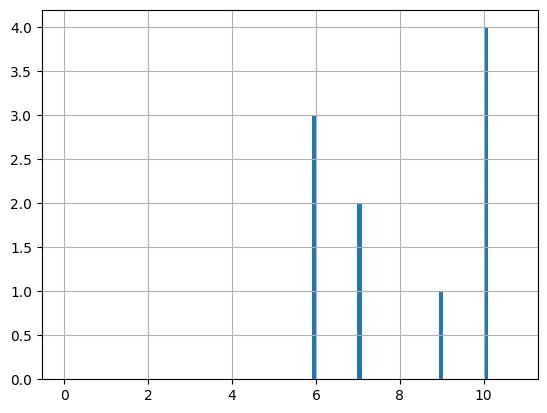

11339 , W_Valideren aanvraag : 14.0
count      14.000000
mean     1006.142857
std       658.625008
min         5.000000
25%       639.500000
50%       878.000000
75%      1176.250000
max      2428.000000
Name: duration_seconds, dtype: float64


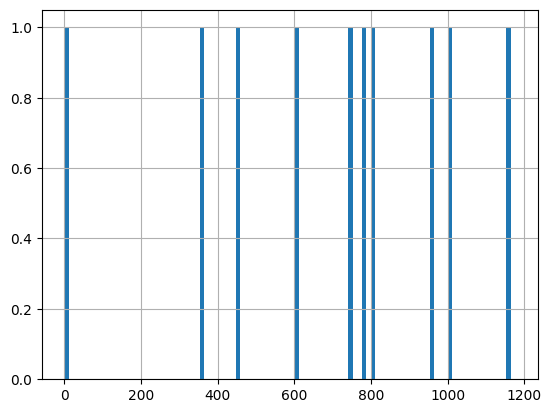

10929 , W_Valideren aanvraag : 14.0
count     14.000000
mean     227.642857
std      230.784151
min       21.000000
25%       71.000000
50%      112.500000
75%      273.750000
max      719.000000
Name: duration_seconds, dtype: float64


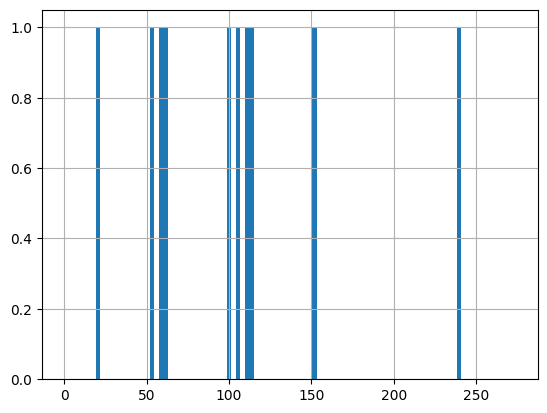

10932 , W_Valideren aanvraag : 13.0
count      13.000000
mean      448.000000
std       780.571265
min        12.000000
25%        52.000000
50%       105.000000
75%       290.000000
max      2727.000000
Name: duration_seconds, dtype: float64


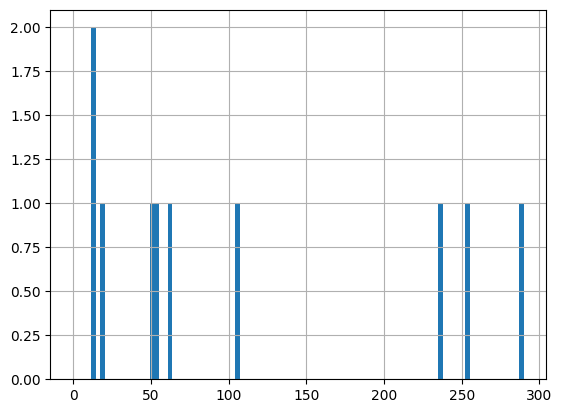

10913 , W_Valideren aanvraag : 13.0
count     13.000000
mean     107.076923
std      175.773273
min        1.000000
25%        7.000000
50%        8.000000
75%      112.000000
max      473.000000
Name: duration_seconds, dtype: float64


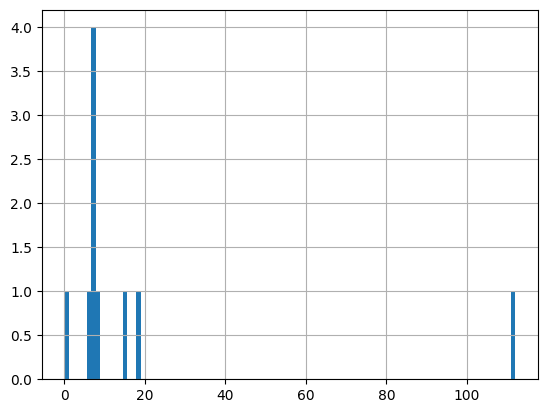

11181 , W_Valideren aanvraag : 12.0
count     12.000000
mean     127.416667
std      119.396557
min       30.000000
25%       40.000000
50%       72.500000
75%      178.250000
max      360.000000
Name: duration_seconds, dtype: float64


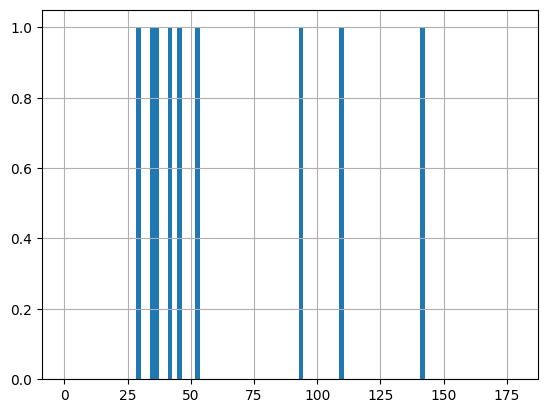

10138 , W_Completeren aanvraag : 12.0
count      12.000000
mean      531.166667
std       591.672488
min        49.000000
25%       173.750000
50%       261.000000
75%       762.500000
max      1997.000000
Name: duration_seconds, dtype: float64


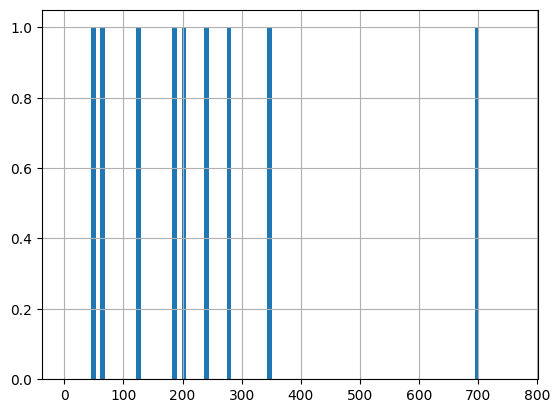

11302 , W_Afhandelen leads : 12.0
count       12.00000
mean      1953.50000
std       5711.80738
min          6.00000
25%        183.75000
50%        242.50000
75%        523.25000
max      20077.00000
Name: duration_seconds, dtype: float64


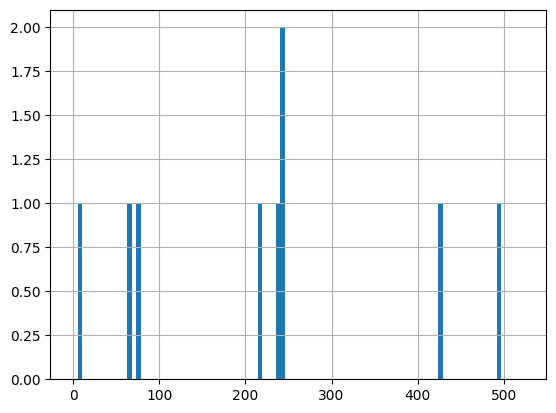

11122 , W_Valideren aanvraag : 10.0
count     10.000000
mean     185.300000
std      206.453681
min        9.000000
25%       34.000000
50%      104.000000
75%      237.000000
max      583.000000
Name: duration_seconds, dtype: float64


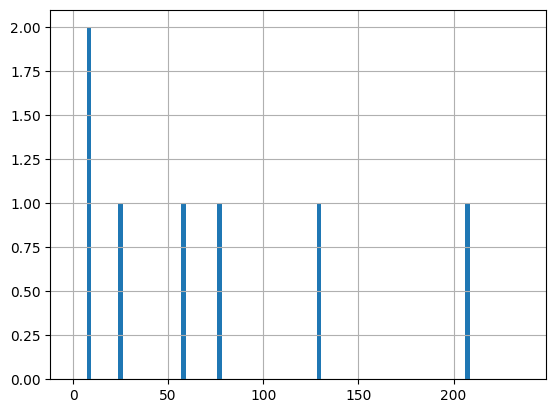

11001 , W_Nabellen offertes : 9.0
count      9.000000
mean     141.111111
std      179.707015
min        2.000000
25%       25.000000
50%       54.000000
75%      257.000000
max      534.000000
Name: duration_seconds, dtype: float64


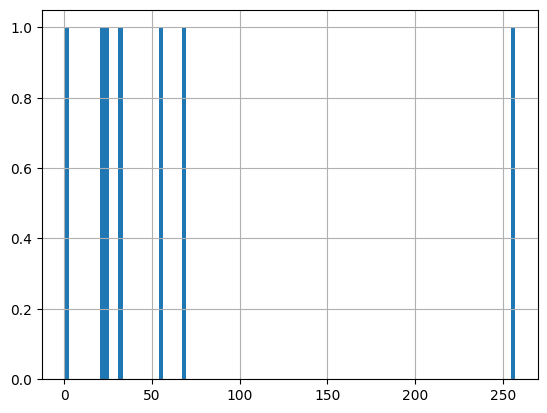

10779 , W_Valideren aanvraag : 9.0
count        9.000000
mean      6245.777778
std      16283.017808
min         28.000000
25%        105.000000
50%        118.000000
75%       2583.000000
max      49541.000000
Name: duration_seconds, dtype: float64


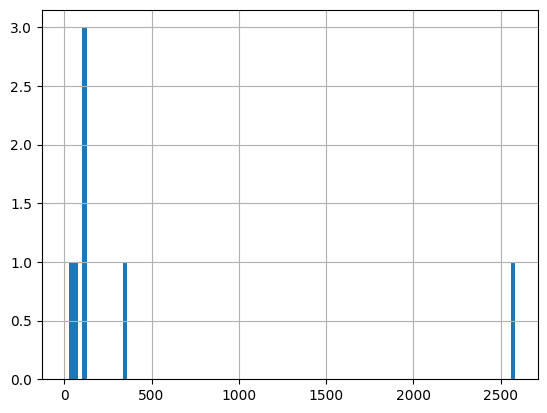

10912 , W_Valideren aanvraag : 8.0
count        8.000000
mean      2129.500000
std       3639.978336
min        153.000000
25%        267.500000
50%        709.000000
75%       1666.000000
max      10889.000000
Name: duration_seconds, dtype: float64


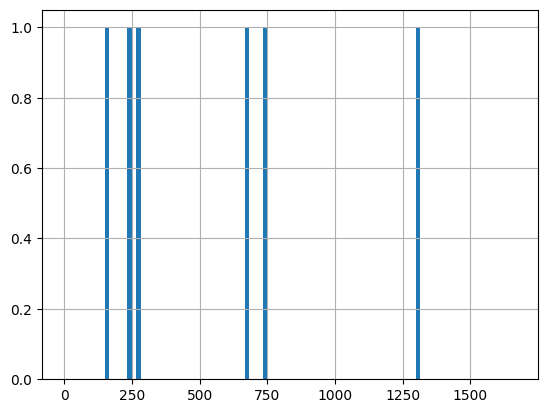

10881 , W_Valideren aanvraag : 8.0
count      8.000000
mean     151.500000
std      169.155043
min       23.000000
25%       48.500000
50%       86.500000
75%      165.750000
max      511.000000
Name: duration_seconds, dtype: float64


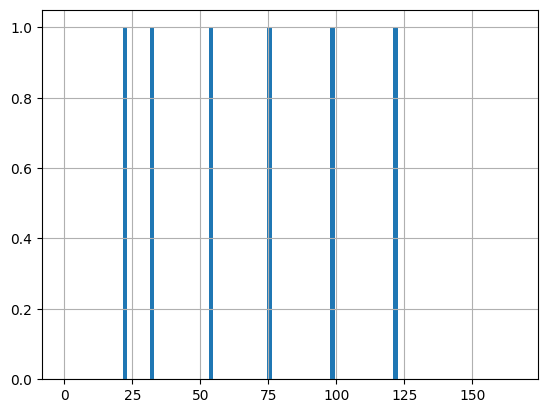

11289 , W_Nabellen offertes : 8.0
count      8.000000
mean      90.750000
std      126.590171
min       15.000000
25%       21.500000
50%       32.000000
75%       84.250000
max      372.000000
Name: duration_seconds, dtype: float64


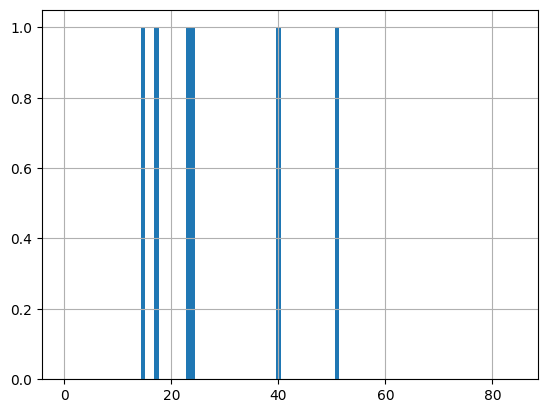

10972 , W_Completeren aanvraag : 8.0
count      8.000000
mean     274.875000
std      148.284897
min      106.000000
25%      166.500000
50%      226.500000
75%      404.000000
max      502.000000
Name: duration_seconds, dtype: float64


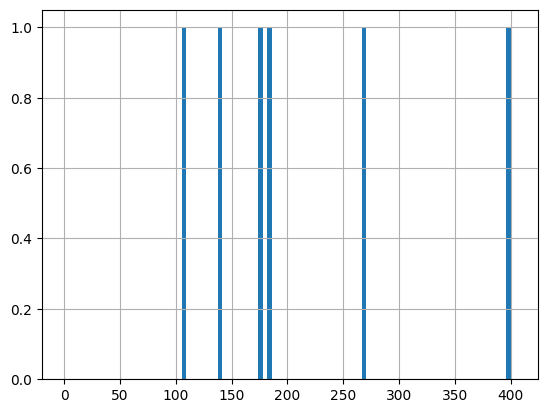

11003 , W_Valideren aanvraag : 8.0
count      8.000000
mean      39.625000
std       38.994276
min        8.000000
25%       14.000000
50%       23.500000
75%       49.250000
max      119.000000
Name: duration_seconds, dtype: float64


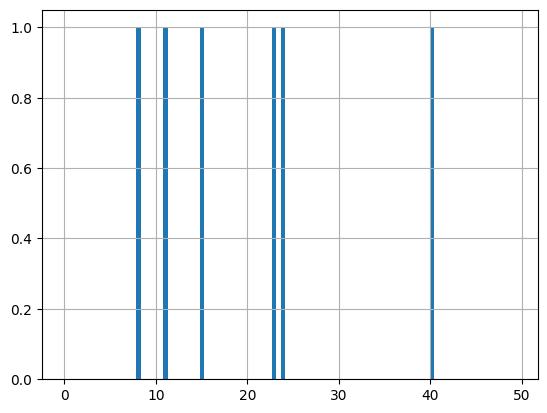

11009 , W_Valideren aanvraag : 8.0
count      8.000000
mean     256.250000
std      297.981663
min       15.000000
25%       74.500000
50%      128.000000
75%      332.750000
max      764.000000
Name: duration_seconds, dtype: float64


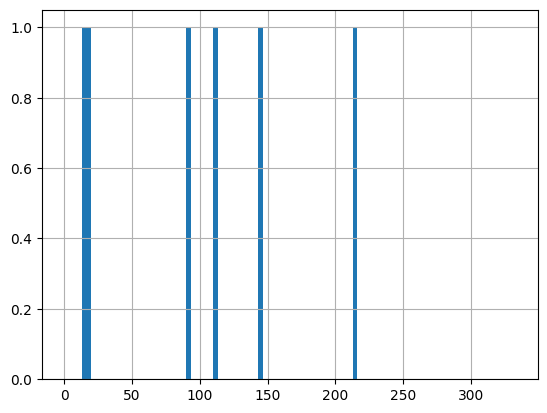

10228 , W_Nabellen incomplete dossiers : 7.0
count        7.000000
mean     12383.857143
std      23808.184436
min         24.000000
25%        148.000000
50%        803.000000
75%      10413.500000
max      64737.000000
Name: duration_seconds, dtype: float64


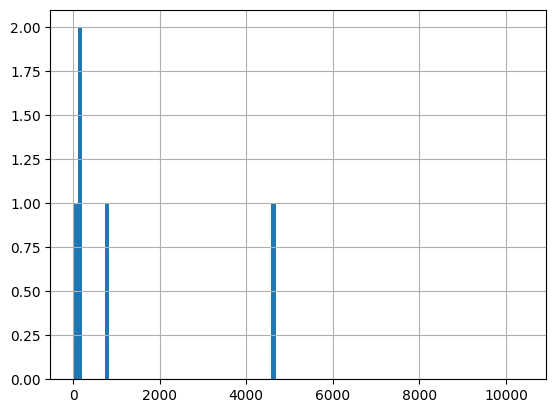

10972 , W_Afhandelen leads : 7.0
count      7.000000
mean     214.571429
std      198.241315
min       22.000000
25%       86.000000
50%      156.000000
75%      276.000000
max      600.000000
Name: duration_seconds, dtype: float64


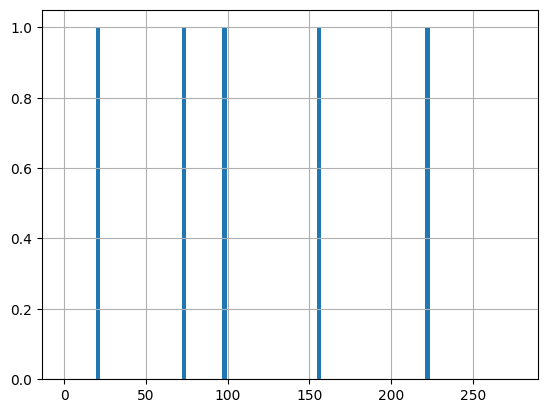

10889 , W_Valideren aanvraag : 7.0
count      7.000000
mean      76.714286
std       80.663321
min        9.000000
25%       17.500000
50%       68.000000
75%       94.500000
max      236.000000
Name: duration_seconds, dtype: float64


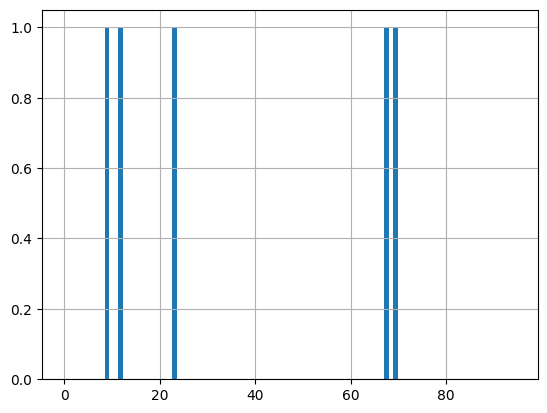

10789 , W_Valideren aanvraag : 6.0
count     6.000000
mean     23.500000
std      10.968136
min      11.000000
25%      17.250000
50%      19.500000
75%      32.250000
max      38.000000
Name: duration_seconds, dtype: float64


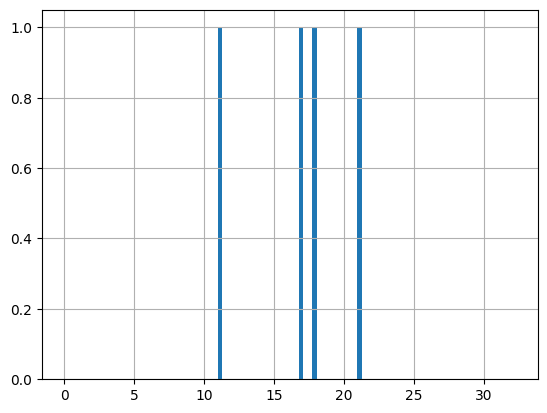

11259 , W_Afhandelen leads : 6.0
count      6.000000
mean     111.333333
std      145.127071
min        7.000000
25%       16.000000
50%       28.500000
75%      196.250000
max      340.000000
Name: duration_seconds, dtype: float64


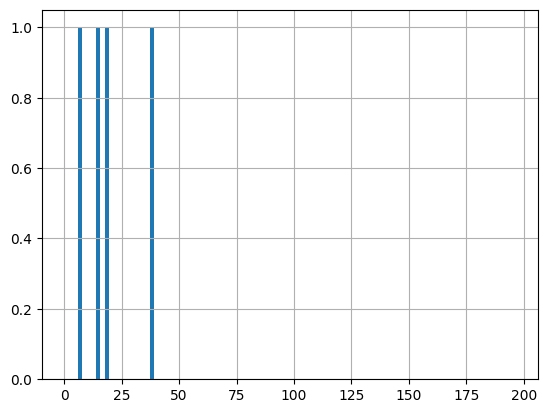

11299 , W_Nabellen incomplete dossiers : 6.0
count      6.000000
mean     151.666667
std      154.966663
min       16.000000
25%       53.000000
50%       81.000000
75%      234.250000
max      403.000000
Name: duration_seconds, dtype: float64


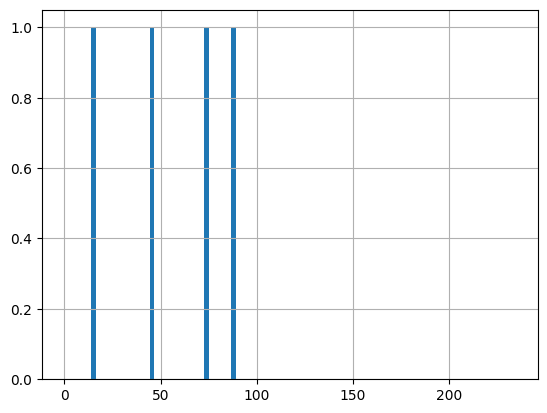

10935 , W_Valideren aanvraag : 6.0
count       6.000000
mean      488.000000
std       977.913902
min        35.000000
25%        42.250000
50%        87.500000
75%       180.000000
max      2480.000000
Name: duration_seconds, dtype: float64


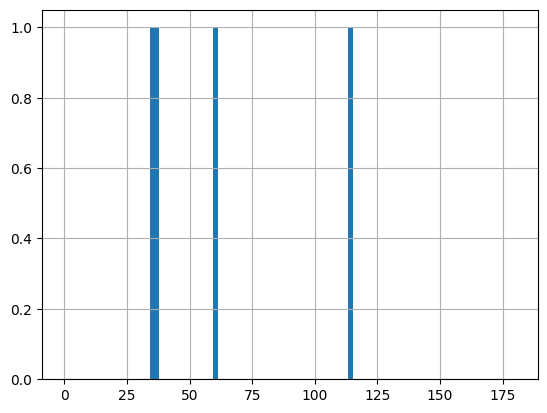

11079 , W_Completeren aanvraag : 6.0
count        6.000000
mean     53877.333333
std       1508.367285
min      51228.000000
25%      53299.750000
50%      54518.500000
75%      54853.000000
max      55141.000000
Name: duration_seconds, dtype: float64


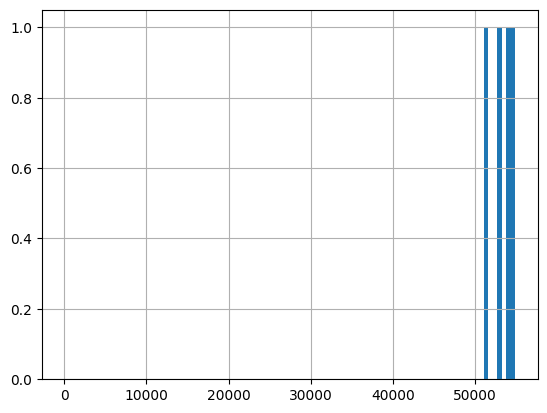

10228 , W_Valideren aanvraag : 6.0
count      6.000000
mean     126.500000
std      109.924974
min       17.000000
25%       40.250000
50%       95.000000
75%      220.250000
max      268.000000
Name: duration_seconds, dtype: float64


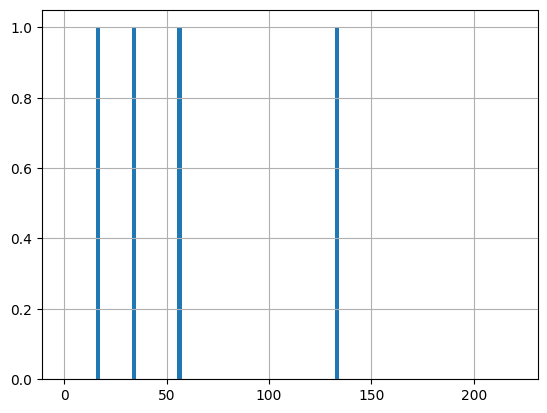

11119 , W_Valideren aanvraag : 5.0
count      5.000000
mean      40.000000
std       44.424093
min        6.000000
25%        8.000000
50%       12.000000
75%       71.000000
max      103.000000
Name: duration_seconds, dtype: float64


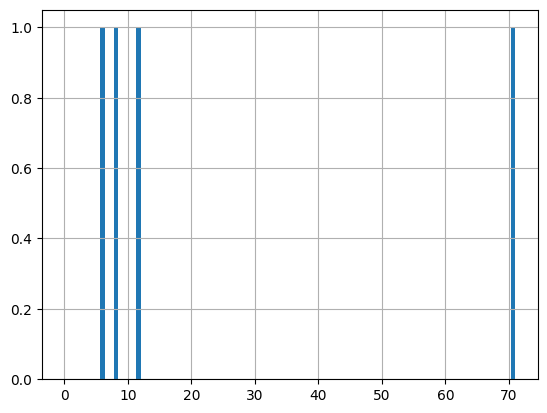

10899 , W_Completeren aanvraag : 5.0
count         5.00000
mean      49012.00000
std      109410.25101
min          46.00000
25%          73.00000
50%          83.00000
75%         127.00000
max      244731.00000
Name: duration_seconds, dtype: float64


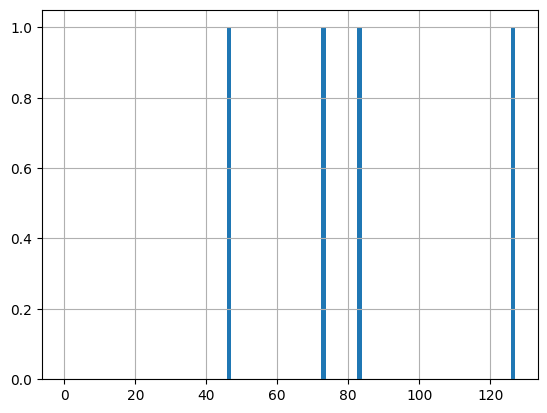

11121 , W_Valideren aanvraag : 5.0
count      5.000000
mean      59.000000
std       44.062456
min        7.000000
25%       22.000000
50%       73.000000
75%       78.000000
max      115.000000
Name: duration_seconds, dtype: float64


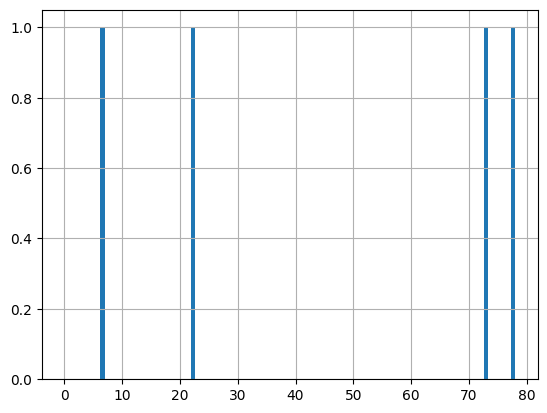

11309 , W_Nabellen incomplete dossiers : 5.0
count       5.000000
mean      420.600000
std       449.846974
min        85.000000
25%       208.000000
50%       276.000000
75%       325.000000
max      1209.000000
Name: duration_seconds, dtype: float64


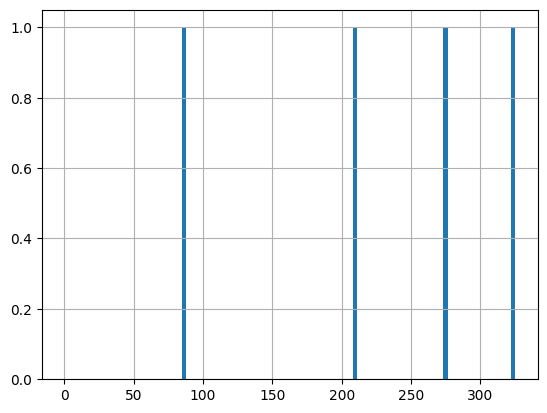

11300 , W_Nabellen incomplete dossiers : 5.0
count      5.000000
mean     122.600000
std       71.661008
min       33.000000
25%       88.000000
50%      110.000000
75%      161.000000
max      221.000000
Name: duration_seconds, dtype: float64


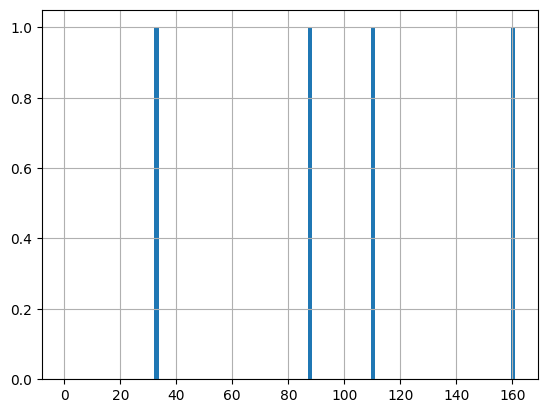

10910 , W_Valideren aanvraag : 5.0
count      5.000000
mean      72.400000
std       71.304278
min        6.000000
25%       39.000000
50%       50.000000
75%       75.000000
max      192.000000
Name: duration_seconds, dtype: float64


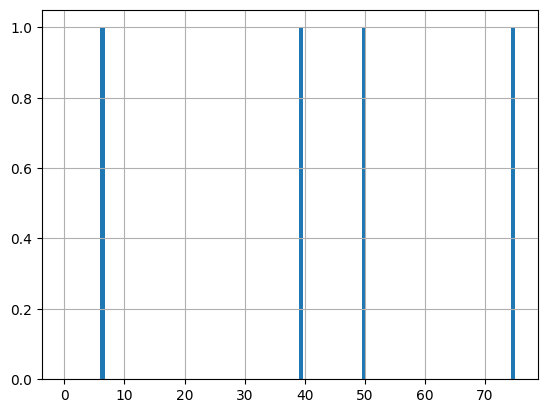

11300 , W_Valideren aanvraag : 4.0
count      4.00000
mean     126.75000
std       70.51891
min       48.00000
25%       85.50000
50%      123.00000
75%      164.25000
max      213.00000
Name: duration_seconds, dtype: float64


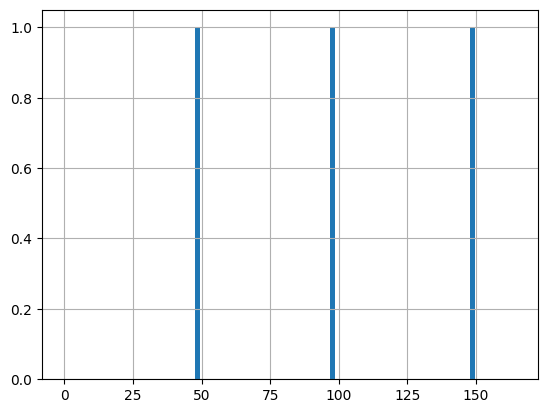

11079 , W_Nabellen incomplete dossiers : 4.0
count       4.000000
mean     1014.500000
std      1844.946341
min        16.000000
25%        43.000000
50%       131.500000
75%      1103.000000
max      3779.000000
Name: duration_seconds, dtype: float64


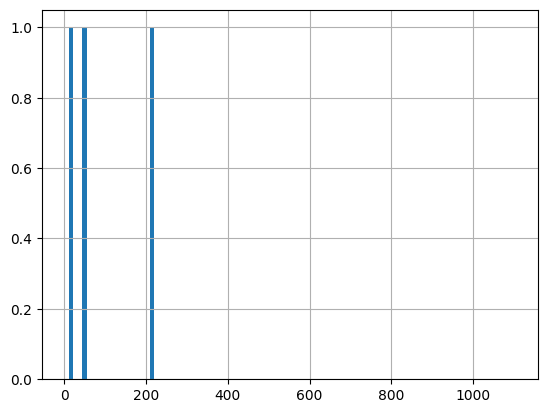

10228 , W_Nabellen offertes : 4.0
count      4.00000
mean     539.75000
std      391.64046
min       83.00000
25%      282.50000
50%      580.00000
75%      837.25000
max      916.00000
Name: duration_seconds, dtype: float64


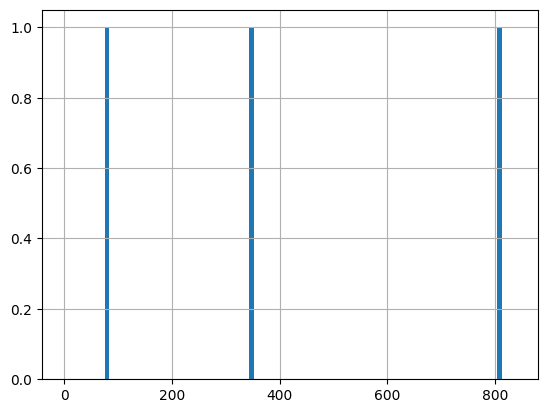

10138 , W_Afhandelen leads : 4.0
count       4.000000
mean      500.250000
std       725.377316
min        72.000000
25%       141.000000
50%       171.500000
75%       530.750000
max      1586.000000
Name: duration_seconds, dtype: float64


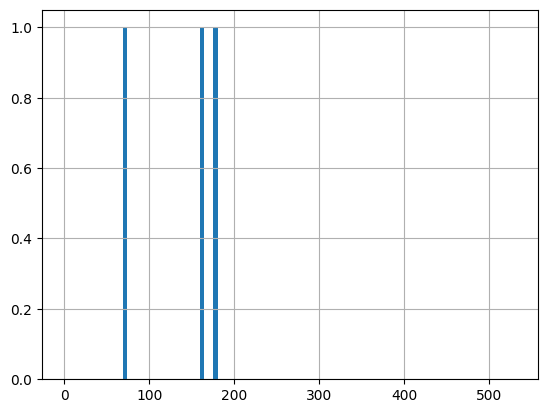

10863 , W_Valideren aanvraag : 4.0
count      4.000000
mean     143.000000
std      158.246643
min        1.000000
25%        8.500000
50%      145.500000
75%      280.000000
max      280.000000
Name: duration_seconds, dtype: float64


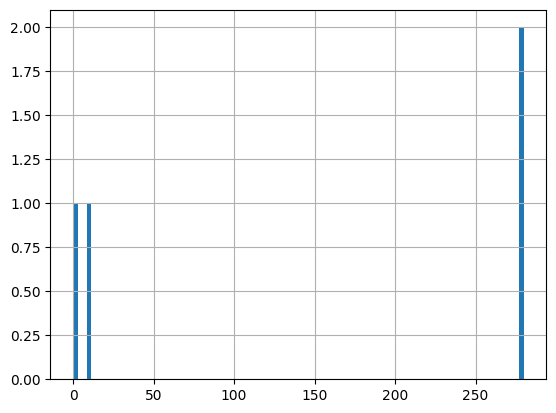

10779 , W_Nabellen offertes : 4.0
count     4.000000
mean     36.250000
std      22.588714
min      19.000000
25%      22.750000
50%      28.500000
75%      42.000000
max      69.000000
Name: duration_seconds, dtype: float64


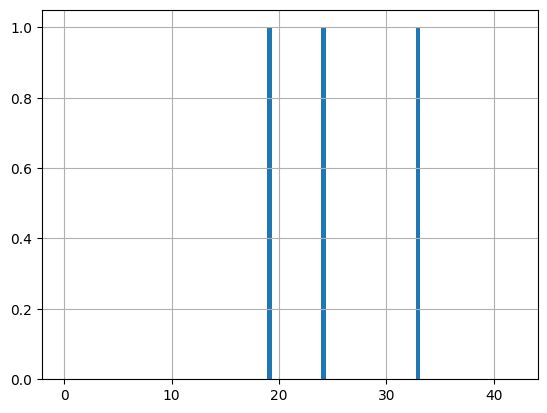

10914 , W_Afhandelen leads : 4.0
count      4.000000
mean     269.500000
std      218.202505
min       96.000000
25%      126.750000
50%      202.000000
75%      344.750000
max      578.000000
Name: duration_seconds, dtype: float64


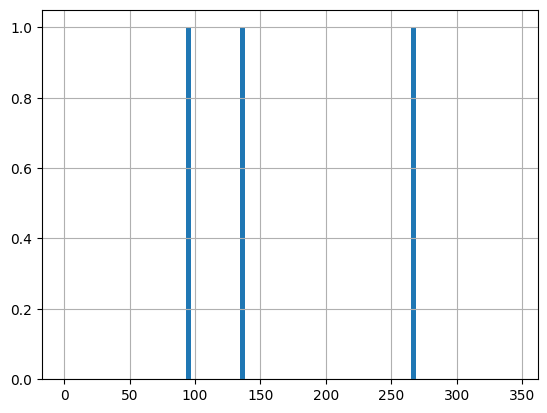

11079 , W_Valideren aanvraag : 3.0
count         3.000000
mean     104363.333333
std      121787.122818
min         179.000000
25%       37417.000000
50%       74655.000000
75%      156455.500000
max      238256.000000
Name: duration_seconds, dtype: float64


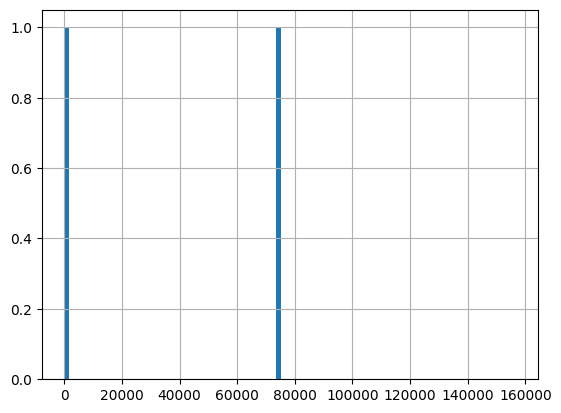

10779 , W_Beoordelen fraude : 3.0
count     3.000000
mean     19.333333
std       3.785939
min      15.000000
25%      18.000000
50%      21.000000
75%      21.500000
max      22.000000
Name: duration_seconds, dtype: float64


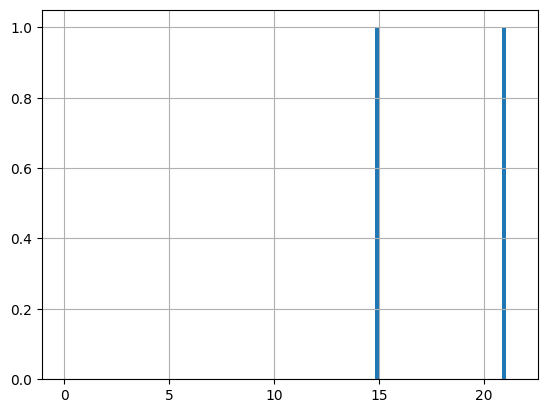

11319 , W_Nabellen incomplete dossiers : 2.0
count      2.000000
mean     397.000000
std      534.572727
min       19.000000
25%      208.000000
50%      397.000000
75%      586.000000
max      775.000000
Name: duration_seconds, dtype: float64


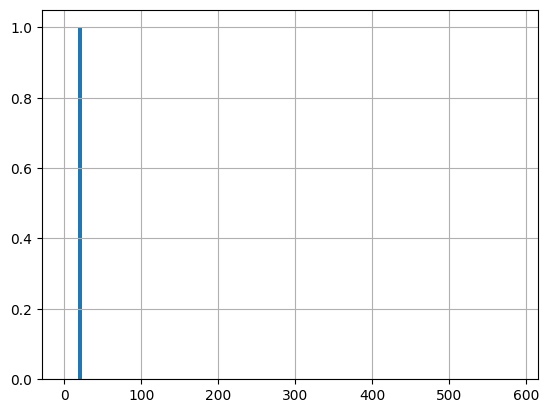

11254 , W_Completeren aanvraag : 2.0
count        2.0000
mean     34006.0000
std      48039.4205
min         37.0000
25%      17021.5000
50%      34006.0000
75%      50990.5000
max      67975.0000
Name: duration_seconds, dtype: float64


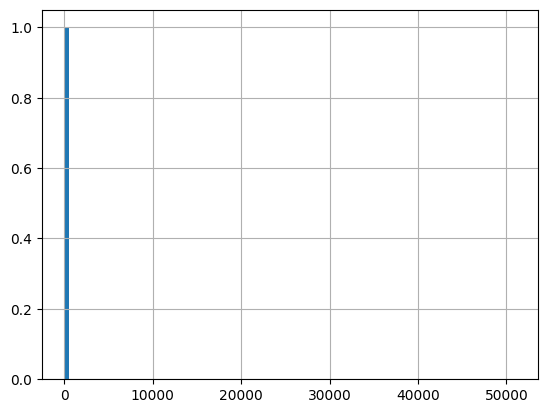

10125 , W_Valideren aanvraag : 2.0
count     2.000000
mean     66.000000
std      25.455844
min      48.000000
25%      57.000000
50%      66.000000
75%      75.000000
max      84.000000
Name: duration_seconds, dtype: float64


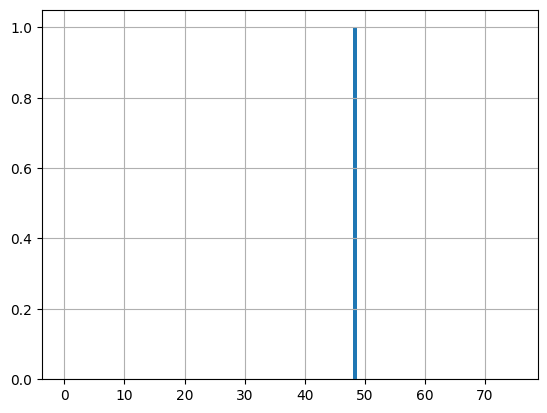

11189 , W_Valideren aanvraag : 2.0
count     2.000000
mean     26.000000
std       8.485281
min      20.000000
25%      23.000000
50%      26.000000
75%      29.000000
max      32.000000
Name: duration_seconds, dtype: float64


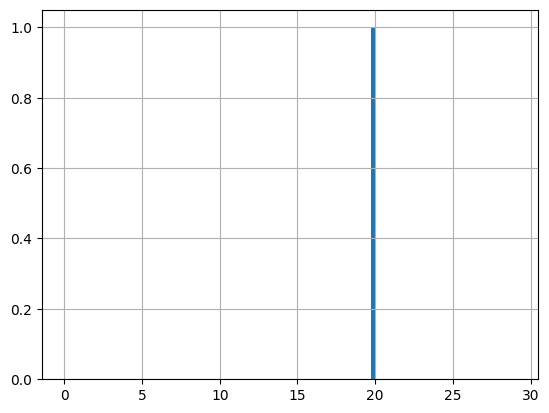

10914 , W_Valideren aanvraag : 2.0
count     2.000000
mean     70.500000
std      24.748737
min      53.000000
25%      61.750000
50%      70.500000
75%      79.250000
max      88.000000
Name: duration_seconds, dtype: float64


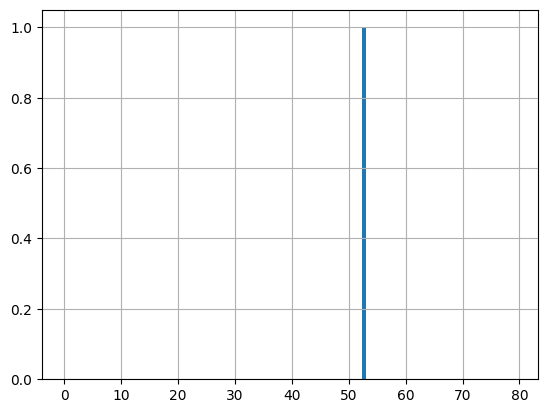

11289 , W_Completeren aanvraag : 2.0
count      2.000000
mean     109.500000
std       16.263456
min       98.000000
25%      103.750000
50%      109.500000
75%      115.250000
max      121.000000
Name: duration_seconds, dtype: float64


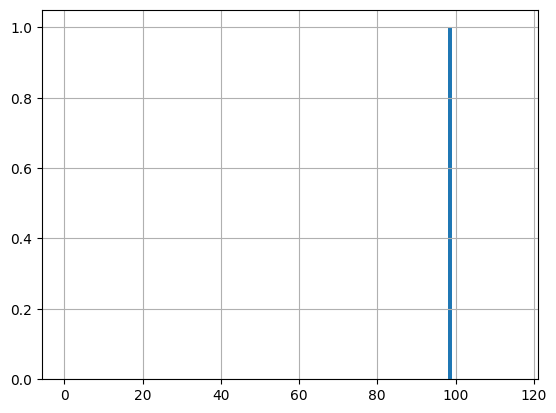

10779 , W_Afhandelen leads : 2.0
count      2.000000
mean     270.500000
std      249.608694
min       94.000000
25%      182.250000
50%      270.500000
75%      358.750000
max      447.000000
Name: duration_seconds, dtype: float64


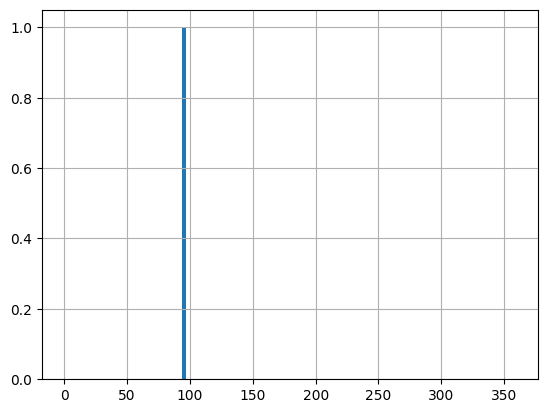

11259 , W_Completeren aanvraag : 2.0
count      2.000000
mean     801.000000
std      107.480231
min      725.000000
25%      763.000000
50%      801.000000
75%      839.000000
max      877.000000
Name: duration_seconds, dtype: float64


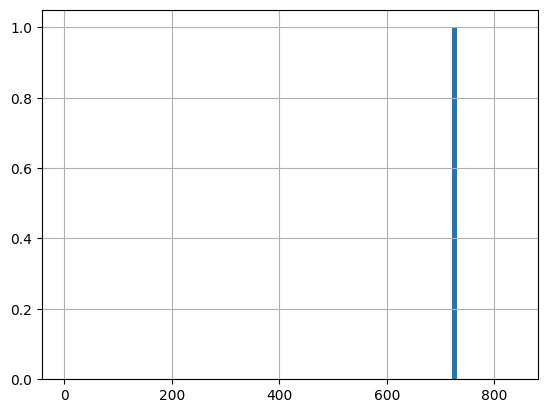

11299 , W_Afhandelen leads : 2.0
count      2.000000
mean     400.000000
std      545.886435
min       14.000000
25%      207.000000
50%      400.000000
75%      593.000000
max      786.000000
Name: duration_seconds, dtype: float64


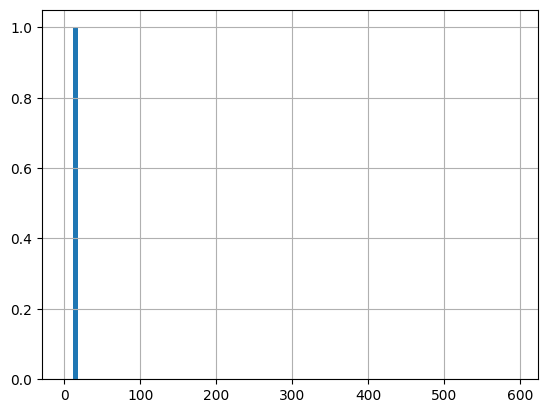

11339 , W_Nabellen incomplete dossiers : 2.0
count      2.000000
mean     120.500000
std      122.329473
min       34.000000
25%       77.250000
50%      120.500000
75%      163.750000
max      207.000000
Name: duration_seconds, dtype: float64


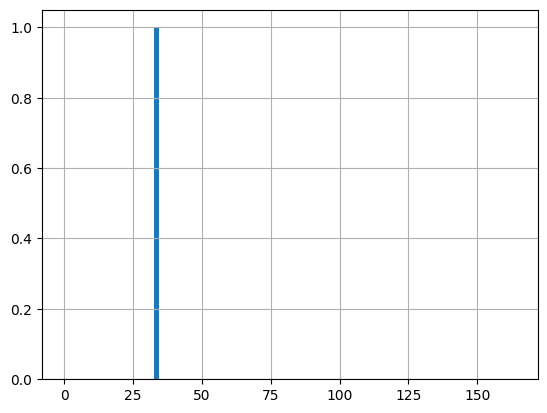

11079 , W_Nabellen offertes : 2.0
count       2.000000
mean     1073.000000
std      1494.823735
min        16.000000
25%       544.500000
50%      1073.000000
75%      1601.500000
max      2130.000000
Name: duration_seconds, dtype: float64


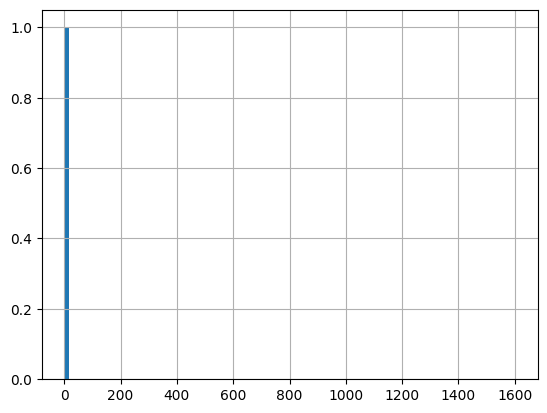

10939 , W_Valideren aanvraag : 2.0
count      2.000000
mean     401.500000
std      146.371104
min      298.000000
25%      349.750000
50%      401.500000
75%      453.250000
max      505.000000
Name: duration_seconds, dtype: float64


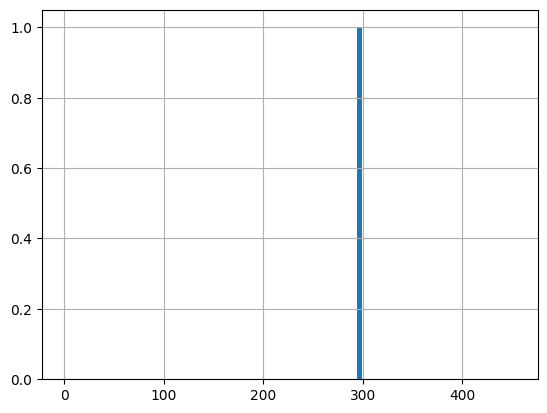

10124 , W_Nabellen offertes : 1.0
count     1.0
mean     23.0
std       NaN
min      23.0
25%      23.0
50%      23.0
75%      23.0
max      23.0
Name: duration_seconds, dtype: float64


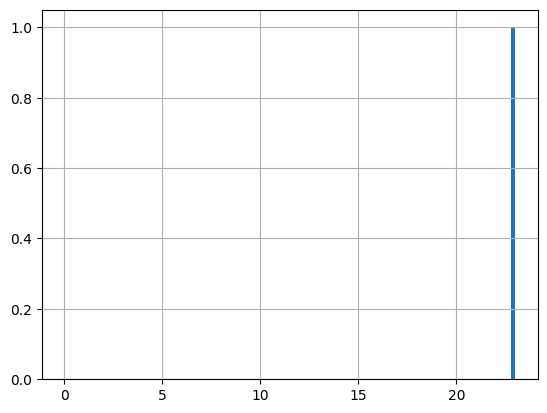

10124 , W_Completeren aanvraag : 1.0
count      1.0
mean     389.0
std        NaN
min      389.0
25%      389.0
50%      389.0
75%      389.0
max      389.0
Name: duration_seconds, dtype: float64


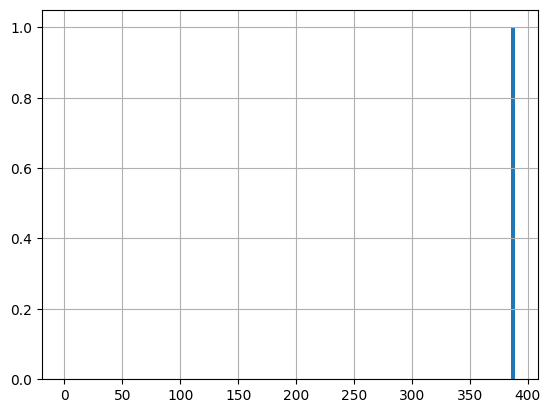

11302 , W_Valideren aanvraag : 1.0
count     1.0
mean     35.0
std       NaN
min      35.0
25%      35.0
50%      35.0
75%      35.0
max      35.0
Name: duration_seconds, dtype: float64


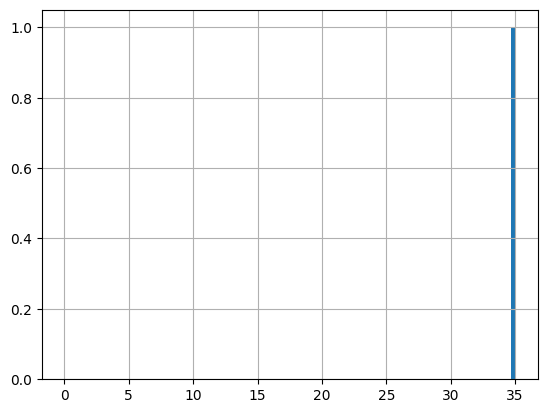

11203 , W_Valideren aanvraag : 1.0
count     1.0
mean     29.0
std       NaN
min      29.0
25%      29.0
50%      29.0
75%      29.0
max      29.0
Name: duration_seconds, dtype: float64


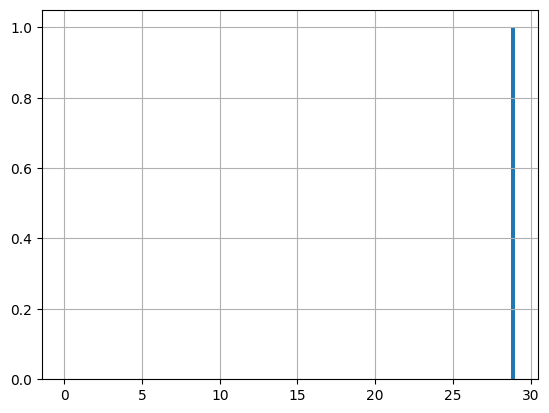

11201 , W_Valideren aanvraag : 1.0
count      1.0
mean     411.0
std        NaN
min      411.0
25%      411.0
50%      411.0
75%      411.0
max      411.0
Name: duration_seconds, dtype: float64


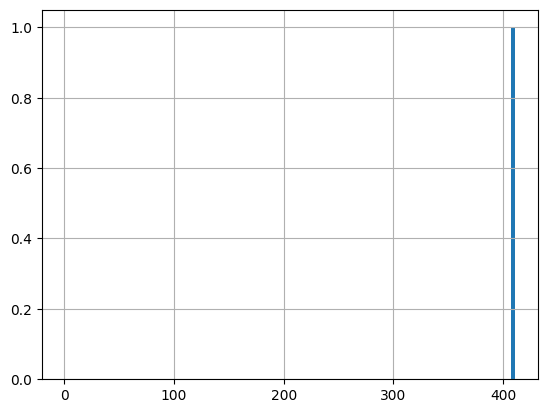

10899 , W_Afhandelen leads : 1.0
count      1.0
mean     181.0
std        NaN
min      181.0
25%      181.0
50%      181.0
75%      181.0
max      181.0
Name: duration_seconds, dtype: float64


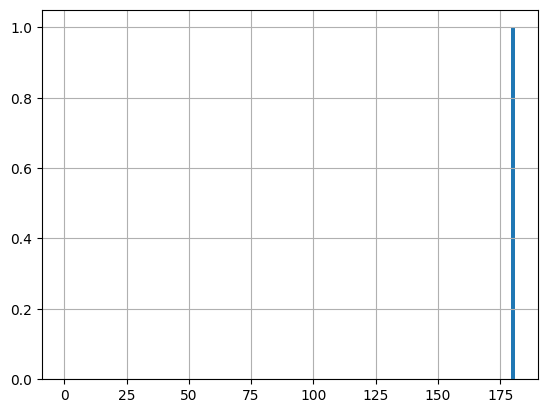

10124 , W_Valideren aanvraag : 1.0
count      1.0
mean     515.0
std        NaN
min      515.0
25%      515.0
50%      515.0
75%      515.0
max      515.0
Name: duration_seconds, dtype: float64


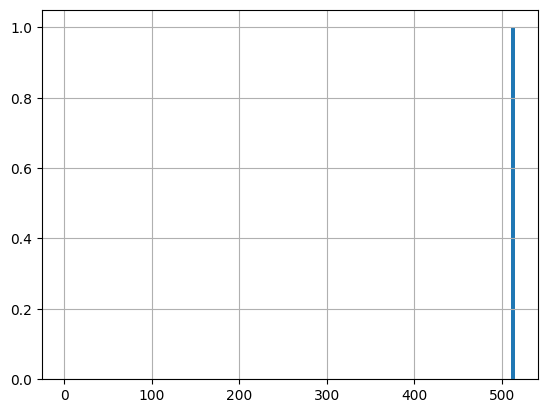

11319 , W_Afhandelen leads : 1.0
count     1.0
mean     97.0
std       NaN
min      97.0
25%      97.0
50%      97.0
75%      97.0
max      97.0
Name: duration_seconds, dtype: float64


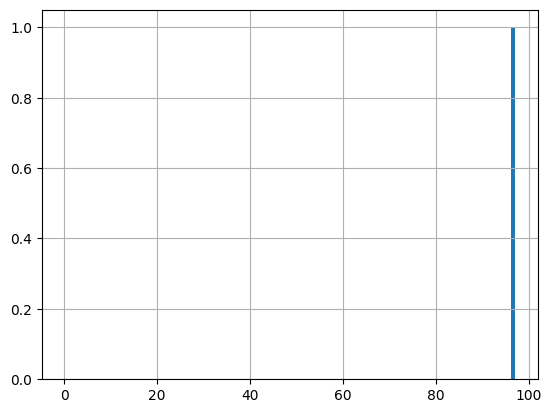

11179 , W_Valideren aanvraag : 1.0
count     1.0
mean     11.0
std       NaN
min      11.0
25%      11.0
50%      11.0
75%      11.0
max      11.0
Name: duration_seconds, dtype: float64


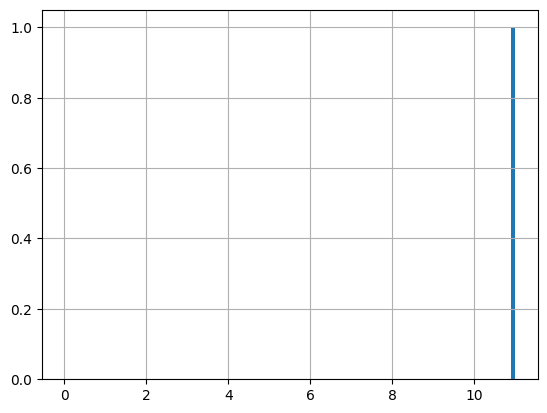

11339 , W_Beoordelen fraude : 1.0
count    1.0
mean     3.0
std      NaN
min      3.0
25%      3.0
50%      3.0
75%      3.0
max      3.0
Name: duration_seconds, dtype: float64


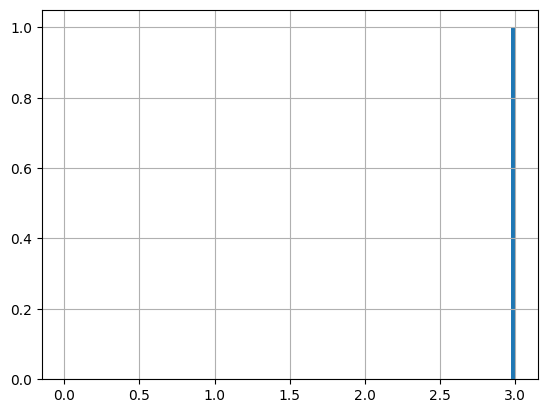

11002 , W_Valideren aanvraag : 1.0
count     1.0
mean     13.0
std       NaN
min      13.0
25%      13.0
50%      13.0
75%      13.0
max      13.0
Name: duration_seconds, dtype: float64


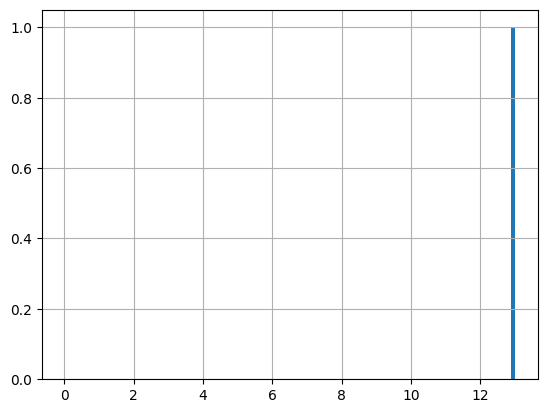

11000 , W_Valideren aanvraag : 1.0
count     1.0
mean     48.0
std       NaN
min      48.0
25%      48.0
50%      48.0
75%      48.0
max      48.0
Name: duration_seconds, dtype: float64


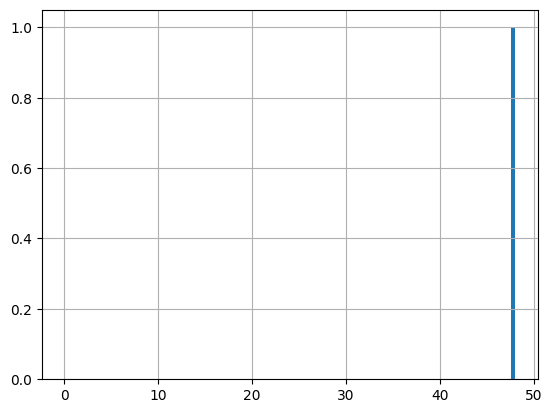

11079 , W_Afhandelen leads : 1.0
count    1.0
mean     9.0
std      NaN
min      9.0
25%      9.0
50%      9.0
75%      9.0
max      9.0
Name: duration_seconds, dtype: float64


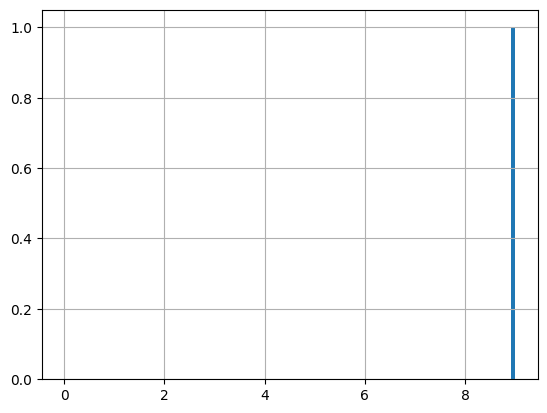

11299 , W_Valideren aanvraag : 1.0
count     1.0
mean     14.0
std       NaN
min      14.0
25%      14.0
50%      14.0
75%      14.0
max      14.0
Name: duration_seconds, dtype: float64


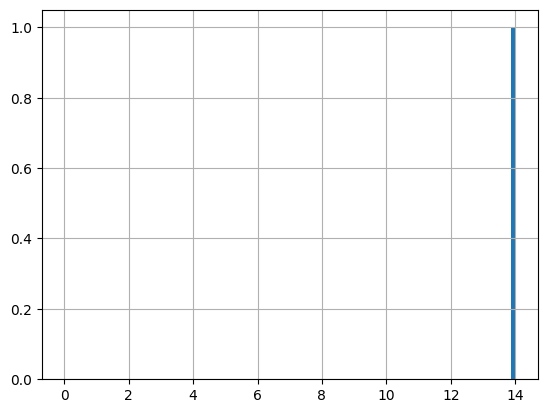

11001 , W_Nabellen incomplete dossiers : 1.0
count     1.0
mean     39.0
std       NaN
min      39.0
25%      39.0
50%      39.0
75%      39.0
max      39.0
Name: duration_seconds, dtype: float64


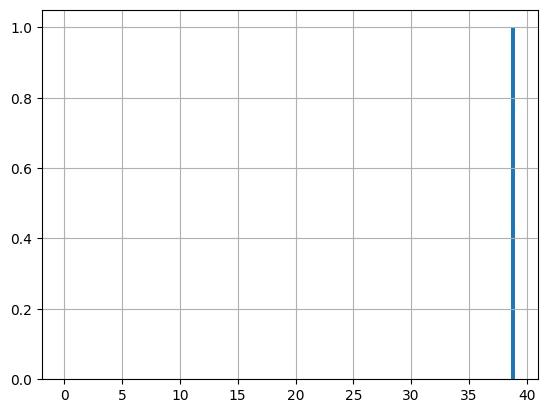

10931 , W_Valideren aanvraag : 1.0
count     1.0
mean     28.0
std       NaN
min      28.0
25%      28.0
50%      28.0
75%      28.0
max      28.0
Name: duration_seconds, dtype: float64


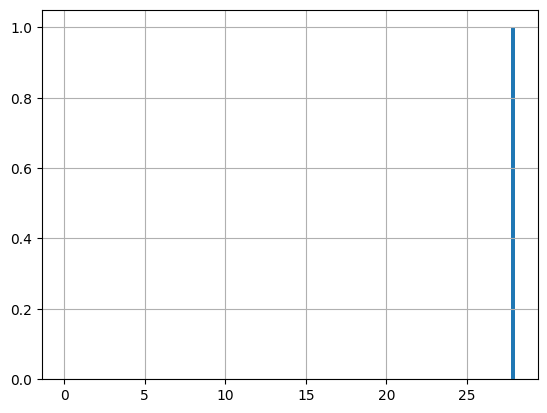

11019 , W_Valideren aanvraag : 1.0
count    1.0
mean     8.0
std      NaN
min      8.0
25%      8.0
50%      8.0
75%      8.0
max      8.0
Name: duration_seconds, dtype: float64


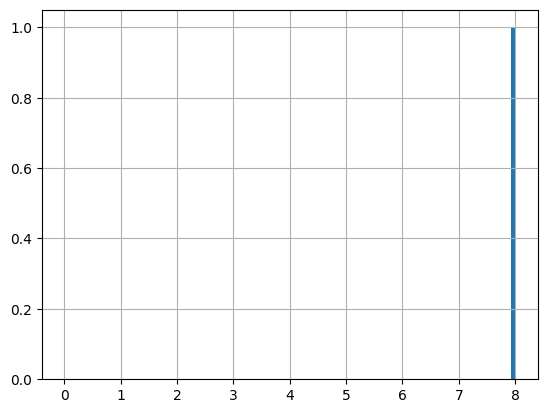

11269 , W_Nabellen incomplete dossiers : 1.0
count        1.0
mean     58811.0
std          NaN
min      58811.0
25%      58811.0
50%      58811.0
75%      58811.0
max      58811.0
Name: duration_seconds, dtype: float64


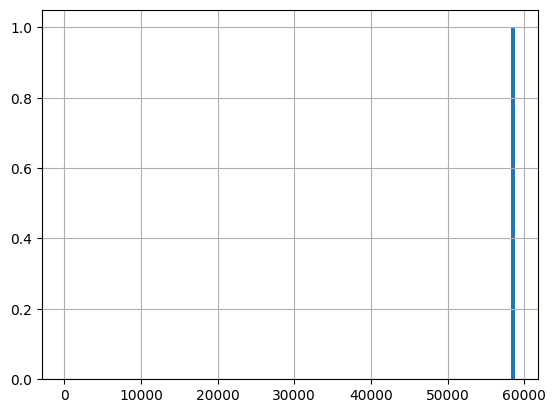

11269 , W_Nabellen offertes : 1.0
count        1.0
mean     58543.0
std          NaN
min      58543.0
25%      58543.0
50%      58543.0
75%      58543.0
max      58543.0
Name: duration_seconds, dtype: float64


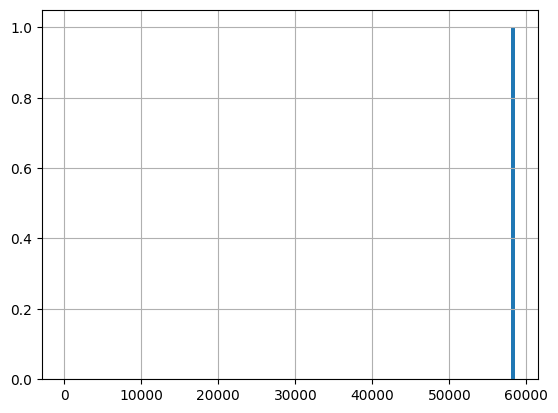

11269 , W_Afhandelen leads : 1.0
count        1.0
mean     58921.0
std          NaN
min      58921.0
25%      58921.0
50%      58921.0
75%      58921.0
max      58921.0
Name: duration_seconds, dtype: float64


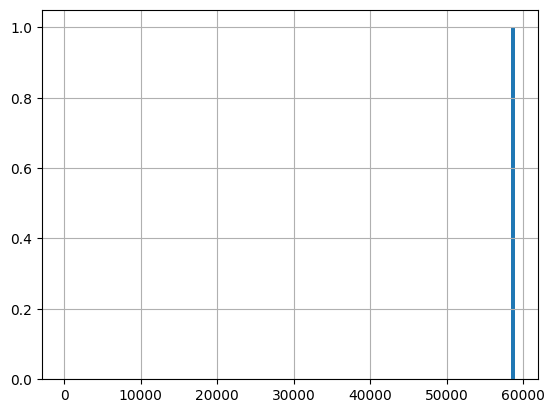

10789 , W_Completeren aanvraag : 1.0
count      1.0
mean     131.0
std        NaN
min      131.0
25%      131.0
50%      131.0
75%      131.0
max      131.0
Name: duration_seconds, dtype: float64


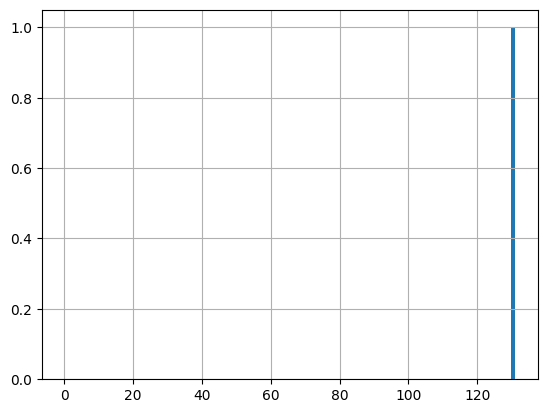

10821 , W_Valideren aanvraag : 1.0
count    1.0
mean     8.0
std      NaN
min      8.0
25%      8.0
50%      8.0
75%      8.0
max      8.0
Name: duration_seconds, dtype: float64


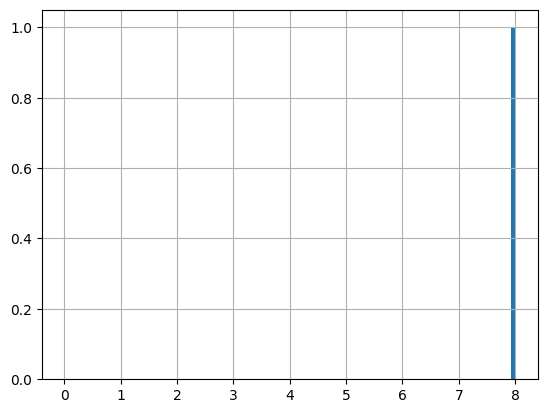

10124 , W_Afhandelen leads : 1.0
count     1.0
mean     11.0
std       NaN
min      11.0
25%      11.0
50%      11.0
75%      11.0
max      11.0
Name: duration_seconds, dtype: float64


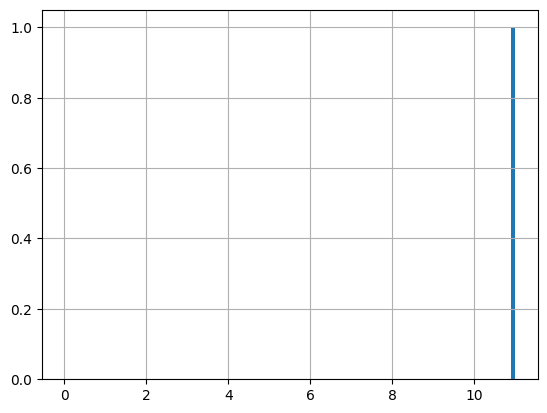

In [21]:
for i, row in start_end_event_log[['org:resource', 'concept:name']].value_counts().reset_index(name='count').iterrows():
    resource = row['org:resource']
    concept = row['concept:name']
    concept_resource_log = start_end_event_log[(start_end_event_log['org:resource'] == resource) & (start_end_event_log['concept:name'] == concept)]
    description = concept_resource_log['duration_seconds'].describe()
    print(resource, ',', concept, ':', description['count'])

    print(description)
    concept_resource_log['duration_seconds'].hist(bins=100, range=(0,description['75%']))
    plt.show()

# Gaussian Mixture Models

- We use activity: W_Afhandelen leads
- Afterwards we split by all resources with > 15 samples + all remaining resources
- Compare: ?

In [182]:
class GMM:
    def __init__(self, start_end_event_log, n=10, percentile=False):
        self.durations = start_end_event_log['duration_seconds'].to_numpy()
        self._get_x(start_end_event_log, percentile)
        self.gmm = self.get_gmm(self.x, n)

    def _get_x(self, durations, percentile):
        if percentile:
            self.durations = self.durations[self.durations <= np.percentile(self.durations, percentile)]
        self.x = np.ravel(self.durations).astype(np.float64).reshape(-1,1)
    
    def get_gmm(self, x, n):
        mm = GaussianMixture(n,
                             covariance_type='full',
                             n_init=10,
                             #covariance_type='spherical',
                             init_params='k-means++',
                             #init_params='kmeans',
                             #init_params='random_from_data',
                             #init_params='random',
                             max_iter=1000
                            )
        mm.fit(x)
        return mm

    def get_pdf_values(self, f_axis):
        X = np.ravel(f_axis).astype(np.float64).reshape(-1,1)
        pdf = lambda x : sum([weight * stats.norm.pdf(x, mean, np.sqrt(cov))[0] \
                              for weight, mean, cov in zip(self.gmm.weights_, self.gmm.means_, self.gmm.covariances_)])
        return np.array([pdf(x) for x in X]).flatten()

    def goodness(self):
        #predictions = self.get_pdf_values(self.x)
        #gmm_samples, _ = self.gmm.sample(100000)
        #data_hist_weights, data_hist_bins = np.histogram(self.x, bins=min(200, int(len(self.x))), density=False)
        #sample_hist_weights, sample_hist_bins  = np.histogram(gmm_samples, bins=min(200, int(len(self.x))), density=False)

        #bins_2_values = lambda bins : [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
        #data_hist_values, sample_hist_values = bins_2_values(data_hist_bins), bins_2_values(sample_hist_bins)
        #wd_hist = stats.wasserstein_distance(data_hist_values, sample_hist_values, data_hist_weights, sample_hist_weights)
        times_enlargen = int(100000 / len(self.x))
        augmented_x = np.array([])
        for i in range(times_enlargen):
            augmented_x = np.append(augmented_x, np.ravel(self.x))
        wd_x = stats.wasserstein_distance(augmented_x, self.gmm.sample(len(augmented_x))[0].ravel())
        #wd_pdf = stats.wasserstein_distance(np.ravel(self.x), np.ravel(self.x), predictions, np.ones(self.x.shape))
        #bic = self.gmm.bic(self.x)
        #aic = self.gmm.aic(self.x)
        #return ot.wasserstein_1d(np.ravel(self.x), np.ravel(self.x), predictions)
        return wd_x#, wd_hist, wd_pdf, bic, aic
    
    def plot_gmm(self, other_gmm=None, show_all=True, percentile=False):
        # remove outliers
        if percentile:
            pruned_durations = self.durations[self.durations <= np.percentile(self.durations, percentile)]
        else:
            pruned_durations = self.durations
        f_axis = np.linspace(pruned_durations.min()-10, pruned_durations.max(), 10000)
        predictions = self.get_pdf_values(f_axis)
        plt.plot(f_axis, predictions)
        
        gmm_samples, _ = self.gmm.sample(100000)
        plt.hist(gmm_samples, bins=min(200, int(len(self.x))), histtype='bar', density=True, alpha=0.5, range=(pruned_durations.min(), pruned_durations.max()))
        #predictions = np.exp(self.gmm.score_samples(np.ravel(f_axis).astype(np.float64).reshape(-1,1)))
        #plt.plot(f_axis, predictions)
        if show_all:
            _, bins, patches = plt.hist(self.x, bins=min(200, int(len(self.x))), histtype='bar', density=True, alpha=0.5, range=(pruned_durations.min(), pruned_durations.max()))
            max_height = max([i.get_height() for i in patches])
            plt.ylim(0, max_height*1.1)
            for i in range(len(self.gmm.weights_)):
                plt.plot(f_axis,self.gmm.weights_[i]*stats.norm.pdf(f_axis,self.gmm.means_[i],np.sqrt(self.gmm.covariances_[i])).ravel(),
                        linestyle='dashed')

            plt.scatter(self.gmm.means_, [0]*len(self.gmm.means_), marker='o', color='red') 
            
            plt.rcParams['agg.path.chunksize'] = 10000
            plt.grid()

        if other_gmm:
            plt.plot(f_axis, other_gmm.get_pdf_values(f_axis))
        plt.show()

class AutoGMM(GMM):
    def __init__(self, start_end_event_log, percentile=False,
                max_gaussians=100, min_data_per_gaussian=5,
                min_relative_improvement=0.1,
                max_fitting=5):
        self.n = 1
        super().__init__(start_end_event_log, self.n, percentile)
        goodness = self.goodness()
        max_gaussians = int(min(max_gaussians, len(self.x)/min_data_per_gaussian))
        for i in range(2, max_gaussians+1):
            self.get_gmm(self.x, i)
            super().__init__(start_end_event_log, i, percentile)
            new_goodness = self.goodness()
            self.n = i
            if min_relative_improvement * goodness > goodness - new_goodness:
                break
            if max_fitting > new_goodness:
                break
        

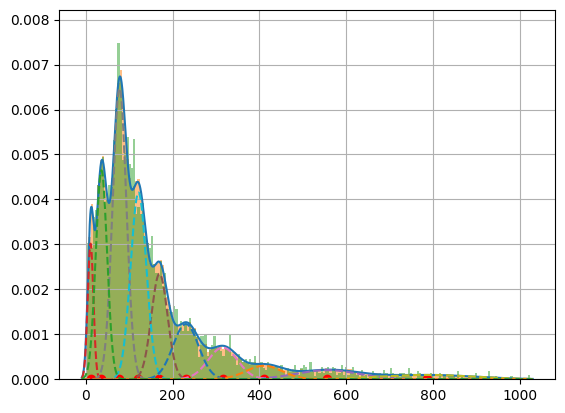

W_Afhandelen leads


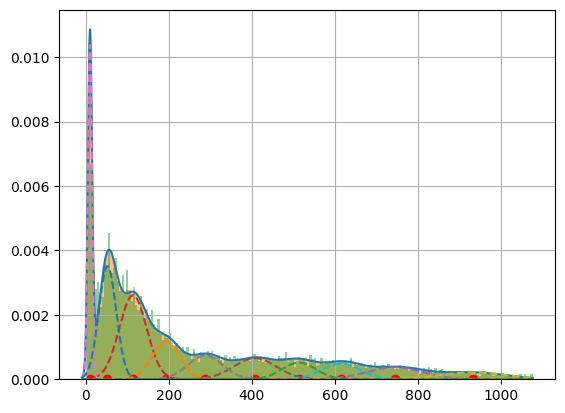

W_Completeren aanvraag


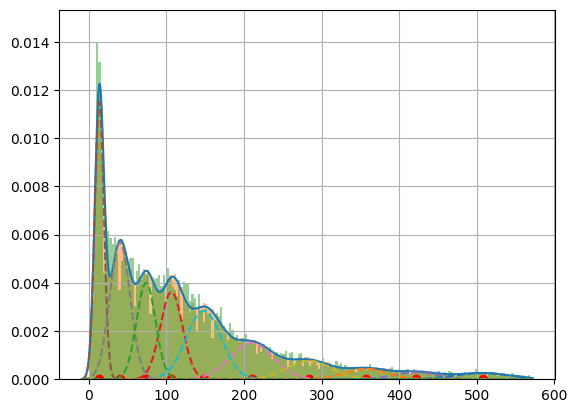

W_Nabellen offertes


KeyboardInterrupt: 

In [177]:
for concept in pandas.unique(start_end_event_log['concept:name']):
    concept_log = start_end_event_log[start_end_event_log['concept:name'] == concept]
    gmm = GMM(concept_log, 10, 95)
    gmm.plot_gmm(percentile=False)

    print(concept)

1 63.633033122982496


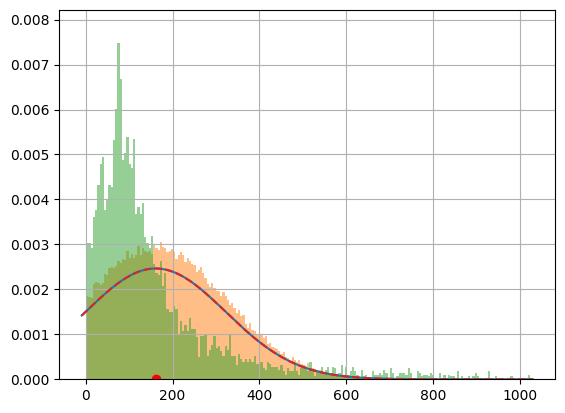

2 13.63332551607879


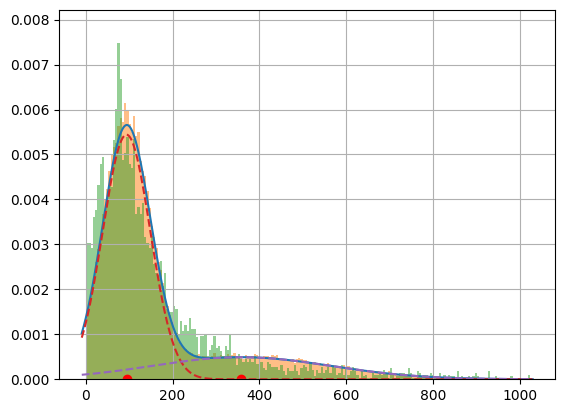

3 5.175988011377179


KeyboardInterrupt: 

In [169]:
activity_log = start_end_event_log[start_end_event_log['concept:name'] == 'W_Afhandelen leads']
activity_log = activity_log[activity_log['duration_seconds'] <= np.percentile(activity_log['duration_seconds'], 95)]

for i in range(1, activity_log.shape[0]+1):
    gmm2 = GMM(activity_log, i)
    print(i, gmm2.goodness())
    gmm2.plot_gmm()

3 3.3297247275390056


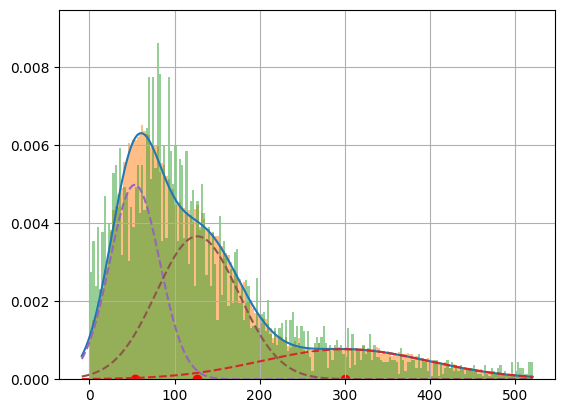

In [178]:
gmm2 = AutoGMM(activity_log, percentile=95)
print(gmm2.n, gmm2.goodness())
gmm2.plot_gmm()

1 (50.73347661038609, 50.699471303474624, 31.36790789580713, 388.3970908883482, 385.5946961250239)


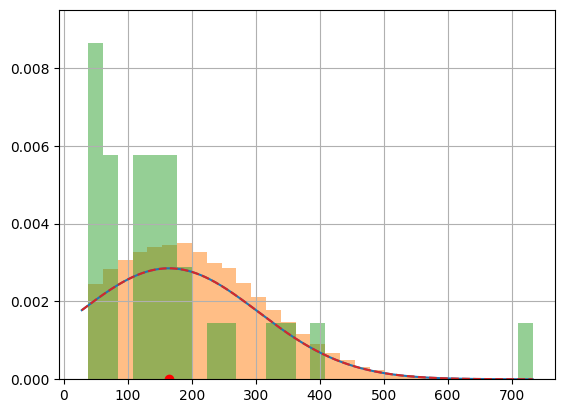

2 (24.966417559573493, 24.906515117347848, 564.7811336102708, 359.18693828076306, 352.1809513724523)


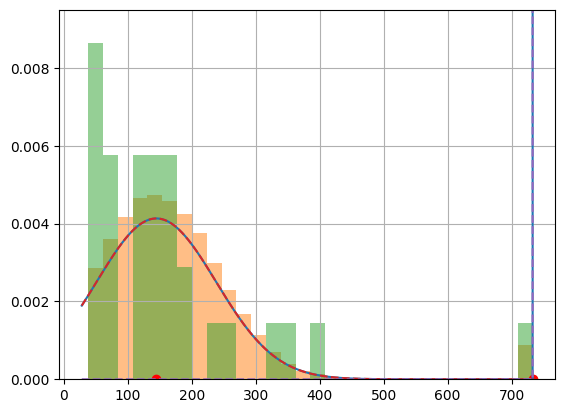

3 (11.07892216136451, 13.745833229201343, 563.8552246260261, 358.9100239663203, 347.70044491302303)


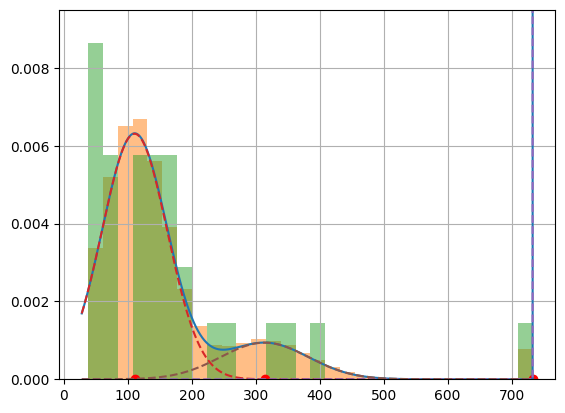

4 (6.742606187060055, 10.334232557513706, 562.5640284386197, 359.46154115636216, 344.04836995807847)


KeyboardInterrupt: 

In [145]:
activity_log = start_end_event_log[start_end_event_log['concept:name'] == 'W_Afhandelen leads']
#activity_log = activity_log[activity_log['duration_seconds'] <= np.percentile(activity_log['duration_seconds'], 95)]
resource_log = activity_log[activity_log['org:resource'] == '11019']

for i in range(1, resource_log.shape[0]+1):
    gmm2 = GMM(resource_log, i)
    print(i, gmm2.goodness())
    gmm2.plot_gmm()

1 (5.120021173545628, 7.94644255432539, 5.376585874730191, 100.13777471342836, 99.53260452744027)


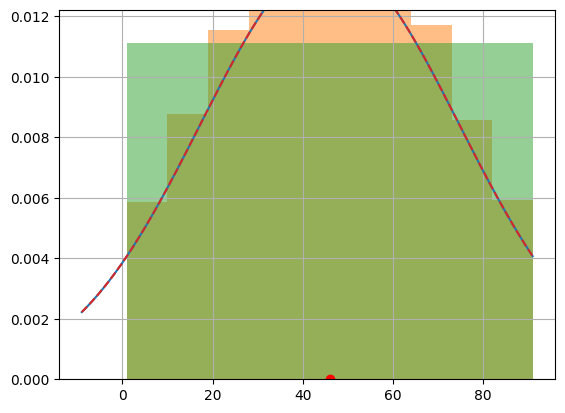

2 (3.199235247226875, 5.671088340363607, 2.0852726582350947, 105.45543182895914, 103.94250636398891)


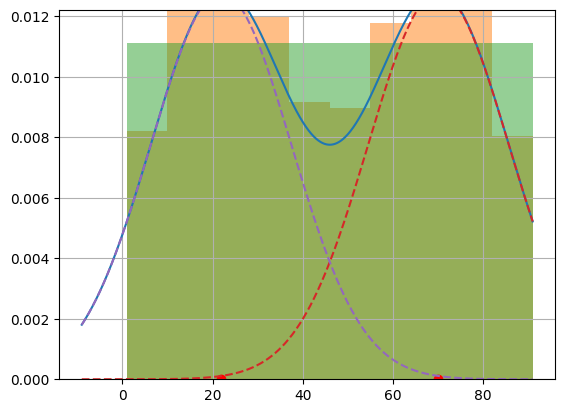

3 (2.8062884862666673, 4.7429079387605055, 1.1991595475424295, 111.4581650455542, 109.03748430160184)


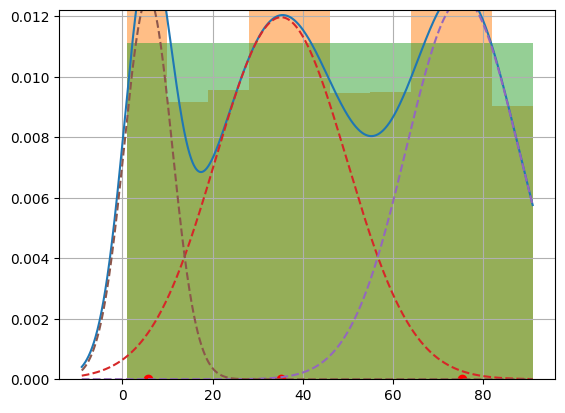

4 (2.577578219405116, 4.420519805612227, 0.5058593007428649, 117.73113674627824, 114.40270072334374)


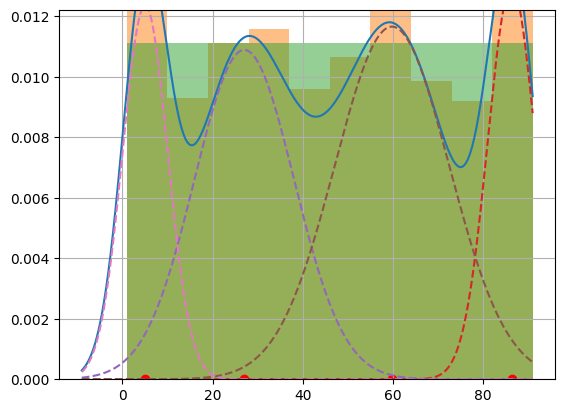

5 (2.1635370590593475, 4.0828785604461455, 39.951286156018355, 91.7962421645206, 87.56005086260399)


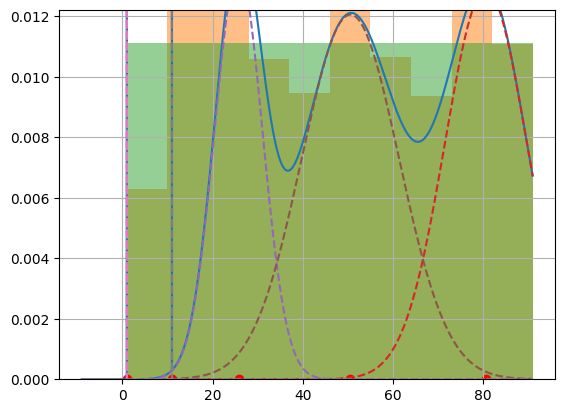

6 (1.818620783116494, 4.482009733031129, 19.650395139647042, 81.80975310246532, 76.66580652156657)


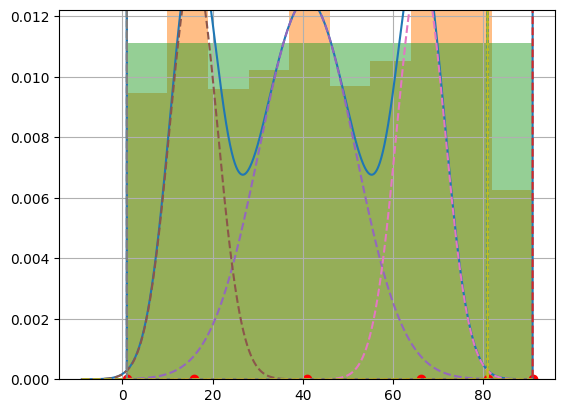

7 (1.441486686751487, 4.010760485940199, 24.987918665337574, 55.811531427277956, 49.75982956739705)


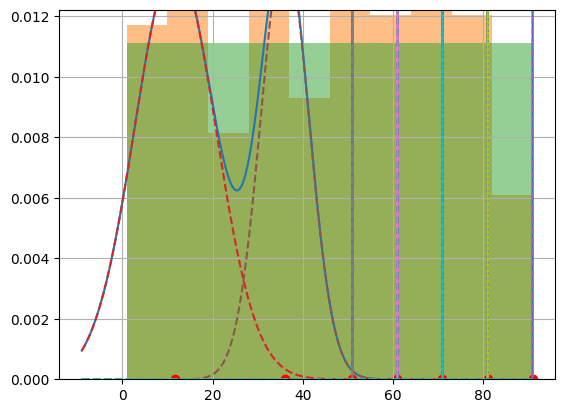

8 (1.058463848192596, 0.5585897166763674, 9.995879087169676, 45.73827454183945, 38.77881740297641)


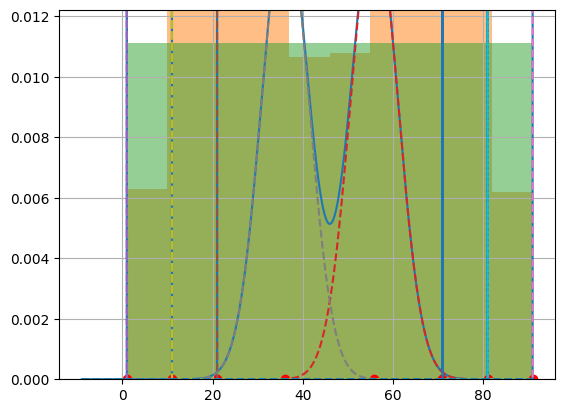

9 (0.5738185257584777, 3.8908336191306097, 9.996967525912574, 19.438754515007965, 11.571542097162784)


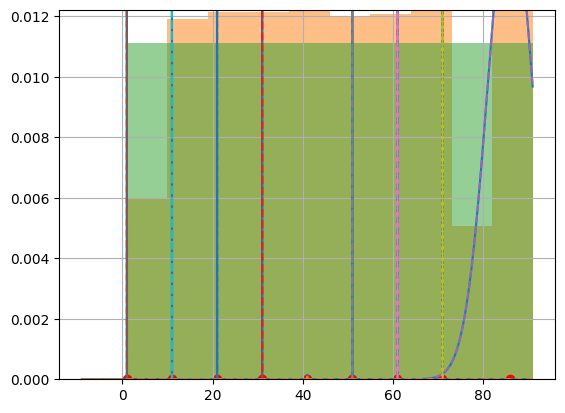

10 (0.14712863432515877, 0.0660361529539043, 0.0, -6.9496653588410595, -15.724633055668377)


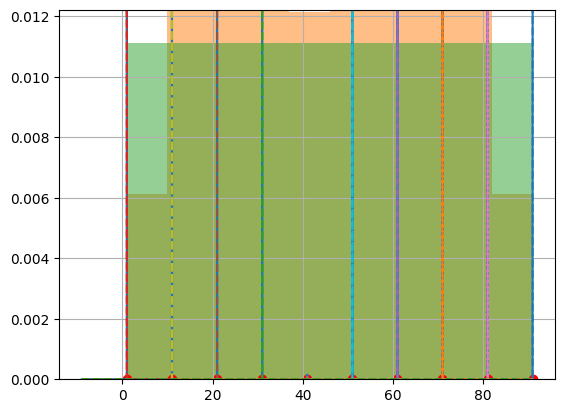

In [139]:
artificial_log = pandas.DataFrame([1, 11, 21, 31, 41, 51, 61, 71, 81, 91], columns=['duration_seconds'])

for i in range(1, artificial_log.shape[0]+1):
    gmm2 = GMM(artificial_log, i)
    print(i, gmm2.goodness())
    gmm2.plot_gmm()

# Wasserstein distance

ot.wasserstein_1d is crap: does not really weight

In [186]:
class GMMsWassersteinDistance:
    def __init__(self, gmm1, gmm2):
        self.gmm_1, self.gmm_2 = gmm1, gmm2

    def calculate(self, n=1000, std_devs=3):
        return self._get_wasserstein_distance(n, std_devs)

    def _get_sample_range_2(self, gmm, std_devs):
        model_mean = np.sum([mean*weight for weight, mean in zip(gmm.gmm.weights_, gmm.gmm.means_)])
        model_variance = np.sum([weight * variance for weight, variance in zip(gmm.gmm.weights_, gmm.gmm.covariances_)])
        model_std_dev = np.sqrt(model_variance)
        return model_mean - std_devs * model_std_dev, model_mean + std_devs * model_std_dev

    def _get_sample_range(self, gmm, std_devs):
        return np.min(gmm.x), np.max(gmm.x)

    def _sample_ppf(self, gmm, sample_range, n):
        x = np.linspace(sample_range[0], sample_range[1], n)
        #x = np.arange(sample_range[0], sample_range[1], 0.5)
        y = np.exp(gmm.gmm.score_samples(np.ravel(x).astype(np.float64).reshape(-1,1)))
        #Below: required for ot only
        #y = np.exp(gmm.gmm.score_samples(np.ravel(x).astype(np.float64).reshape(-1,1))) * (sample_range[1] - sample_range[0]) / n
        # either len(x) or n
        return x, y


    def _get_wasserstein_distance(self, n, std_devs):
        #sample_ranges = [self._get_sample_range(self.gmm_1, std_devs),
        #                 self._get_sample_range(self.gmm_2, std_devs),
        #                 #self._get_sample_range_2(self.gmm_1, std_devs),
        #                 #self._get_sample_range_2(self.gmm_2, std_devs)
        #                ]
        #sample_range = min(zip(*sample_ranges))[0], max(zip(*sample_ranges))[1]
        #print(sample_range)
        #u_values, u_weights = self._sample_ppf(self.gmm_1, sample_range, n)
        #v_values, v_weights = self._sample_ppf(self.gmm_2, sample_range, n)
        #wd_1 = stats.wasserstein_distance(u_values, v_values, u_weights, v_weights)
        
        #sample only from ppfs
        gmm_1_samples, _ = self.gmm_1.gmm.sample(n)
        gmm_2_samples, _ = self.gmm_2.gmm.sample(n)
        wd_2 = stats.wasserstein_distance(gmm_1_samples.ravel(), gmm_2_samples.ravel())
        #return wd_1, wd_2
        return wd_2

In [93]:
gmm1 = GMM(start_end_event_log[start_end_event_log['concept:name'] == 'W_Afhandelen leads'], 5, 95)
gmm2 = GMM(start_end_event_log[start_end_event_log['concept:name'] == 'W_Completeren aanvraag'], 50, 95)


In [101]:
wd = GMMsWassersteinDistance(gmm1.gmm, gmm2.gmm)
wd._get_wasserstein_distance()

TypeError: GMMsWassersteinDistance._get_wasserstein_distance() missing 2 required positional arguments: 'n' and 'std_devs'

# Split

- We use activity: W_Afhandelen leads
- Afterwards we split by all resources with > 15 samples + all remaining resources
- Compare: ?


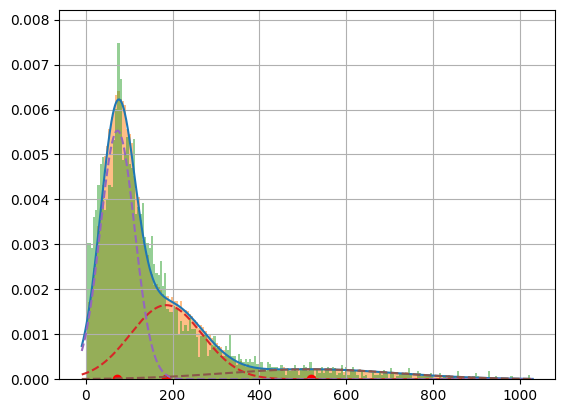

11169 435 17.960084293949908 4.2501833974845855
10910 416 34.9928919411322 3.928977760599537
10982 281 25.93503048694862 3.0585080131625904
10889 197 26.873573561119834 3.7699351016396303
10909 191 13.376469353053103 4.447413142562066
10932 187 29.19004765342158 4.8293052526041675
10913 185 53.861945161920154 4.169714402758877
10863 184 100.96469929531199 4.8884700775916
11009 180 32.252204277884516 4.680102286820277
11189 180 17.635417607183186 3.9939589180239943
10881 175 66.77480247984147 4.567462534609683
10861 175 10.954979096228499 5.002238625333233
11122 171 14.447863923006794 4.474669507252721
11003 166 50.23841146068082 3.8059948077393533
10939 153 34.058545567171265 3.6124705067292098
10929 151 41.105313109292815 3.573145926326269
11119 147 56.63649096597919 4.525472983544991
11203 133 16.06266622522697 4.356088154280544
11000 111 56.97591328018414 4.6474458445880025
11121 102 31.456974717973054 4.382634024698034
10228 101 43.8104266419346 4.682741691869846
10629 83 30.262054

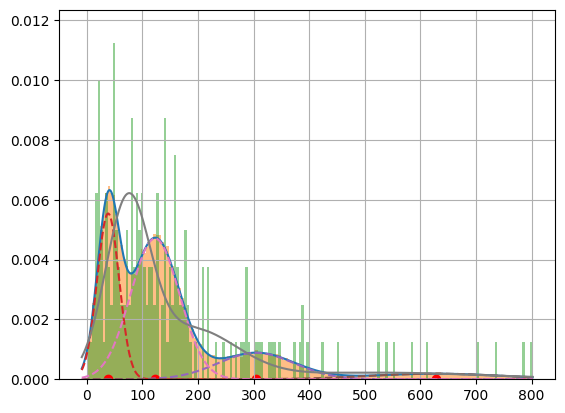

max wd (230.21019693317515, <__main__.AutoGMM object at 0x7f32c3943c40>, 15, '11002')


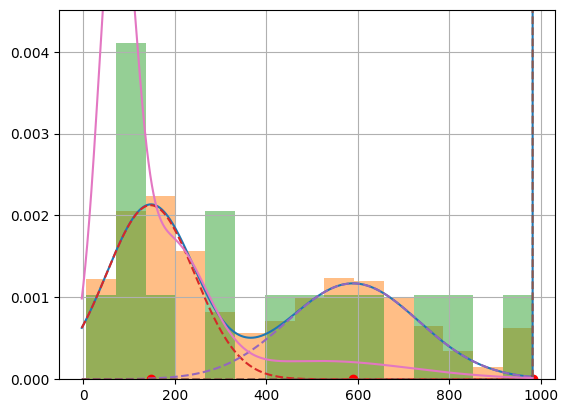

In [189]:
activity_log = start_end_event_log[start_end_event_log['concept:name'] == 'W_Afhandelen leads']
activity_log = activity_log[activity_log['duration_seconds'] <= np.percentile(activity_log['duration_seconds'], 95)]

gmm1 = AutoGMM(activity_log)
resources = list(activity_log['org:resource'].value_counts().reset_index()['org:resource'])
gmm1.plot_gmm()

min_wd, max_wd = (np.inf, np.inf), (0, 0)
for resource in resources:
    activity_resource_log = activity_log[activity_log['org:resource'] == resource]
    if activity_resource_log.shape[0] >= 15:
        gmm2 = AutoGMM(activity_resource_log)
        wd = GMMsWassersteinDistance(gmm1, gmm2).calculate(10000)
        print(resource, activity_resource_log.shape[0], wd, gmm2.goodness())
        #gmm2.plot_gmm(gmm1)
        if wd > max_wd[0]:
            max_wd = wd, gmm2, activity_resource_log.shape[0], resource
        if wd < min_wd[0]:
            min_wd = wd, gmm2, activity_resource_log.shape[0], resource

print('min wd', min_wd)
min_wd[1].plot_gmm(gmm1)
print('max wd', max_wd)
max_wd[1].plot_gmm(gmm1)

10000.0


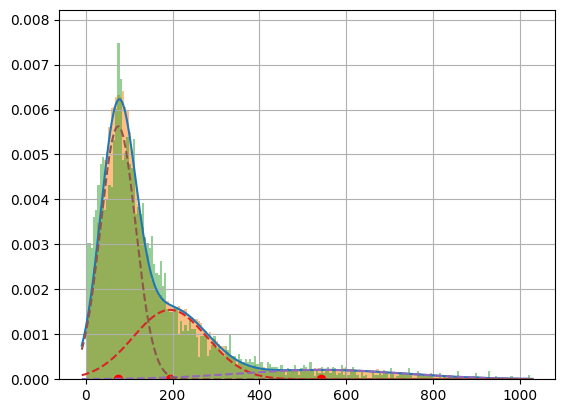

low amount wd 13.120417473091466


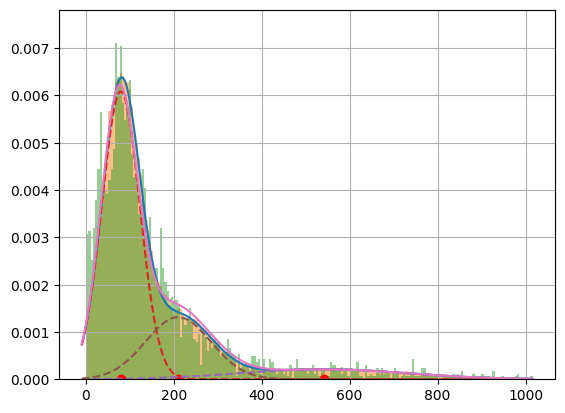

high amount wd 13.84468332119275


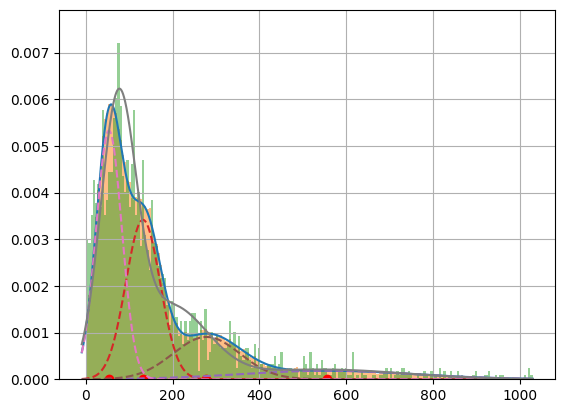

In [198]:
activity_log = start_end_event_log[start_end_event_log['concept:name'] == 'W_Afhandelen leads']
activity_log = activity_log[activity_log['duration_seconds'] <= np.percentile(activity_log['duration_seconds'], 95)]

amounts = activity_log['case:AMOUNT_REQ_start'].astype(int)
print(amounts.median())
amount_low_log = activity_log[activity_log['case:AMOUNT_REQ_start'].astype(int) <= amounts.median()]
amount_high_log = activity_log[activity_log['case:AMOUNT_REQ_start'].astype(int) > amounts.median()]


gmm1 = AutoGMM(activity_log)
gmm_high = AutoGMM(amount_high_log)
high_wd = GMMsWassersteinDistance(gmm1, gmm_high).calculate()

gmm_low = AutoGMM(amount_low_log)
low_wd = GMMsWassersteinDistance(gmm1, gmm_low).calculate()

gmm1.plot_gmm()

print('low amount wd', low_wd)
gmm_low.plot_gmm(gmm1)

print('high amount wd', high_wd)
gmm_high.plot_gmm(gmm1)

In [ ]:


subs = []
for i, row in start_end_event_log[start_end_event_log['concept:name'] == concept_name]['org:resource'].value_counts().reset_index(name='count').iterrows():
    resource_name = row['org:resource']
    
    concept_resource_log = start_end_event_log[(start_end_event_log['org:resource'] == resource_name) & (start_end_event_log['concept:name'] == concept_name)]
    description = concept_resource_log['duration_seconds'].describe()
    if description['count'] > 100:
        concept_resource_durations = concept_resource_log['duration_seconds']
        gmm_2 = get_gmm(concept_resource_durations)
        pdf_2 = get_pdf_values(concept_durations, gmm_2)
        wd = stats.wasserstein_distance(pdf, pdf_2)
        subs.append((wd, resource_name, pdf_2, description))
        print(resource_name, ',', concept, ':', description['count'], wd)
    else:
        print(resource_name, ',', concept, ':', description['count'])

    if description['count'] > 100:
        plot_gmm(concept_durations, pdf_2, False)


plot_gmm(concept_durations, pdf)



In [ ]:
#print(subs)
max_wd = max(
    filter(lambda k : k[3]['count'] > 100, subs),
    key=lambda k : k[0])
print(max_wd[1], max_wd[0])

plot_gmm(concept_durations, pdf, False)

plot_gmm(concept_durations, max_wd[2])

In [ ]:
#print(subs)
min_wd = min(
    filter(lambda k : k[3]['count'] > 100, subs),
    key=lambda k : k[0])
print(min_wd[1], min_wd[0]*800)

plot_gmm(concept_durations, pdf, False)
plot_gmm(concept_durations, min_wd[2])

In [ ]:
plot_gmm(concept_durations, pdf, False)
plot_gmm(concept_durations, min_wd[2], False)
plot_gmm(concept_durations, max_wd[2], True)
